In [134]:
%load_ext autoreload
%autoreload 2
import h5py
from scint_funcs import upchannel as upchan
from scint_funcs import make_scallop_model, acf_scint_plot, scrunch, acf_per_subband, weighted_avg_and_std
from scint_funcs import lorentz_withc_min, lorentz_w_c, doublelorentz_withc_min, doublelorentz_w_c,triplelorentz_min, triplelorentz, lorentz, lin, linmin
from scint_funcs import scint_freq_relation, scint_freq_relation_min
from scint_funcs import emission_size, res

import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from lmfit import minimize, Parameters, fit_report, Model, Minimizer, report_fit

import matplotlib.gridspec as gridspec

import scipy.constants as cons

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
#matplotlib specs
import matplotlib as mpl

mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'sans-serif'                                                                                                                           
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['xtick.major.pad']='6'
mpl.rcParams['ytick.major.pad']='6'


# First let's load in the data.
## Data is publically available: DOI 

In [4]:
hf = h5py.File('FRB20221022A_data.h5', 'r')

data=hf['onburst_data'][:]
data_off=hf['offburst_data'][:]
freq=hf['freq_MHz'][:]
freqid=hf['freq_channel'][:]

## Upsample in frequency by a factor of 16

In [5]:
fftsize=16
downfreq=1
data_dedisp_masked_upchan_ds = upchan(data,freqid,fftsize=fftsize,downfreq=downfreq)
#upchannel the noise to model the scalloping
noise_dedisp_masked_upchan_ds = upchan(data_off,freqid,fftsize=fftsize,downfreq=downfreq)

model_ds, inds = make_scallop_model(noise_dedisp_masked_upchan_ds[0], fftsize, downfreq)

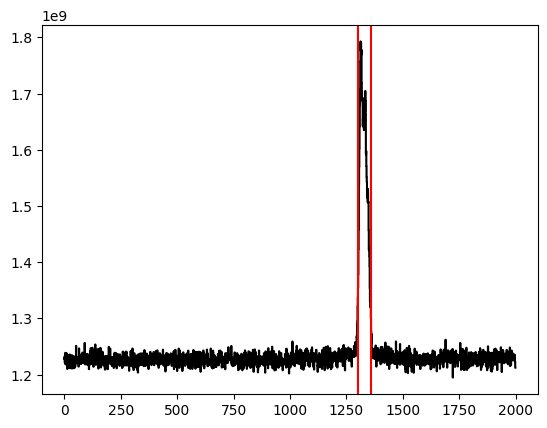

In [6]:
power = np.abs(data_dedisp_masked_upchan_ds[0]**2)
I_upchan_ds = np.sum(power,axis=0).T

#beginning and end index of the burst
beginburst=1300
endburst = 1358

plt.plot(np.nanmean(I_upchan_ds,axis=0), drawstyle='steps-mid',color='k')
plt.axvline(beginburst,color='r')
plt.axvline(endburst,color='r')
plt.show()

In [7]:
#per channel remove the scalloping
#also normalise using the off burst data

#off burst time range in bins
offburst_begin=0
offburst_end=600

I_upchan_corrected = np.zeros_like(I_upchan_ds)
for time_bin in range(I_upchan_ds.shape[1]):
    I_upchan_corrected[:,time_bin] = I_upchan_ds[:,time_bin]/model_ds
    
    
for freq_chan in range(I_upchan_corrected.shape[0]):
    Ioff=I_upchan_corrected[freq_chan,offburst_begin:offburst_end]
    I_upchan_corrected[freq_chan,:] = I_upchan_corrected[freq_chan,:] - np.nanmean(Ioff)
    Ioff-=np.nanmean(Ioff)
    I_upchan_corrected[freq_chan,:] = I_upchan_corrected[freq_chan,:] / np.nanstd(Ioff)
    

/tmp/ipykernel_72/265057136.py:17: RuntimeWarning: invalid value encountered in divide
  I_upchan_corrected[freq_chan,:] = I_upchan_corrected[freq_chan,:] / np.nanstd(Ioff)


In [8]:
#let's find any outlying RFI spikes in the off burst data and flag from our data

spec_off = np.nanmean(I_upchan_corrected[:,offburst_begin:offburst_end],axis=1)

spec_off[np.isnan(spec_off)]=0
spec_off=np.ma.masked_where(spec_off==0,spec_off)

calib_off=spec_off-np.nanmean(spec_off)
calib_off/=np.std(calib_off)
newinds=np.where(np.abs(calib_off)>3)[0]

I_upchan_corrected[newinds,:]=0
I_upchan_corrected = np.ma.masked_where(I_upchan_corrected==0,I_upchan_corrected) 

/tmp/ipykernel_72/1443469501.py:3: RuntimeWarning: Mean of empty slice
  spec_off = np.nanmean(I_upchan_corrected[:,offburst_begin:offburst_end],axis=1)


/tmp/ipykernel_72/684625657.py:17: RuntimeWarning: Mean of empty slice
  spec_upchan = np.nanmean(I_upchan_corrected[:,i-2:i+2],axis=1)
/tmp/ipykernel_72/684625657.py:20: RuntimeWarning: Mean of empty slice
  spec_fake = np.nanmean(I_upchan_corrected[:,1200:1204],axis=1)


Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2711.54it/s]


Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 244
    # variables        = 3
    chi-square         = 39.8095290
    reduced chi-square = 0.16518477
    Akaike info crit   = -436.387108
    Bayesian info crit = -425.895603
[[Variables]]
    gamma1:  0.03220144 +/- 0.02126190 (66.03%) (init = 0.2)
    m1:      1.59001458 +/- 0.76652695 (48.21%) (init = 1)
    c:       0.24530000 +/- 0.01519675 (6.20%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9948
    C(gamma1, c)  = -0.2942
    C(m1, c)      = +0.2638
None


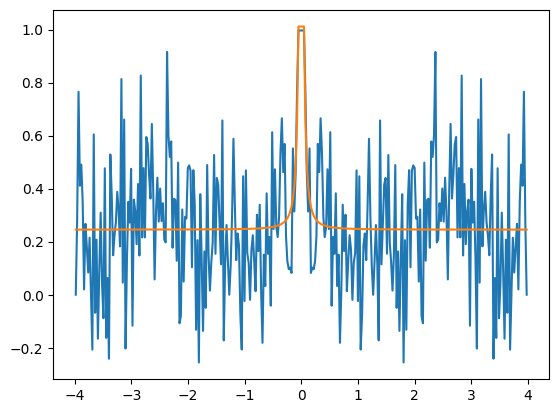

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2707.40it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 4.86712820
    reduced chi-square = 0.02019555
    Akaike info crit   = -949.178054
    Bayesian info crit = -938.686549
[[Variables]]
    gamma1:  0.07157772 +/- 0.00705372 (9.85%) (init = 0.2)
    m1:      1.05147654 +/- 0.04477718 (4.26%) (init = 1)
    c:       0.37702036 +/- 0.00619866 (1.64%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9241
    C(gamma1, c)  = -0.3359
    C(m1, c)      = +0.1778
None


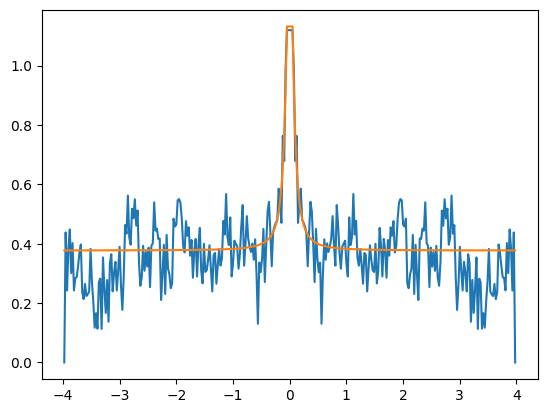

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2771.79it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 2.09799765
    reduced chi-square = 0.00870538
    Akaike info crit   = -1154.50910
    Bayesian info crit = -1144.01760
[[Variables]]
    gamma1:  0.06740166 +/- 0.00434199 (6.44%) (init = 0.2)
    m1:      1.09584421 +/- 0.03192130 (2.91%) (init = 1)
    c:       0.34059706 +/- 0.00389099 (1.14%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9356
    C(gamma1, c)  = -0.3268
    C(m1, c)      = +0.1877
None


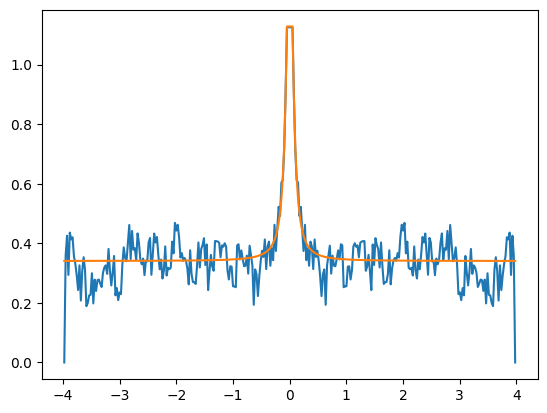

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2762.31it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 244
    # variables        = 3
    chi-square         = 1.73271503
    reduced chi-square = 0.00718969
    Akaike info crit   = -1201.18479
    Bayesian info crit = -1190.69329
[[Variables]]
    gamma1:  0.04675495 +/- 0.00463543 (9.91%) (init = 0.2)
    m1:      1.16848555 +/- 0.06791273 (5.81%) (init = 1)
    c:       0.36825626 +/- 0.00344395 (0.94%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9795
    C(gamma1, c)  = -0.3113
    C(m1, c)      = +0.2414
None


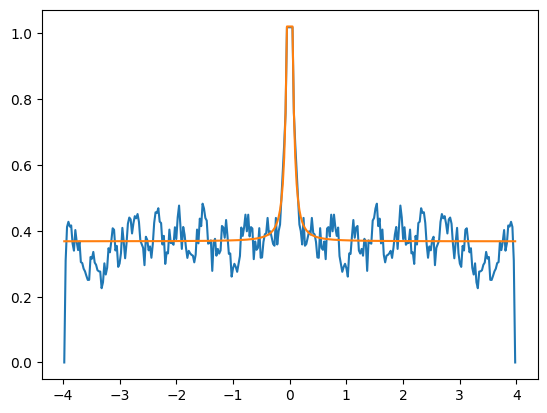

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2748.20it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 1.48202195
    reduced chi-square = 0.00614947
    Akaike info crit   = -1239.31766
    Bayesian info crit = -1228.82615
[[Variables]]
    gamma1:  0.05117520 +/- 0.00422847 (8.26%) (init = 0.2)
    m1:      1.12258102 +/- 0.05104927 (4.55%) (init = 1)
    c:       0.38768711 +/- 0.00328785 (0.85%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9721
    C(gamma1, c)  = -0.3172
    C(m1, c)      = +0.2322
None


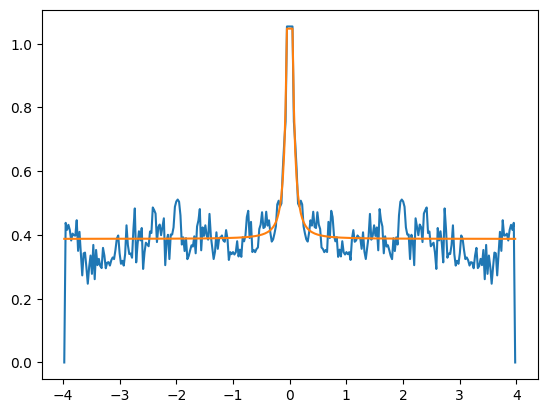

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2770.17it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 244
    # variables        = 3
    chi-square         = 1.44889492
    reduced chi-square = 0.00601201
    Akaike info crit   = -1244.83357
    Bayesian info crit = -1234.34206
[[Variables]]
    gamma1:  0.07953508 +/- 0.00507657 (6.38%) (init = 0.2)
    m1:      0.88210198 +/- 0.02317971 (2.63%) (init = 1)
    c:       0.38662943 +/- 0.00334865 (0.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9006
    C(gamma1, c)  = -0.3486
    C(m1, c)      = +0.1565
None


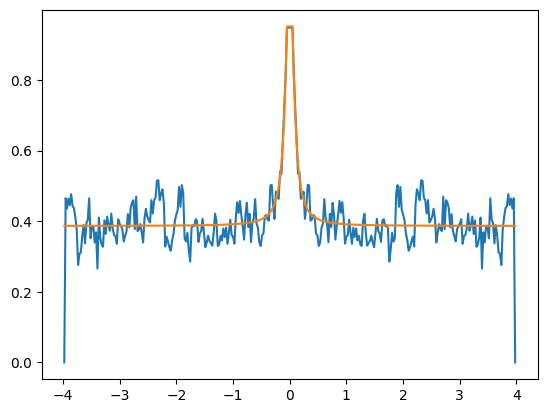

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2783.74it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 244
    # variables        = 3
    chi-square         = 2.48991795
    reduced chi-square = 0.01033161
    Akaike info crit   = -1112.72011
    Bayesian info crit = -1102.22860
[[Variables]]
    gamma1:  0.04523858 +/- 0.00724011 (16.00%) (init = 0.2)
    m1:      1.03269324 +/- 0.09948180 (9.63%) (init = 1)
    c:       0.40687986 +/- 0.00419074 (1.03%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9812
    C(gamma1, c)  = -0.3168
    C(m1, c)      = +0.2487
None


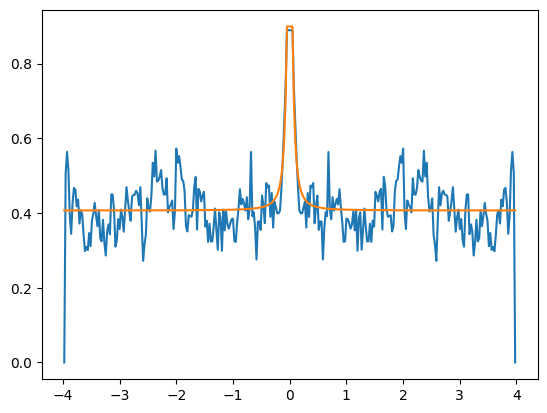

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2777.41it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 244
    # variables        = 3
    chi-square         = 1.64704744
    reduced chi-square = 0.00683422
    Akaike info crit   = -1213.55689
    Bayesian info crit = -1203.06538
[[Variables]]
    gamma1:  0.06557540 +/- 0.00540619 (8.24%) (init = 0.2)
    m1:      0.90851080 +/- 0.03519265 (3.87%) (init = 1)
    c:       0.37219518 +/- 0.00341916 (0.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9392
    C(gamma1, c)  = -0.3333
    C(m1, c)      = +0.1949
None


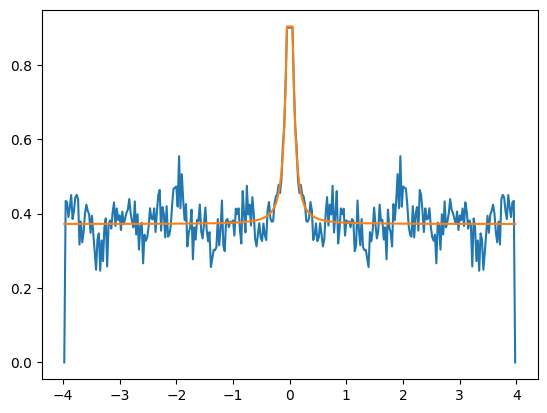

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2828.58it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 244
    # variables        = 3
    chi-square         = 1.70974811
    reduced chi-square = 0.00709439
    Akaike info crit   = -1204.44061
    Bayesian info crit = -1193.94910
[[Variables]]
    gamma1:  0.04719753 +/- 0.00537990 (11.40%) (init = 0.2)
    m1:      1.05884245 +/- 0.07077657 (6.68%) (init = 1)
    c:       0.36285795 +/- 0.00335991 (0.93%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9782
    C(gamma1, c)  = -0.3142
    C(m1, c)      = +0.2413
None


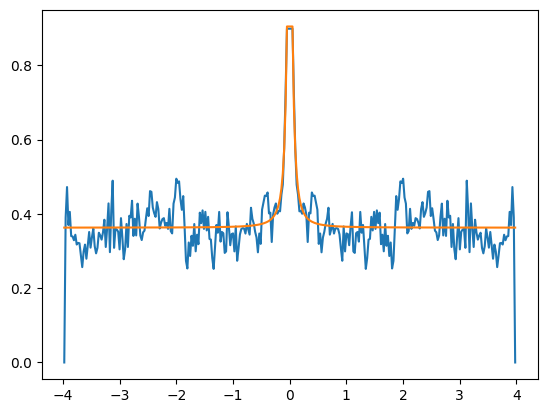

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2840.61it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 244
    # variables        = 3
    chi-square         = 2.10063832
    reduced chi-square = 0.00871634
    Akaike info crit   = -1154.20218
    Bayesian info crit = -1143.71067
[[Variables]]
    gamma1:  0.07969880 +/- 0.00577354 (7.24%) (init = 0.2)
    m1:      0.90905091 +/- 0.02703442 (2.97%) (init = 1)
    c:       0.36663023 +/- 0.00397525 (1.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9006
    C(gamma1, c)  = -0.3470
    C(m1, c)      = +0.1570
None


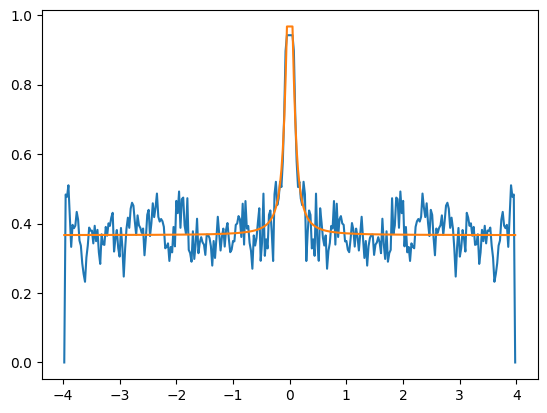

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2758.94it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 3.05508958
    reduced chi-square = 0.01267672
    Akaike info crit   = -1062.80767
    Bayesian info crit = -1052.31617
[[Variables]]
    gamma1:  0.06535713 +/- 0.00706561 (10.81%) (init = 0.2)
    m1:      0.93159993 +/- 0.04727621 (5.07%) (init = 1)
    c:       0.37856913 +/- 0.00472284 (1.25%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9396
    C(gamma1, c)  = -0.3329
    C(m1, c)      = +0.1947
None


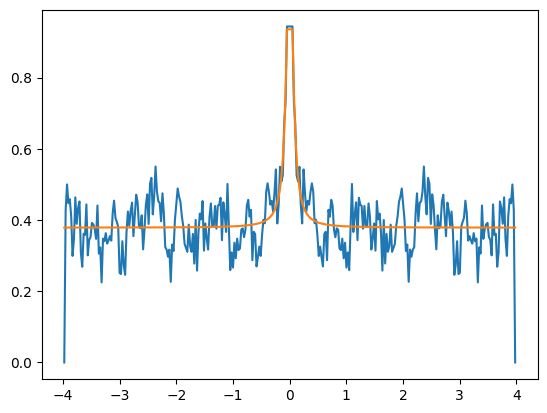

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2772.69it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 244
    # variables        = 3
    chi-square         = 3.14785251
    reduced chi-square = 0.01306163
    Akaike info crit   = -1055.50925
    Bayesian info crit = -1045.01775
[[Variables]]
    gamma1:  0.08162936 +/- 0.00724550 (8.88%) (init = 0.2)
    m1:      0.87124783 +/- 0.03222431 (3.70%) (init = 1)
    c:       0.28226549 +/- 0.00445474 (1.58%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.8949
    C(gamma1, c)  = -0.3433
    C(m1, c)      = +0.1502
None


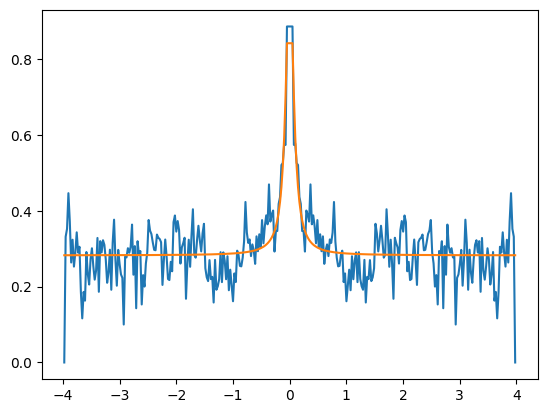

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2785.91it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 244
    # variables        = 3
    chi-square         = 4.23902669
    reduced chi-square = 0.01758932
    Akaike info crit   = -982.891627
    Bayesian info crit = -972.400122
[[Variables]]
    gamma1:  0.05468250 +/- 0.00765627 (14.00%) (init = 0.2)
    m1:      1.02527384 +/- 0.07659772 (7.47%) (init = 1)
    c:       0.30891922 +/- 0.00514223 (1.66%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9643
    C(gamma1, c)  = -0.3185
    C(m1, c)      = +0.2220
None


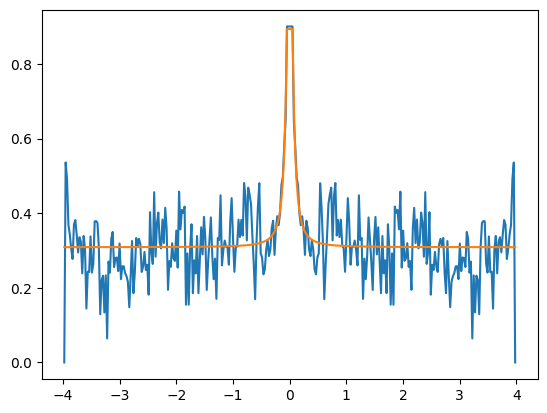

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2941.99it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 244
    # variables        = 3
    chi-square         = 29.3240688
    reduced chi-square = 0.12167663
    Akaike info crit   = -510.977339
    Bayesian info crit = -500.485834
[[Variables]]
    gamma1:  0.04352206 +/- 0.01806851 (41.52%) (init = 0.2)
    m1:      1.23773605 +/- 0.31747277 (25.65%) (init = 1)
    c:       0.27323700 +/- 0.01331587 (4.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.9836
    C(gamma1, c)  = -0.3039
    C(m1, c)      = +0.2442
None


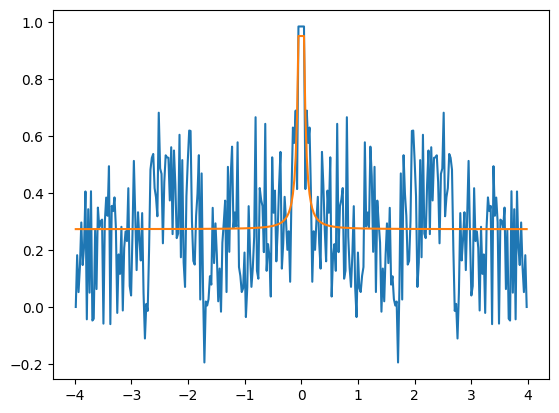

Frequency resolution is 0.02442 MHz


100%|██████████| 163/163 [00:00<00:00, 2851.54it/s]

Could not fit a Lorentzian
err 0.07856742013183861
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 244
    # variables        = 3
    chi-square         = 106.522124
    reduced chi-square = 0.44200052
    Akaike info crit   = -196.230987
    Bayesian info crit = -185.739483
[[Variables]]
    gamma1:  0.10013911 +/- 0.03065276 (30.61%) (init = 0.2)
    m1:      1.06301014 +/- 0.11447001 (10.77%) (init = 1)
    c:       0.19866169 +/- 0.03287009 (16.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1) = -0.8311
    C(gamma1, c)  = -0.3905
    C(m1, c)      = +0.1027
None


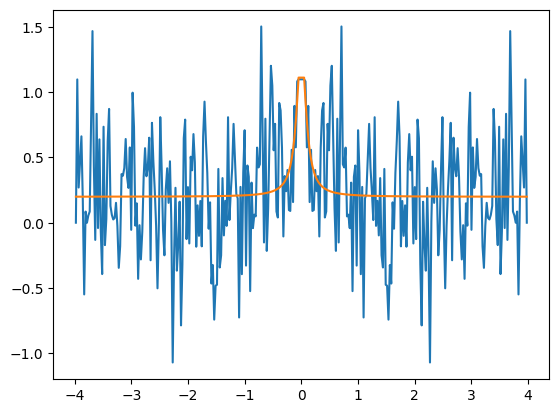

In [14]:
mods=[]
mod_uncert=[]
freq_scale_1=[]
freq_scale_1_uncert=[]
mods_alternative = []
mods_alternative_uncert = []

prof_sn = np.nanmean(I_upchan_corrected,axis=0)
prof_off = prof_sn[:1000]
prof_sn -=np.nanmean(prof_off)
prof_off = prof_sn[:1000]
prof_sn/=np.nanstd(prof_off)


for i in range(1250,1400,4):
    if prof_sn[i-2] > 8:
        spec_upchan = np.nanmean(I_upchan_corrected[:,i-2:i+2],axis=1)
        spec_upchan[np.isnan(spec_upchan)]=0
        spec_upchan=np.ma.masked_where(spec_upchan==0,spec_upchan)
        spec_fake = np.nanmean(I_upchan_corrected[:,1200:1204],axis=1)
        spec_fake[np.isnan(spec_fake)]=0
        spec_fake=np.ma.masked_where(spec_fake==0,spec_fake)
    
        acf_res = acf_scint_plot(spec_upchan,data_dedisp_masked_upchan_ds[2],data_dedisp_masked_upchan_ds[1],[0,0],lagrange_for_fit=0.01,diagnostic_plots=False,maxlag=4,offspec_mean=np.nanmean(spec_fake))
        plt.close()
    
        
        lagrange_for_fit=3
        f_res=0.39101/(fftsize//downfreq)

        acf=acf_res[0]
        lag=acf_res[1]
        acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
        lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
        #compute the ACF correlated errors
        acf_half = acf[len(acf)//2:]
        var_f = np.ones(len(acf_half)) / (len(acf_half))
        var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
        f_errors = np.sqrt(var_f)
        print("err",f_errors[0])
    
        f_errors_full = np.concatenate((f_errors[::-1],f_errors))
        acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
        params = Parameters()
        params.add('gamma1', value = 0.2, min= 0.00001, max = 100)
        params.add('m1', value = 1, min = -100, max = 100)
        params.add('c',value=0,min=-100,max=100)
    
        fit = Minimizer(lorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
        result_acf = fit.minimize()
        print(report_fit(result_acf))
    
        plt.plot(lag,acf)
        plt.plot(lag,lorentz_w_c(lag,result_acf.params['gamma1'],result_acf.params['m1'],result_acf.params['c']))
        plt.show()         
    

        mods.append(result_acf.params['m1'])
        mod_uncert.append(result_acf.params['m1'].stderr)
        freq_scale_1.append(result_acf.params['gamma1'])
        freq_scale_1_uncert.append(result_acf.params['gamma1'].stderr)
        mods_alternative.append(np.sqrt(np.max(acf_fit)-result_acf.params['c']))
        mods_alternative_uncert.append(np.sqrt(np.max(acf_fit)-result_acf.params['c']) * np.sqrt((f_errors[0]/np.max(acf_fit))**2 + (result_acf.params['c'].stderr/result_acf.params['c'])**2)/2.)
            
    else:
        mods.append(0)
        mod_uncert.append(0)
        freq_scale_1.append(0)
        freq_scale_1_uncert.append(0)
        mods_alternative.append(0)
        mods_alternative_uncert.append(0)
   


In [15]:
mod_uncert=np.array(mod_uncert)
mods=np.array(mods)
mods_alternative_uncert=np.array(mods_alternative_uncert)
mods_alternative=np.array(mods_alternative)

mods[np.isnan(mods)]=0
mods[mods==None]=0
mods=np.ma.masked_where(mods==0,mods)

mods_alternative[np.isnan(mods_alternative)]=0
mods_alternative[mods_alternative==None]=0
mods_alternative=np.ma.masked_where(mods_alternative==0,mods_alternative)

mod_uncert[mod_uncert=='nan']=0
mod_uncert[mod_uncert==None]=0
mod_uncert=np.ma.masked_where(mod_uncert==0,mod_uncert)

mods_alternative_uncert[mods_alternative_uncert=='nan']=0
mods_alternative_uncert[mods_alternative_uncert==None]=0
mods_alternative_uncert=np.ma.masked_where(mods_alternative_uncert==0,mods_alternative_uncert)

mod_uncert=np.array([float(x) for x in np.array(mod_uncert)])
mods=np.array([float(x) for x in np.array(mods)])
mods_alternative_uncert=np.array([float(x) for x in np.array(mods_alternative_uncert)])
mods_alternative=np.array([float(x) for x in np.array(mods_alternative)])

freq_scale_1 = np.array(freq_scale_1)
freq_scale_1[np.isnan(freq_scale_1)]=0
freq_scale_1[freq_scale_1==None]=0
freq_scale_1=np.ma.masked_where(freq_scale_1==0,freq_scale_1)
freq_scale_1_uncert = np.array(freq_scale_1_uncert)
freq_scale_1_uncert[freq_scale_1_uncert=='nan']=100
freq_scale_1_uncert[freq_scale_1_uncert==None]=100
freq_scale_1_uncert=np.ma.masked_where(freq_scale_1_uncert==0,freq_scale_1_uncert)


/tmp/ipykernel_72/2429267844.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mod_uncert[mod_uncert=='nan']=0
/tmp/ipykernel_72/2429267844.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mods_alternative_uncert[mods_alternative_uncert=='nan']=0
/tmp/ipykernel_72/2429267844.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  freq_scale_1_uncert[freq_scale_1_uncert=='nan']=100


# PLOT THE DYNAMIC SPECTRUM PLOT
## Extended Data Figure 1 in Nimmo et al. 2024


In [39]:
#downsample in freq
Iscr = scrunch(I_upchan_corrected,tscrunch=1,fscrunch=256)

/arc/projects/chime_frb/knimmo/pa_swing_frb/scint_funcs.py:298: RuntimeWarning: Mean of empty slice
/arc/projects/chime_frb/knimmo/pa_swing_frb/scint_funcs.py:304: RuntimeWarning: Mean of empty slice


In [40]:
#normalise the prof and spec for plotting
prof=np.nanmean(Iscr,axis=0)
offprof = prof[:1000]
prof-=np.nanmean(offprof)
offprof-=np.nanmean(offprof)
prof/=np.nanstd(offprof)

spec_plot = np.nanmean(Iscr[:,beginburst:endburst],axis=1)
offspec = np.nanmean(Iscr[:,:1000],axis=1)

spec_plot-=np.nanmean(offspec)
offspec-=np.nanmean(offspec)
spec_plot/=np.nanstd(offspec)
offspec/=np.nanstd(offspec)

/tmp/ipykernel_72/724159571.py:8: RuntimeWarning: Mean of empty slice
  spec_plot = np.nanmean(Iscr[:,beginburst:endburst],axis=1)
/tmp/ipykernel_72/724159571.py:9: RuntimeWarning: Mean of empty slice
  offspec = np.nanmean(Iscr[:,:1000],axis=1)


In [41]:
mods=mods_alternative
mod_uncert=mods_alternative_uncert

In [58]:
#hardcoding my rise and decay times
rise_begin = 52
first_comp_peak = 65
third_comp_peak = 98
fall_end = 110

modulation index weighted average: 0.7877057816452485+-0.06457673104153519


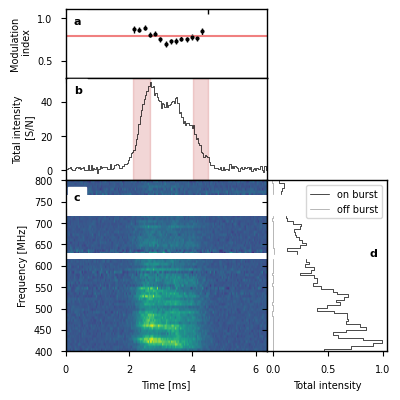

In [59]:
df = 400. / 1024
all_freqs = np.linspace(800., 400., Iscr.shape[0])
rows = 3
cols = 2
fig = plt.figure(figsize=(4,4))

gs = gridspec.GridSpec(ncols=cols, nrows=rows, width_ratios=[1,0.6], height_ratios=[0.4,0.6,1], wspace=0, hspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax1.errorbar(np.linspace((2500-2500)*2.56e-3*4*2*2,(2800//2-2500//2)*2.56e-3*4*2*2,len(mods)),mods,yerr=mod_uncert,marker='o',color='k',linestyle='None',markersize=2,lw=1)
mod_avg = np.average(mods[mods!=0],weights=1./(mod_uncert[mods!=0])**2)
mod_variance = np.average((mods[mods!=0]-mod_avg)**2, weights=1./(mod_uncert[mods!=0])**2)
print("modulation index weighted average:", str(mod_avg)+"+-"+str(np.sqrt(mod_variance)))
ax1.axhline(mod_avg,color='lightcoral')
plt.setp(ax1.get_xticklabels(), visible=False)
t=ax1.text(.04, .9, 'a', ha='left', va='top', transform=ax1.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
ax2.axvspan(rise_begin*2.56e-3*4*2*2,first_comp_peak*2.56e-3*4*2*2,color='indianred',alpha=0.25)
ax2.axvspan(third_comp_peak*2.56e-3*4*2*2,fall_end*2.56e-3*4*2*2,color='indianred',alpha=0.25)
ax2.plot(np.linspace(-1250*2.56e-3*4*2*2,(Iscr.shape[1]-1250)*2.56e-3*4*2*2,Iscr.shape[1]),prof,color='k',drawstyle='steps-mid',lw=0.5)
plt.setp(ax2.get_xticklabels(), visible=False)
t=ax2.text(.04, .93, 'b', ha='left', va='top', transform=ax2.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax3 = fig.add_subplot(gs[2,0],sharex=ax2)
ax3.imshow(Iscr,aspect='auto',extent=[-1250*2.56e-3*4*2*2,(Iscr.shape[1]-1250)*2.56e-3*4*2*2,all_freqs[-1]- df/2., all_freqs[0]+ df/2.])
t=ax3.text(.04, .93, 'c', ha='left', va='top', transform=ax3.transAxes, fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))


ax4 = fig.add_subplot(gs[2,1],sharey=ax3)
ax4.plot(spec_plot/np.nanmax(spec_plot),all_freqs,color='k',drawstyle='steps-mid',label='on burst',lw=0.5)
ax4.plot(offspec/np.nanmax(spec_plot),all_freqs,color='k',alpha=0.4,drawstyle='steps-mid',label='off burst',lw=0.5)
ax4.legend(loc='upper right')
plt.setp(ax4.get_yticklabels(), visible=False)
t=ax4.text(.85, .6, 'd', ha='left', va='top', transform=ax4.transAxes, fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax1.set_xlim(0,155*2.56e-3*16)
ax1.set_ylim(0.3,1.1)
ax3.set_ylim(400,800)
ax1.set_ylabel('Modulation\n index')
ax2.set_ylabel('Total intensity\n [S/N]')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel('Frequency [MHz]')
ax4.set_xlabel('Total intensity')

fig.tight_layout(pad=1)
plt.savefig('./PA_swing_burst_ds.final.jpg',format='jpg',dpi=300)
plt.show()

In [48]:
# a,b,c has to be 8pt bold
# extended data figures - max text size 7pt - color scheme RGB - jpg
# regular figures 8pt text. 89mm, 120mm or 183mm in width. RGB color. pdf format.

# Extended Data Figure 2 in Nimmo et al. 2024

(20000.0, 23000.0)

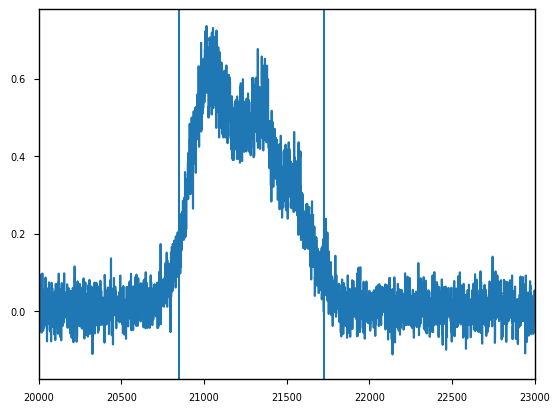

In [62]:
#no upchannelisation
plt.plot(np.nanmean(I_corrected,axis=0), drawstyle='steps-mid')
st_tbin = 20848
end_tbin = 21725
lim=np.array([st_tbin, end_tbin])
plt.axvline(lim[0])
plt.axvline(lim[1])
plt.xlim(20000,23000)

In [63]:
#no upchannelisation
spec = np.nanmean(I_corrected[:,lim[0]:lim[1]],axis=1)
offspec=np.nanmean(I_corrected[:,0:15000],axis=1)

/tmp/ipykernel_72/2184711568.py:2: RuntimeWarning: Mean of empty slice
  spec = np.nanmean(I_corrected[:,lim[0]:lim[1]],axis=1)
/tmp/ipykernel_72/2184711568.py:3: RuntimeWarning: Mean of empty slice
  offspec=np.nanmean(I_corrected[:,0:15000],axis=1)


In [69]:
#upchan
fftsize=512
downfreq=1
data_dedisp_masked_upchan_512 = upchan(data,freqid,fftsize=fftsize,downfreq=downfreq)
#upchannel the noise to model the scalloping
noise_dedisp_masked_upchan_512 = upchan(data_off,freqid,fftsize=fftsize,downfreq=downfreq)

model_512, inds_512 = make_scallop_model(noise_dedisp_masked_upchan_512[0], fftsize, downfreq)

(35.0, 45.0)

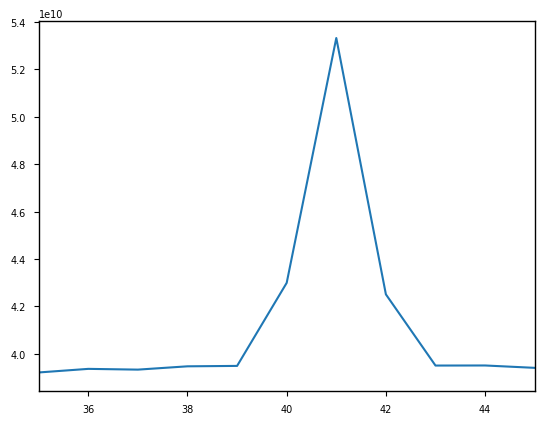

In [70]:
power_512 = np.abs(data_dedisp_masked_upchan_512[0]**2)
I_512 = np.sum(power_512,axis=0).T
plt.close('all')
plt.plot(np.nanmean(I_512,axis=0))
plt.xlim(35,45)

In [71]:
burst_peak_512 = 41

In [72]:
#uncorrected upchan
spec_upchan=np.nanmean(I_512[:,burst_peak_512:burst_peak_512+1],axis=1)
spec_upchan[np.isnan(spec_upchan)]=0
spec_upchan[inds_512]=0
spec_upchan=np.ma.masked_where(spec_upchan==0,spec_upchan)

spec_fake_upchan = np.nanmean(I_512[:,0:20],axis=1)
spec_fake_upchan[np.isnan(spec_fake_upchan)]=0
#spec_fake_upchan[inds_512]=0
spec_fake_upchan=np.ma.masked_where(spec_fake_upchan==0,spec_fake_upchan)

In [73]:
#per channel I want to remove the scalloping and normalise using off burst data
I_512upchan_corrected = np.zeros_like(I_512)
for time_bin in range(I_512.shape[1]):
    I_512upchan_corrected[:,time_bin] = I_512[:,time_bin]/model_512
    
    
for freq_chan in range(I_512upchan_corrected.shape[0]):
    Ioff=I_512upchan_corrected[freq_chan,:30]
    I_512upchan_corrected[freq_chan,:] = I_512upchan_corrected[freq_chan,:] - np.nanmean(Ioff)
    Ioff-=np.nanmean(Ioff)
    I_512upchan_corrected[freq_chan,:] = I_512upchan_corrected[freq_chan,:] / np.nanstd(Ioff)
    

In [74]:
spec_upchan_corr=np.nanmean(I_512upchan_corrected[:,41:42],axis=1)
spec_upchan_corr[np.isnan(spec_upchan_corr)]=0
spec_upchan_corr[inds_512]=0
spec_upchan_corr=np.ma.masked_where(spec_upchan_corr==0,spec_upchan_corr)

spec_fake_upchan_corr = np.nanmean(I_512upchan_corrected[:,0:5],axis=1)
spec_fake_upchan_corr[np.isnan(spec_fake_upchan_corr)]=0
spec_fake_upchan_corr[inds_512]=0
spec_fake_upchan_corr=np.ma.masked_where(spec_fake_upchan_corr==0,spec_fake_upchan_corr)

calib_off=spec_fake_upchan_corr-np.nanmean(spec_fake_upchan_corr)
calib_off/=np.std(calib_off)
newinds=np.where(np.abs(calib_off)>3)[0]


/tmp/ipykernel_72/3500213548.py:1: RuntimeWarning: Mean of empty slice
  spec_upchan_corr=np.nanmean(I_512upchan_corrected[:,41:42],axis=1)
/tmp/ipykernel_72/3500213548.py:6: RuntimeWarning: Mean of empty slice
  spec_fake_upchan_corr = np.nanmean(I_512upchan_corrected[:,0:5],axis=1)


/tmp/ipykernel_72/3653790635.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


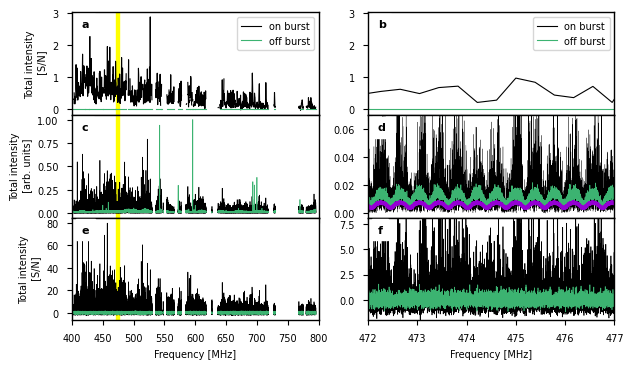

In [76]:
rows = 3
cols = 2
fig = plt.figure(figsize=(7,4))
gs = gridspec.GridSpec(ncols=cols, nrows=rows, width_ratios=[1,1], height_ratios=[1,1,1], wspace=0.2, hspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(freq,spec,color='k',lw=0.8,label='on burst')
ax1.plot(freq,offspec,color='mediumseagreen',alpha=1,lw=0.8, label='off burst')
ax1.set_xlim(400,800)
ax1.legend()
ax1.set_ylabel('Total intensity\n [S/N]')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.axvspan(472,477,color='yellow')
t=ax1.text(.04, .93, 'a', ha='left', va='top', transform=ax1.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax2 = fig.add_subplot(gs[1,0],sharex=ax1)
ax2.plot(data_dedisp_masked_upchan_512[1],spec_upchan/np.max(spec_fake_upchan),color='k',lw=0.5,label='on burst')
ax2.plot(data_dedisp_masked_upchan_512[1],spec_fake_upchan/np.max(spec_fake_upchan),color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax2.set_ylabel('Total intensity\n [arb. units]')
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.axvspan(472,477,color='yellow')
t=ax2.text(.04, .93, 'c', ha='left', va='top', transform=ax2.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax3 = fig.add_subplot(gs[2,0],sharex=ax2)
ax3.plot(data_dedisp_masked_upchan_512[1],spec_upchan_corr,color='k',lw=0.5,label='on burst')
ax3.plot(data_dedisp_masked_upchan_512[1],spec_fake_upchan_corr,color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax3.set_ylabel('Total intensity\n [S/N]')
ax3.axvspan(472,477,color='yellow')

ax3.set_xlabel('Frequency [MHz]')

t=ax3.text(.04, .93, 'e', ha='left', va='top', transform=ax3.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax4 = fig.add_subplot(gs[0,1])
ax4.plot(freq,spec,color='k',lw=0.8,label='on burst')
ax4.plot(freq,offspec,color='mediumseagreen',alpha=1,lw=0.8, label='off burst')
ax4.set_xlim(472,477)
ax4.legend()
plt.setp(ax4.get_xticklabels(), visible=False)
t=ax4.text(.04, .93, 'b', ha='left', va='top', transform=ax4.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax5 = fig.add_subplot(gs[1,1],sharex=ax4)
ax5.plot(data_dedisp_masked_upchan_512[1],spec_upchan/np.max(spec_fake_upchan),color='k',lw=0.2,label='on burst')
ax5.plot(data_dedisp_masked_upchan_512[1],spec_fake_upchan/np.max(spec_fake_upchan),color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax5.plot(data_dedisp_masked_upchan_512[1],model_512/np.max(spec_fake_upchan),color='darkviolet',alpha=1,lw=3, label='scallop model')
ax5.set_ylim(-0.003,0.07)
plt.setp(ax5.get_xticklabels(), visible=False)
t=ax5.text(.04, .93, 'd', ha='left', va='top', transform=ax5.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

ax6 = fig.add_subplot(gs[2,1],sharex=ax5)
ax6.plot(data_dedisp_masked_upchan_512[1],spec_upchan_corr,color='k',lw=0.5,label='on burst')
ax6.plot(data_dedisp_masked_upchan_512[1],spec_fake_upchan_corr,color='mediumseagreen',alpha=1,lw=0.5, label='off burst')
ax6.set_ylim(-2,8.1)


ax6.set_xlabel('Frequency [MHz]')
t=ax6.text(.04, .93, 'f', ha='left', va='top', transform=ax6.transAxes,fontsize=8,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))

fig.tight_layout(pad=1)
plt.savefig('./spectrum_pa_swing.final.jpg',format='jpg',dpi=300)


plt.show()

# Now let's do the autocorrelation function of the upchan 512 burst spectrum

In [77]:
#let's do some additional flagging determined by making ACFs of the off burst data

spec_fake_upchan_corr[newinds]=0
spec_upchan_corr[newinds]=0

#flagging visibly bad frequency ranges
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-501.76))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-501.76))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-504.88))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-504.88))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-492.38))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-492.38))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-643.75))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-643.75))+4096]=0
spec_fake_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-602.35))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-602.35))+4096]=0

spec_fake_upchan_corr=np.ma.masked_where(spec_fake_upchan_corr==0,spec_fake_upchan_corr)


spec_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-501.76))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-501.76))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-504.88))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-504.88))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-492.38))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-492.38))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-643.75))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-643.75))+4096]=0
spec_upchan_corr[np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-602.35))-4096:np.argmin(np.abs(noise_dedisp_masked_upchan_512[1]-602.35))+4096]=0

spec_upchan_corr=np.ma.masked_where(spec_upchan_corr==0,spec_upchan_corr)


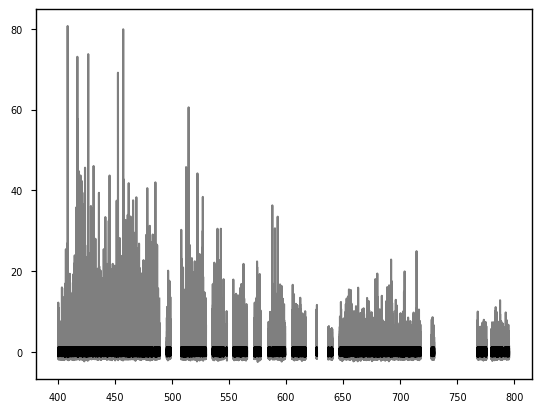

In [79]:
plt.plot(data_dedisp_masked_upchan_512[1],spec_upchan_corr,color='k',alpha=0.5)
plt.plot(data_dedisp_masked_upchan_512[1],spec_fake_upchan_corr,color='k')

In [81]:
acf_res = acf_scint_plot(spec_upchan_corr,data_dedisp_masked_upchan_512[2],data_dedisp_masked_upchan_512[1],[0,0],lagrange_for_fit=0.01,diagnostic_plots=False,maxlag=20,offspec_mean=(np.nanmean(spec_fake_upchan_corr)))


Frequency resolution is 0.00076 MHz


100%|██████████| 26214/26214 [08:43<00:00, 50.05it/s]

Could not fit a Lorentzian



/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


In [83]:
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'sans-serif'                                                                                                                           
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['xtick.major.pad']='6'
mpl.rcParams['ytick.major.pad']='6'

/tmp/ipykernel_72/3887596965.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 52246
    # variables        = 6
    chi-square         = 457.357086
    reduced chi-square = 0.00875492
    Akaike info crit   = -247542.827
    Bayesian info crit = -247489.644
[[Variables]]
    gamma1:  0.00303107 +/- 4.3149e-05 (1.42%) (init = 0.02)
    m1:      1.28191277 +/- 0.00447080 (0.35%) (init = 1)
    gamma2:  0.05361600 +/- 4.3160e-04 (0.80%) (init = 0.2)
    m2:      0.88494920 +/- 0.00280121 (0.32%) (init = 1)
    gamma3:  27.2739629 +/- 0.10627129 (0.39%) (init = 2)
    m3:      0.57913796 +/- 2.7986e-04 (0.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma2, m2)     = -0.7925
    C(gamma1, m1)     = -0.6994
    C(gamma3, m3)     = -0.6550
    C(gamma1, m2)     = -0.6543
    C(gamma1, gamma2) = +0.4823
    C(gamma2, m3)     = -0.2050
    C(gamma2, gamma3) = +0.1334
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # functio

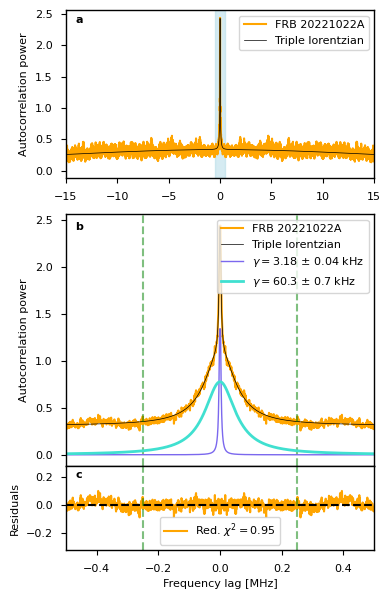

In [90]:
fig = plt.figure(figsize=(3.50394,6)) #89mm in width for Nature guidelines

gs = gridspec.GridSpec(ncols=1, nrows=1, top=0.94, bottom=0.66, left=0.09,right=0.97, width_ratios=[1], height_ratios=[1], wspace=0, hspace=0)
gs1 = gridspec.GridSpec(ncols=1, nrows=2, top=0.6, bottom=0.04, left=0.09,right=0.97,width_ratios=[1], height_ratios=[3,1], wspace=0, hspace=0)

cmap = matplotlib.cm.get_cmap('plasma')
lagrange_for_fit=19.95
f_res=0.39101/(fftsize//downfreq)

acf=acf_res[0]
lag=acf_res[1]
acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]

#compute the ACF errors
acf_half = acf[len(acf)//2:]
var_f = np.ones(len(acf_half)) / (len(acf_half))
var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
f_errors = np.sqrt(var_f)
    
f_errors_full = np.concatenate((f_errors[::-1],f_errors))
acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
        

ax1 = fig.add_subplot(gs[0,0])
ax1.set_ylabel('Autocorrelation power')
ax1.axvspan(-0.5,0.5,color='lightblue',alpha=0.5)
ax1.plot(acf_res[1],acf_res[0],color='orange',label='FRB 20221022A')


params = Parameters()
params.add('gamma1', value = 0.02, min= 0.00001, max = 100)
params.add('m1', value = 1, min = -100, max = 100)
params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
params.add('m2', value = 1, min = -100, max = 100)
params.add('gamma3', value = 2, min= 0.00001, max = 100)
params.add('m3', value = 1, min = -100, max = 100)
        
    
fit = Minimizer(triplelorentz_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
result_fullacf = fit.minimize()
print(report_fit(result_fullacf))
        
ax1.plot(lag,triplelorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3']),color='k',linewidth=0.5,label='Triple lorentzian')
ax1.set_xlim(-15,15)
ax1.legend()
ax1.text(.03, .97, 'a', ha='left', va='top', transform=ax1.transAxes,fontweight='bold')

lagrange_for_fit=0.5
f_res=0.39101/(fftsize//downfreq)

acf=acf_res[0]
lag=acf_res[1]
acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]

#compute the ACF errors
acf_half = acf[len(acf)//2:]
var_f = np.ones(len(acf_half)) / (len(acf_half))
var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
f_errors = np.sqrt(var_f)
    
f_errors_full = np.concatenate((f_errors[::-1],f_errors))
acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]


params = Parameters()
params.add('gamma1', value = 0.02, min= 0.00001, max = 100)
params.add('m1', value = 1, min = -100, max = 100)
params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
params.add('m2', value = 1, min = -100, max = 100)
params.add('gamma3', value = 20, min= 0.00001, max = 100)
params.add('m3', value = 1, min = -100, max = 100)
        
    
fit = Minimizer(triplelorentz_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
result_fullacf = fit.minimize()
print(report_fit(result_fullacf))




ax2 = fig.add_subplot(gs1[0,0])
ax2.set_ylabel('Autocorrelation power')
ax2.plot(acf_res[1],acf_res[0],color='orange',label='FRB 20221022A')
ax2.plot(lag,triplelorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3']),color='k',linewidth=0.5,label='Triple lorentzian')
ax2.axvline(-0.25,color='green',linestyle='--',alpha=0.5)
ax2.axvline(0.25,color='green',linestyle='--',alpha=0.5)
ax2.set_xlim(-0.5,0.5)
ax2.plot(lag,lorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1']),color='mediumslateblue',lw=1,label=r'$\gamma = $%.2f $\pm$ %.2f kHz'%(result_fullacf.params['gamma1']*1000, (result_fullacf.params['gamma1'].stderr)*1000))
ax2.plot(lag,lorentz(lag,result_fullacf.params['gamma2'],result_fullacf.params['m2']),color='turquoise',lw=2,label=r'$\gamma = $%.1f $\pm$ %.1f kHz'%(result_fullacf.params['gamma2']*1000, (result_fullacf.params['gamma2'].stderr)*1000))
ax2.legend(loc='upper right')
ax2.text(.03, .97, 'b', ha='left', va='top', transform=ax2.transAxes,fontweight='bold')

lagrange_for_stat = 0.25
acf_stat = acf[int(len(acf)/2.)-int(lagrange_for_stat/f_res):int(len(acf)/2.)+int(lagrange_for_stat/f_res)]
lag_stat=lag[int(len(acf)/2.)-int(lagrange_for_stat/f_res):int(len(acf)/2.)+int(lagrange_for_stat/f_res)]
dof = len(acf_stat)-4
E = triplelorentz(lag_stat,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3'])
instrip_m = result_fullacf.params['m3']
instrip_gamma = result_fullacf.params['gamma3']
acf_highlag = acf[int(len(acf)/2.)+int(0.4/f_res):int(len(acf)/2.)+int(0.5/f_res)] - instrip_m**2 / (1+(lag[int(len(acf)/2.)+int(0.4/f_res):int(len(acf)/2.)+int(0.5/f_res)]/instrip_gamma)**2)
chisq_k = np.sum((acf_stat-E)**2 * 1/np.var(acf_highlag))
redchisq=chisq_k/dof
print("chisq",chisq_k)
print("reduced chisq",redchisq)


ax3 = fig.add_subplot(gs1[1,0],sharex=ax2)
ax3.set_ylabel('Residuals')
ax3.set_xlabel('Frequency lag [MHz]')
ax3.plot(lag,acf_res[0]-triplelorentz(lag,result_fullacf.params['gamma1'],result_fullacf.params['m1'],result_fullacf.params['gamma2'],result_fullacf.params['m2'],result_fullacf.params['gamma3'],result_fullacf.params['m3']),color='orange',label=r'Red. $\chi^2 = $%.2f'%redchisq)
ax3.axhline(0,color='k',linestyle='--')
ax3.legend(loc='lower center')
ax3.axvline(-0.25,color='green',linestyle='--',alpha=0.5)
ax3.axvline(0.25,color='green',linestyle='--',alpha=0.5)
ax3.set_xlim(-0.5,0.5)
ax3.text(.03, .96, 'c', ha='left', va='top', transform=ax3.transAxes,fontweight='bold',fontsize=8)
#fig.tight_layout(pad=3)

plt.savefig('./entire_band_ACF_FRB20221022A.final.pdf',format='pdf',dpi=300,bbox_inches="tight")





# ACF per subband

beg,end 0 181995
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:17<00:00, 299.73it/s]


Could not fit a Lorentzian
beg,end 181995 297685
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:11<00:00, 454.16it/s]


Could not fit a Lorentzian
beg,end 297685 363285
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:06<00:00, 774.70it/s]


Could not fit a Lorentzian
beg,end 363285 417014
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:05<00:00, 929.70it/s]


Could not fit a Lorentzian
beg,end 417014 445766
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:03<00:00, 1689.02it/s]


Could not fit a Lorentzian
beg,end 445766 471781
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:02<00:00, 1826.83it/s]


Could not fit a Lorentzian
beg,end 471781 495622
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:02<00:00, 2004.95it/s]


Could not fit a Lorentzian
beg,end 495622 524207
Frequency resolution is 0.00076 MHz


100%|██████████| 5242/5242 [00:03<00:00, 1699.93it/s]


Could not fit a Lorentzian


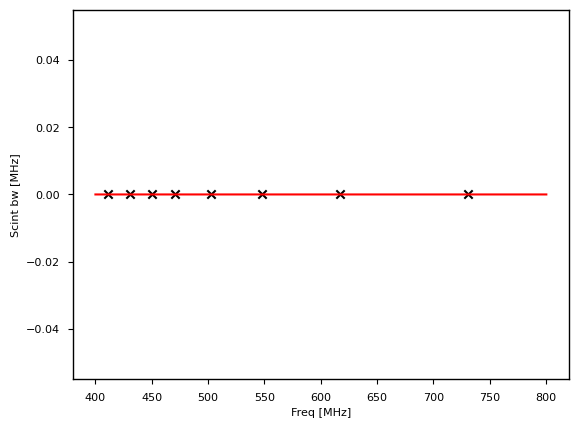

In [94]:
acfs,fcents,lags, subsn, submask,spec_lens=acf_per_subband(spec_upchan_corr,data_dedisp_masked_upchan_512[1],data_dedisp_masked_upchan_512[2],num_subbands=8,plot_fit=True,maxlag=4,offspec=spec_fake_upchan_corr,snsubband=True)


/tmp/ipykernel_72/4246270245.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 272
    # data points      = 784
    # variables        = 5
    chi-square         = 49.9181401
    reduced chi-square = 0.06407977
    Akaike info crit   = -2149.15525
    Bayesian info crit = -2125.83321
[[Variables]]
    gamma1:  2.0187e-04 +/- 8.7768e-04 (434.77%) (init = 0.002)
    m1:      7.01327249 +/- 30.1817956 (430.35%) (init = 1)
    gamma2:  0.03336212 +/- 0.00134674 (4.04%) (init = 0.2)
    m2:      0.81261515 +/- 0.01018804 (1.25%) (init = 1)
    c:       0.15123168 +/- 0.00454001 (3.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1)     = -1.0000
    C(gamma2, m2)     = -0.6472
    C(gamma1, m2)     = -0.6125
    C(m1, m2)         = +0.6108
    C(gamma2, c)      = -0.5673
    C(gamma1, gamma2) = +0.4477
    C(m1, gamma2)     = -0.4462
    C(gamma1, c)      = -0.1473
    C(m1, c)          = +0.1468
None
[[Fit Statistics]]
    # fitting method   = leastsq
   

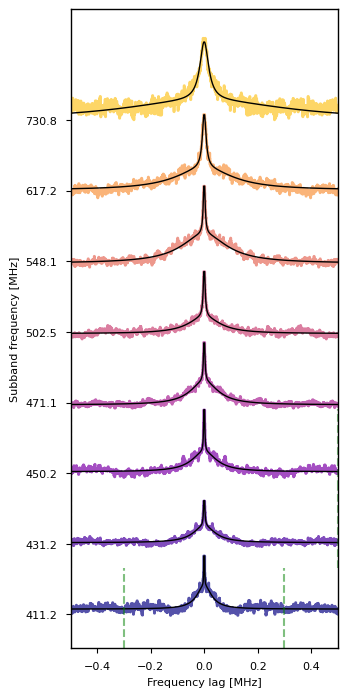

In [96]:
#doublelorentz
fig = plt.figure(figsize=(3.5,7))

cmap = matplotlib.cm.get_cmap('plasma')
lagrange_for_fits=[0.3,0.5,0.5,0.6,0.6,0.7,0.7,3]
f_res=0.39101/(fftsize//downfreq)
sub_scint=[]
sub_scint_uncert=[]
sub_scint2=[]
sub_scint_uncert2=[]
f_cents=[]

plt.xlabel('Frequency lag [MHz]')
plt.ylabel('Subband frequency [MHz]')
acfs_offset=[]
mods1=[]
mods1_uncert=[]
mods2=[]
mods2_uncert=[]
for i in range(len(fcents)):
    lagrange_for_fit=lagrange_for_fits[i]
    rgba = cmap(i/len(fcents))
    acf=acfs[len(fcents)-i-1]
    lag=lags[len(fcents)-i-1]
    acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    plt.plot(lags[len(fcents)-i-1],acfs[len(fcents)-i-1]+(2.0*i),drawstyle='steps-mid',color=rgba,linewidth=2,alpha=0.7,label='%.2f MHz'%fcents[len(fcents)-i-1])
    
    #compute the ACF errors
    acf_half = acf[len(acf)//2:]
    var_f = np.ones(len(acf_half)) / (len(acf_half))
    var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
    f_errors = np.sqrt(var_f)
    
    f_errors_full = np.concatenate((f_errors[::-1],f_errors))
    acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
    
    fit=True
    try:
        params = Parameters()
        params.add('gamma1', value = 0.002, min= 0.00001, max = 100)
        params.add('m1', value = 1, min = -100, max = 100)
        params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
        params.add('m2', value = 1, min = -100, max = 100)
        params.add('c', value = 0, min = -100, max = 100)
        
    
        fit_min = Minimizer(doublelorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
        result_subacf = fit_min.minimize()
        print(report_fit(result_subacf))
    except:
        print('could not fit')
        fit=False
    
    
        
    if fit==True:
        plt.plot(lags[len(fcents)-i-1],doublelorentz_w_c(lags[len(fcents)-i-1],result_subacf.params['gamma1'],result_subacf.params['m1'],result_subacf.params['gamma2'],result_subacf.params['m2'],result_subacf.params['c'])+(2.0*i),color='k',linewidth=1)
        
        scints=np.array([np.abs(result_subacf.params['gamma1']),np.abs(result_subacf.params['gamma2'])])
        modinds=np.array([np.abs(result_subacf.params['m1']),np.abs(result_subacf.params['m2'])])
        inds=np.argsort(scints)
        scints=scints[inds]
        modinds=modinds[inds]
        sub_scint.append(scints[0])
        sub_scint2.append(scints[1])
        mods1.append(modinds[0])
        mods2.append(modinds[1])
        errs = np.array([np.abs(result_subacf.params['gamma1'].stderr),np.abs(result_subacf.params['gamma2'].stderr)])
        errs=errs[inds]
        sub_scint_uncert.append(errs[0])
        sub_scint_uncert2.append(errs[1])
        moderrs = np.array([np.abs(result_subacf.params['m1'].stderr),np.abs(result_subacf.params['m2'].stderr)])
        moderrs=moderrs[inds]
        mods1_uncert.append(moderrs[0])
        mods2_uncert.append(moderrs[1])
    else:
        sub_scint.append(0)
        sub_scint_uncert.append(0)
        sub_scint2.append(0)
        sub_scint_uncert2.append(0) 
        
    acfs_offset.append(acfs[len(fcents)-i-1]+(2.0*i))
        
    f_cents.append(fcents[len(fcents)-i-1])

    plt.axvline(lagrange_for_fit,ymin=0+(0.125*i),ymax=0+(0.125*i)+0.125,color='green',linestyle='--',alpha=0.5)
    plt.axvline(-1*lagrange_for_fit,ymin=0+(0.125*i),ymax=0+(0.125*i)+0.125,color='green',linestyle='--', alpha=0.5)
    

plt.yticks([x[0] for x in acfs_offset],['%.1f'%x for x in np.flip(fcents)])

plt.xlim(-0.5,0.5)
fig.tight_layout(pad=1)


In [97]:
# #additional uncertainty from the low number of scintles (1/sqrt(N) where N is the approximate number of scintles)

good_chans=np.array(spec_lens)-np.array(submask)
N2 = 1 + 0.2*((np.flip(good_chans)*f_res) / sub_scint2)
add_un2 = sub_scint2/(2*np.sqrt(N2))

good_chans=np.array(spec_lens)-np.array(submask)
N = 1 + 0.2*((np.flip(good_chans)*f_res) / sub_scint)
add_un = sub_scint/(2*np.sqrt(N))


In [101]:
weighted_avg_and_std(np.array(mods2), np.sqrt(np.array(mods2_uncert)**2 + add_un2**2))

(0.7725864109335338, 0.058429865537328436)

In [106]:
def two_screen_resolved(freq,d2,d12):
    scint_bws_1 = (freq/600)**3.2 * 128e3 #hardcoded scintillation scales
    scint_bws_2 = (freq/600)**3.7 * 6e3 #hardcoded scintillation scales
    bracket = (freq*1e6/d12)**2 * (2*d2)/ (scint_bws_1*scint_bws_2)
    second_sqrt = 1+(4*bracket)
    return 1/np.sqrt(second_sqrt)


def two_screen_resolved_min(params,freq,y,err):
    d2=params['d2'].value
    d12=params['d12'].value
    scint_bws_1 = (freq/600)**3.2 * 128e3 #hardcoded scintillation scales
    scint_bws_2 = (freq/600)**3.7 * 6e3 #hardcoded scintillation scales

    bracket = (freq*1e6/d12)**2 * (2*d2)/ (scint_bws_1*scint_bws_2)
    second_sqrt = 1+(4*bracket)
    modulo =  1/np.sqrt(second_sqrt)
    
    return (modulo - y)/err

def emission_resolved(freq,emission_size,distance_ext_lens):
    distance_ext_lens *= 3.086e19 #provide in kpc --> change to m
    emission_size *=1e3 #provide in km --> change to m
    scint_bws = (freq/600)**3.2 * 128e3
    chi_s2 = 1/(freq*1e6) * np.sqrt((scipy.constants.c * distance_ext_lens * scint_bws)/(2*np.pi))
    second_sqrt = 1+(4*(emission_size/chi_s2)**2)
    return 1/np.sqrt(second_sqrt)


def emission_resolved_min(params,freq,y,err):
    distance_ext_lens = params['distance_ext_lens'].value * 3.086e19
    emission_size = params['emission_size'].value * 1e3
    scint_bws = (freq/600)**3.2 * 128e3
    chi_s2 = 1/(freq*1e6) * np.sqrt((scipy.constants.c * distance_ext_lens * scint_bws)/(2*np.pi))
    second_sqrt = 1+(4*(emission_size/chi_s2)**2)
    modulo =  1/np.sqrt(second_sqrt)
    return (modulo - y)/err

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 7
    # variables        = 2
    chi-square         = 483.378884
    reduced chi-square = 96.6757769
    Akaike info crit   = 33.6442345
    Bayesian info crit = 33.5360548
[[Variables]]
    emission_size:      2362.62864 +/- 161279.703 (6826.28%) (init = 1000)
    distance_ext_lens:  0.08691094 +/- 11.9171956 (13711.96%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(emission_size, distance_ext_lens) = +1.0000
None


Text(0, 0.5, 'Modulation index')

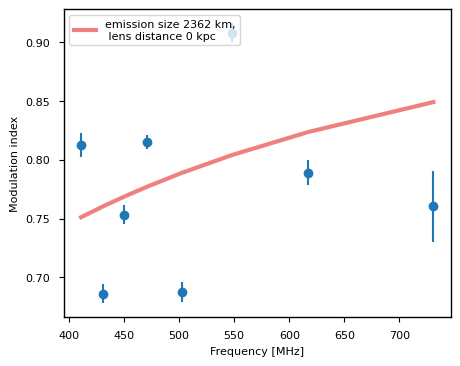

In [108]:
params = Parameters()
params.add('emission_size', value = 1e3, min= 1, max = 1e10)
params.add('distance_ext_lens', value = 1, min = 0.001, max = 500)

fit = Minimizer(emission_resolved_min, params, fcn_args=(np.array(f_cents[0:-1]),mods2[0:-1],np.sqrt(np.array(mods2_uncert[0:-1])**2 + add_un2[0:-1]**2)))
result_resem = fit.minimize()
print(report_fit(result_resem))

fig = plt.figure(figsize=[5,4])
plt.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o')
plt.plot(f_cents,emission_resolved(np.array(f_cents),result_resem.params['emission_size'],result_resem.params['distance_ext_lens']),color='lightcoral',lw=3,label='emission size %d km,\n lens distance %d kpc'%(result_resem.params['emission_size'],result_resem.params['distance_ext_lens']))
plt.legend(loc='upper left')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Modulation index')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 7
    # variables        = 2
    chi-square         = 695.205640
    reduced chi-square = 139.041128
    Akaike info crit   = 36.1880828
    Bayesian info crit = 36.0799031
[[Variables]]
    d2:   0.09473797 +/- 0.46840114 (494.42%) (init = 10000)
    d12:  42371.7653 +/- 17553.0735 (41.43%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(d2, d12) = +0.9558
None


Text(0, 0.5, 'Modulation index')

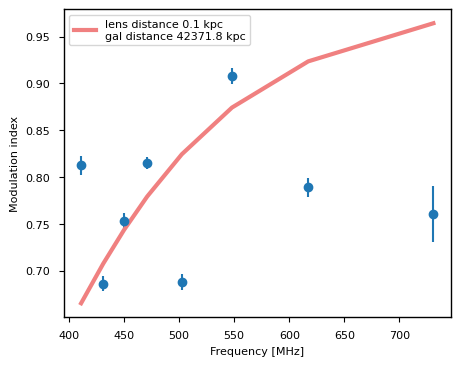

In [109]:
params = Parameters()
params.add('d2', value = 10000, min = 0.0000001, max = 50000000)
params.add('d12', value = 10e3, min = 0.1, max =65.189e3 )

fit = Minimizer(two_screen_resolved_min, params, fcn_args=(np.array(f_cents)[0:-1],mods2[0:-1],np.sqrt(np.array(mods2_uncert[0:-1])**2 + add_un2[0:-1]**2)))
result_ressc = fit.minimize()
print(report_fit(result_ressc))

fig = plt.figure(figsize=[5,4])
plt.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o')
plt.plot(f_cents,two_screen_resolved(np.array(f_cents),result_ressc.params['d2'],result_ressc.params['d12']),color='lightcoral',lw=3,label='lens distance %.1f kpc\ngal distance %.1f kpc'%(result_ressc.params['d2'],result_ressc.params['d12']))#label='d1*d2 = %d kpc^2'%(result.params['d1d2']))
plt.legend(loc='upper left')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Modulation index')

# Let's make Figure 2 in Nimmo et al. 2024

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 265
    # data points      = 784
    # variables        = 5
    chi-square         = 49.9181402
    reduced chi-square = 0.06407977
    Akaike info crit   = -2149.15525
    Bayesian info crit = -2125.83320
[[Variables]]
    gamma1:  2.0216e-04 +/- 8.7645e-04 (433.55%) (init = 0.02)
    m1:      7.00386904 +/- 30.0551768 (429.12%) (init = 1)
    gamma2:  0.03336224 +/- 0.00134675 (4.04%) (init = 0.2)
    m2:      0.81261325 +/- 0.01018811 (1.25%) (init = 1)
    c:       0.15123164 +/- 0.00454002 (3.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, m1)     = -1.0000
    C(gamma2, m2)     = -0.6472
    C(gamma1, m2)     = -0.6125
    C(m1, m2)         = +0.6108
    C(gamma2, c)      = -0.5673
    C(gamma1, gamma2) = +0.4477
    C(m1, gamma2)     = -0.4462
    C(gamma1, c)      = -0.1473
    C(m1, c)          = +0.1468
None
[[Fit Statistics]]
    # fitting method   = leastsq
    

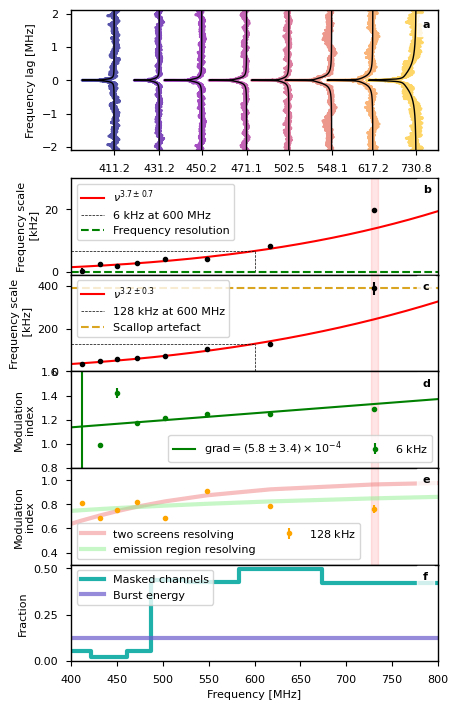

In [116]:
fig = plt.figure(figsize=(4.72441,7)) #120mm width

gs1 = gridspec.GridSpec(ncols=1, nrows=1, top=0.97, bottom=0.77, width_ratios=[1], height_ratios=[1], wspace=0, hspace=0)
gs = gridspec.GridSpec(ncols=1, nrows=5, top=0.73, bottom=0.04, width_ratios=[1], height_ratios=[1,1,1,1,1], wspace=0, hspace=0)

ax1 = fig.add_subplot(gs1[0,0]) 

lagranges_for_fit=[0.3,0.5,0.5,0.6,0.6,0.7,0.7,3]
f_res=0.39101/(fftsize//downfreq)
sub_scint=[]
sub_scint_uncert=[]
sub_scint2=[]
sub_scint_uncert2=[]
f_cents=[]
acfs_offset=[]
mods1=[]
mods1_uncert=[]
mods2=[]
mods2_uncert=[]
for i in range(len(fcents)):
    lagrange_for_fit=lagranges_for_fit[i]
    rgba = cmap(i/len(fcents))
    acf=acfs[len(fcents)-i-1]
    lag=lags[len(fcents)-i-1]
    acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    ax1.plot(-1*acfs[len(fcents)-i-1]+(2.0*i),lags[len(fcents)-i-1],drawstyle='steps-mid',color=rgba,linewidth=2,alpha=0.7)#,label='%.2f MHz'%fcents[len(fcents)-i-1])
    
    #compute the ACF errors
    acf_half = acf[len(acf)//2:]
    var_f = np.ones(len(acf_half)) / (len(acf_half))
    var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
    f_errors = np.sqrt(var_f)
    
    f_errors_full = np.concatenate((f_errors[::-1],f_errors))
    acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
    fit=True
    try:
        params = Parameters()
        params.add('gamma1', value = 0.02, min= 0.00001, max = 100)
        params.add('m1', value = 1, min = -100, max = 100)
        params.add('gamma2', value = 0.2, min= 0.00001, max = 100)
        params.add('m2', value = 1, min = -100, max = 100)
        params.add('c', value = 0, min = -100, max = 100)
    
        fit_min = Minimizer(doublelorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
        result_subacf = fit_min.minimize()
        print(report_fit(result_subacf))
        
    except:
        print('could not fit')
        fit=False
    
    
        
    if fit==True:
        scints=np.array([np.abs(result_subacf.params['gamma1']),np.abs(result_subacf.params['gamma2'])])
        modinds=np.array([np.abs(result_subacf.params['m1']),np.abs(result_subacf.params['m2'])])
        inds=np.argsort(scints)
        scints=scints[inds]
        modinds=modinds[inds]
        sub_scint.append(scints[0])
        sub_scint2.append(scints[1])
        mods1.append(modinds[0])
        mods2.append(modinds[1])
        errs = np.array([np.abs(result_subacf.params['gamma1'].stderr),np.abs(result_subacf.params['gamma2'].stderr)])
        errs=errs[inds]
        sub_scint_uncert.append(errs[0])
        sub_scint_uncert2.append(errs[1])
        moderrs = np.array([np.abs(result_subacf.params['m1'].stderr),np.abs(result_subacf.params['m2'].stderr)])
        moderrs=moderrs[inds]
        mods1_uncert.append(moderrs[0])
        mods2_uncert.append(moderrs[1])
        
        plt.plot(-1*doublelorentz_w_c(lags[len(fcents)-i-1],result_subacf.params['gamma1'],result_subacf.params['m1'],result_subacf.params['gamma2'],result_subacf.params['m2'],result_subacf.params['c'])+(2.0*i),lags[len(fcents)-i-1],color='k',linewidth=1)#,label='scint bw = %.2f MHz'%result.params['gamma'].value)
    else:
        sub_scint.append(0)
        sub_scint_uncert.append(0)
        sub_scint2.append(0)
        sub_scint_uncert2.append(0) 
        
    acfs_offset.append(acfs[len(fcents)-i-1]+(2.0*i)-result_subacf.params['c'])
        
    f_cents.append(fcents[len(fcents)-i-1])
    
ax1.set_xticks([x[0] for x in acfs_offset],['%.1f'%x for x in np.flip(fcents)])
ax1.set_ylim(-2.1,2.1)
ax1.set_ylabel('Frequency lag [MHz]')
ax1.set_xlim(np.min([x[0] for x in acfs_offset])-2,np.max([x[0] for x in acfs_offset])+1)
t=ax1.text(.96, .93, 'a', ha='left', va='top', transform=ax1.transAxes,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax2 = fig.add_subplot(gs[0,0]) 
ax2.errorbar(f_cents,1000*np.array(sub_scint),yerr=1000*np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2),fmt='o',color='k',markersize=3)
t=ax2.text(.96, .93, 'b', ha='left', va='top', transform=ax2.transAxes,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

params = Parameters()
params.add('n', value = 2, min = 0, max = 10)
params.add('c', value = 0.1)  

    
fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents[1:-1],sub_scint[1:-1],np.sqrt(np.array(sub_scint_uncert[1:-1])**2 + add_un[1:-1]**2)))
result_scint1 = fit_min.minimize()
print(report_fit(result_scint1))

fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents[:-1],sub_scint2[:-1],np.sqrt(np.array(sub_scint_uncert2[:-1])**2 + add_un2[:-1]**2)))
result_scint2 = fit_min.minimize()
print(report_fit(result_scint2))


params = Parameters()
params.add('grad', value = 1, min= -100, max = 100)
params.add('c', value = 0.5, min = 0, max = 10)

fit = Minimizer(linmin, params, fcn_args=(np.array(f_cents[:-1]),mods1[:-1],np.sqrt(np.array(mods1_uncert[:-1])**2 + add_un[:-1]**2)))
result_lin1 = fit.minimize()
print(report_fit(result_lin1))

fit = Minimizer(linmin, params, fcn_args=(np.array(f_cents[:-1]),mods2[:-1],np.sqrt(np.array(mods2_uncert[:-1])**2 + add_un2[:-1]**2)))
result_lin2 = fit.minimize()
print(report_fit(result_lin2))


smallv=1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))]
ax2.plot(data_dedisp_masked_upchan_512[1],1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value),color='r',label=r'$\nu^{%.1f \pm %.1f}$'%(result_scint1.params['n'].value,result_scint1.params['n'].stderr))
ax2.hlines(1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))],xmin=400, xmax=600, color='k',linestyle='--', linewidth=0.5, label='%d kHz at 600 MHz'%(1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))]))
ax2.vlines(600,ymin=-0.1,ymax=1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint1.params['c'].value,result_scint1.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))],color='k',linestyle='--', linewidth=0.5)
ax2.axhline(f_res,color='green',linestyle='--',label='Frequency resolution')
ax2.legend(loc='upper left')
ax2.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
ax2.set_ylim(-1,30)
ax2.set_xlim(400,800)
ax2.set_yticks([0,20])
ax2.set_ylabel('Frequency scale\n [kHz]')
plt.setp(ax2.get_xticklabels(), visible=False)


ax3 = fig.add_subplot(gs[1,0],sharex=ax2) 
ax3.errorbar(f_cents,1000*np.array(sub_scint2),yerr=1000*np.sqrt(np.array(sub_scint_uncert2)**2 + add_un2**2),fmt='o',color='k',markersize=3)
largev=1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))]
ax3.plot(data_dedisp_masked_upchan_512[1],1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value),color='r',label=r'$\nu^{%.1f \pm %.1f}$'%(result_scint2.params['n'].value,result_scint2.params['n'].stderr))
ax3.hlines(1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))],xmin=400, xmax=600, color='k',linestyle='--', linewidth=0.5, label='%d kHz at 600 MHz'%(1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))]))
ax3.vlines(600,ymin=-0.1,ymax=1000*scint_freq_relation(data_dedisp_masked_upchan_512[1],result_scint2.params['c'].value,result_scint2.params['n'].value)[np.argmin(np.abs(data_dedisp_masked_upchan_512[1]-600))],color='k',linestyle='--', linewidth=0.5)
ax3.axhline(1000*400/1024.,color='goldenrod',linestyle='--',label='Scallop artefact')
ax3.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
ax3.legend(loc='upper left')
ax3.set_ylim(0,450)
ax3.set_ylabel('Frequency scale\n [kHz]')
plt.setp(ax3.get_xticklabels(), visible=False)
t=ax3.text(.96, .93, 'c', ha='left', va='top', transform=ax3.transAxes,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

f_cents_for_bar = np.append(f_cents,390)
f_cents_for_bar = np.append(f_cents_for_bar,820)
f_cents_for_bar = np.sort(f_cents_for_bar)

ax4 = fig.add_subplot(gs[2,0],sharex=ax2)
ax4.errorbar(f_cents,mods1,yerr=np.sqrt(np.array(mods1_uncert)**2 + add_un**2),linestyle='none',marker='o',markersize=3,color='green',label=r'$%.d$ kHz'%smallv)
ax4.plot(f_cents_for_bar,lin(np.array(f_cents_for_bar),result_lin1.params['grad'],result_lin1.params['c']),color='green',label=r'grad$=(%.1f\pm%.1f) \times 10^{-4}$'%(result_lin1.params['grad']*1e4,result_lin1.params['grad'].stderr*1e4))
plt.setp(ax4.get_xticklabels(), visible=False)
ax4.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
ax4.set_ylim(0.8,1.6)
ax4.set_ylabel('Modulation\nindex')
ax4.legend(ncol=2,loc='lower right')
t=ax4.text(.96, .93, 'd', ha='left', va='top', transform=ax4.transAxes,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

ax5 = fig.add_subplot(gs[3,0],sharex=ax2)
ax5.errorbar(f_cents,mods2,yerr=np.sqrt(np.array(mods2_uncert)**2 + add_un2**2),linestyle='none',marker='o',markersize=3,color='orange',label=r'$%.d$ kHz'%largev)
ax5.plot(f_cents_for_bar,two_screen_resolved(np.array(f_cents_for_bar),result_ressc.params['d2'],result_ressc.params['d12']),color='lightcoral',lw=3,alpha=0.5,label='two screens resolving')
ax5.plot(f_cents_for_bar,emission_resolved(np.array(f_cents_for_bar),result_resem.params['emission_size'],result_resem.params['distance_ext_lens']),color='lightgreen',lw=3,alpha=0.5,label='emission region resolving')
ax5.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
plt.setp(ax5.get_xticklabels(), visible=False)
ax5.set_ylim(0.3,1.1)
ax5.set_ylabel('Modulation\nindex')
ax5.legend(ncol=2)
t=ax5.text(.96, .93, 'e', ha='left', va='top', transform=ax5.transAxes,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))

masked_channels_frac = np.flip(np.array(submask)/np.array(spec_lens))
masked_channels_frac = np.concatenate(([masked_channels_frac[0]],masked_channels_frac,[masked_channels_frac[-1]]))
totsn=np.nansum(spec_upchan_corr)
sns_frac = np.flip(subsn/totsn)
sns_frac = np.concatenate(([sns_frac[0]],sns_frac,[sns_frac[-1]]))

ax6 = fig.add_subplot(gs[4,0],sharex=ax2) 
ax6.set_ylabel('Fraction')
ax6.plot(f_cents_for_bar,masked_channels_frac,drawstyle='steps-mid',color='lightseagreen',lw=3,label='Masked channels')
ax6.plot(f_cents_for_bar,sns_frac,drawstyle='steps-mid',color='slateblue',lw=3, label='Burst energy',alpha=0.7)
ax6.legend(loc='upper left')
ax6.set_yticks([0,0.25,0.5])
ax6.set_xlabel('Frequency [MHz]')
t=ax6.text(.96, .93, 'f', ha='left', va='top', transform=ax6.transAxes,fontweight='bold')
t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white'))
#fig.tight_layout(pad=2)

plt.savefig('./ACF_per_freq_FRB20221022A.final.pdf',format='pdf',dpi=300,bbox_inches='tight')


# Simulate 100 fake spectra using the same RFI mask as in the analysis and same subbands as in the analysis - to explore how the masking and subbanding is influencing our measurements

In [117]:
#number of frequency channels
N = 1024*512
corrlen = 124000/(400e6/(1024*512)) #put it in units of cells, i.e. divide out resolution
t_scatt = 1/(2*np.pi*corrlen/N) # calculate scattering time as fraction of whole series

#generate a time series of random amplitudes in real and imag with 
#variance scaling as an exponential (so standard deviation varies as sqrt)
t = (np.random.randn(N)+1j*np.random.randn(N))*np.exp(-np.arange(N)/t_scatt)**0.5 
spectra = np.abs(np.fft.fft(t))**2

In [118]:
#make the frequency axis
freq = np.linspace(400,800,N)
freq_inds = np.linspace(0,N-1,N)

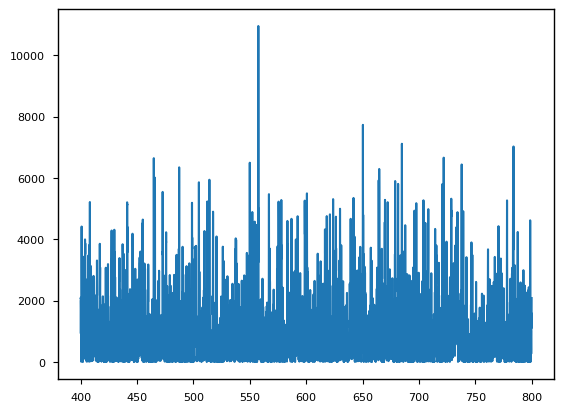

In [119]:
plt.plot(freq,spectra)
plt.show()

In [122]:
#this is assuming the scintillation bandwidth stays constant across the band^^ 

#let's chop up into subbands and create the nu^4 scaling

num_subbands = 64
subb_len = int(len(freq)/num_subbands)

spec = []

for i in range(num_subbands):
    f_cent = np.nanmean(freq[i*subb_len : (i+1)*subb_len])
    corrlen = 124000 * (f_cent/600.)**4/(400e6/(1024*512)) 
    t_scatt = 1/(2*np.pi*corrlen/subb_len)
    t = (np.random.randn(subb_len)+1j*np.random.randn(subb_len))*np.exp(-np.arange(subb_len)/t_scatt)**0.5 
    spec.append(np.abs(np.fft.fft(t))**2)
    


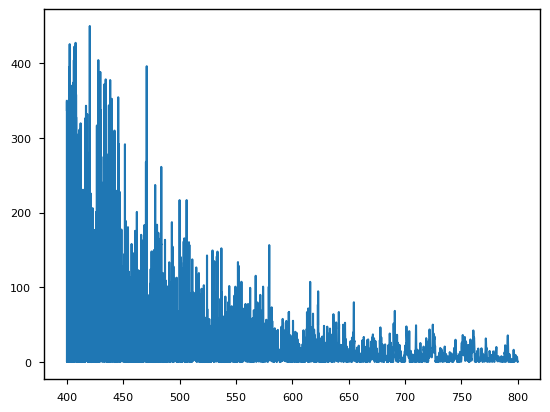

In [123]:
spec = np.concatenate(spec).ravel()
spec[4]=0
spec = np.ma.masked_where(spec==0,spec)
plt.plot(freq,spec)
plt.show()

beg,end 0 32768
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1570.79it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 32768 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1598.21it/s]


Could not fit a Lorentzian
beg,end 65536 98304
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1561.80it/s]


Could not fit a Lorentzian
beg,end 98304 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1498.35it/s]


Could not fit a Lorentzian
beg,end 131072 163840
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1501.17it/s]


Could not fit a Lorentzian
beg,end 163840 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1496.62it/s]


Could not fit a Lorentzian
beg,end 196608 229376
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1500.50it/s]


Could not fit a Lorentzian
beg,end 229376 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1497.25it/s]


Could not fit a Lorentzian
beg,end 262144 294912
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1498.15it/s]


Could not fit a Lorentzian
beg,end 294912 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1479.11it/s]


Could not fit a Lorentzian
beg,end 327680 360448
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1506.83it/s]


Could not fit a Lorentzian
beg,end 360448 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1490.93it/s]


Could not fit a Lorentzian
beg,end 393216 425984
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1512.56it/s]


Could not fit a Lorentzian
beg,end 425984 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1508.23it/s]


Could not fit a Lorentzian
beg,end 458752 491520
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1498.37it/s]


Could not fit a Lorentzian
beg,end 491520 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:00<00:00, 1496.94it/s]


Could not fit a Lorentzian


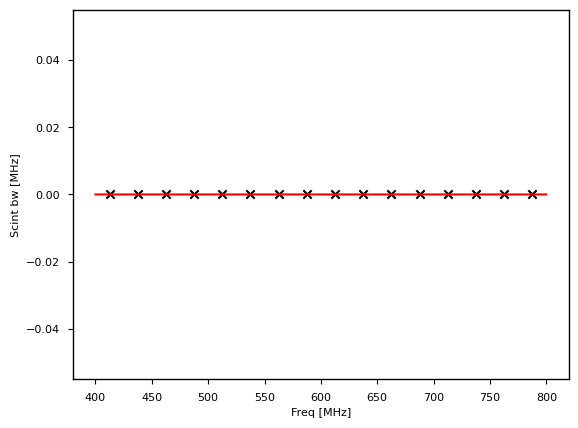

In [124]:
acfs,fcents,lags, subsn, submask,spec_lens=acf_per_subband(spec,freq,freq_inds,num_subbands=16,plot_fit=True,maxlag=1,snsubband=False)

/tmp/ipykernel_72/67657931.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('plasma')


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.21664556
    reduced chi-square = 1.1845e-04
    Akaike info crit   = -16560.1461
    Bayesian info crit = -16543.6066
[[Variables]]
    gamma1:  0.48221538 +/- 7.3131e-04 (0.15%) (init = 0.1)
    m1:      1.30723047 +/- 8.5334e-04 (0.07%) (init = 1)
    c:      -0.54229781 +/- 0.00233117 (0.43%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9903
    C(gamma1, c)  = -0.9594
    C(gamma1, m1) = +0.9270
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.01899446
    reduced chi-square = 1.0385e-05
    Akaike info crit   = -21019.4455
    Bayesian info crit = -21002.9060
[[Variables]]
    gamma1:  0.32981895 +/- 2.0856e-04 (0.06%) (init = 0.1)
    m1:      0.80445360 +/

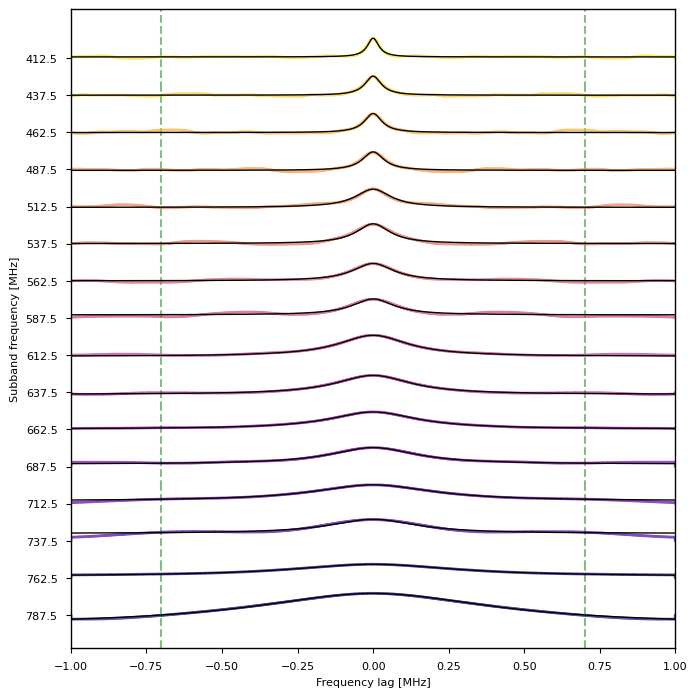

In [125]:
# single lorentz
fig = plt.figure(figsize=(7,7))

cmap = matplotlib.cm.get_cmap('plasma')
lagrange_for_fits=[0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7]
f_res=0.39101/512
sub_scint=[]
sub_scint_uncert=[]
f_cents=[]

#plt.ytick_labels(fcent)
plt.xlabel('Frequency lag [MHz]')
plt.ylabel('Subband frequency [MHz]')
acfs_offset=[]
mods1=[]
mods1_uncert=[]
for i in range(len(fcents)):
    lagrange_for_fit=lagrange_for_fits[i]
    rgba = cmap(i/len(fcents))
    acf=acfs[len(fcents)-i-1]
    lag=lags[len(fcents)-i-1]
    acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    plt.plot(lags[len(fcents)-i-1],acfs[len(fcents)-i-1]+(2.0*i),drawstyle='steps-mid',color=rgba,linewidth=2,alpha=0.7,label='%.2f MHz'%fcents[len(fcents)-i-1])
    
    #compute the ACF errors
    acf_half = acf[len(acf)//2:]
    var_f = np.ones(len(acf_half)) / (len(acf_half))
    var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
    f_errors = np.sqrt(var_f)
    
    f_errors_full = np.concatenate((f_errors[::-1],f_errors))
    acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
    
    fit=True
    #try:
    params = Parameters()
    params.add('gamma1', value = 0.1, min= 0.00001, max = 100)
    params.add('m1', value = 1, min = -100, max = 100)
    params.add('c', value = 0, min = -100, max = 100)


    fit_min = Minimizer(lorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
    result_subacf = fit_min.minimize()
    print(report_fit(result_subacf))
    #except:
    #    print('could not fit')
    #    fit=False
    
    
        
    if fit==True:
        plt.plot(lags[len(fcents)-i-1],lorentz_w_c(lags[len(fcents)-i-1],result_subacf.params['gamma1'],result_subacf.params['m1'],result_subacf.params['c'])+(2.0*i),color='k',linewidth=1)
        
        sub_scint.append(np.abs(result_subacf.params['gamma1']))
        mods1.append(np.abs(result_subacf.params['m1']))
        sub_scint_uncert.append(np.abs(result_subacf.params['gamma1'].stderr))
        mods1_uncert.append(np.abs(result_subacf.params['m1'].stderr))
        
    else:
        sub_scint.append(0)
        sub_scint_uncert.append(0)
        
        
    acfs_offset.append(acfs[len(fcents)-i-1]+(2.0*i))
        
    f_cents.append(fcents[len(fcents)-i-1])

    plt.axvline(lagrange_for_fit,ymin=0+(0.125*i),ymax=0+(0.125*i)+0.125,color='green',linestyle='--',alpha=0.5)
    plt.axvline(-1*lagrange_for_fit,ymin=0+(0.125*i),ymax=0+(0.125*i)+0.125,color='green',linestyle='--', alpha=0.5)
    

plt.yticks([x[0] for x in acfs_offset],['%.1f'%x for x in np.flip(fcents)])

plt.xlim(-1,1)
fig.tight_layout(pad=1)


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 16
    # variables        = 2
    chi-square         = 62.5927080
    reduced chi-square = 4.47090771
    Akaike info crit   = 25.8249610
    Bayesian info crit = 27.3701385
[[Variables]]
    n:  3.95240953 +/- 0.17819886 (4.51%) (init = 4)
    c:  1.0880e-12 +/- 1.2076e-12 (110.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, c) = -0.9996
None


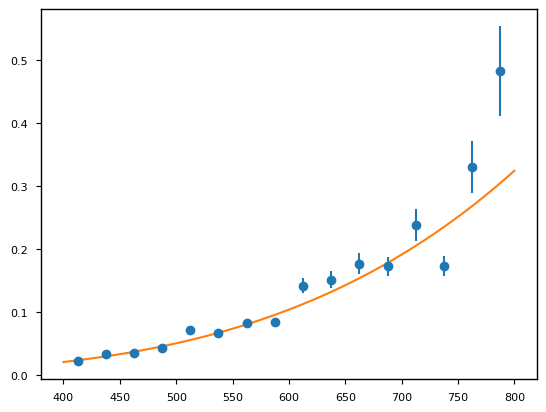

In [126]:
#let's fit for the scint bw and index
params = Parameters()
params.add('n', value = 4, min = 0, max = 10)
params.add('c', value = 1)

good_chans=np.array(spec_lens)-np.array(submask)
N = 1 + 0.2*((np.flip(good_chans)*f_res) / sub_scint)
add_un = sub_scint/(2*np.sqrt(N))

fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents,sub_scint,np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2)))
result_scint1 = fit_min.minimize()
print(report_fit(result_scint1))

plt.errorbar(f_cents,sub_scint,yerr=np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2),linestyle='none',marker='o')
plt.plot(freq,scint_freq_relation(freq,result_scint1.params['c'].value,result_scint1.params['n'].value))
plt.show()

In [127]:
print("***unflagged***")
print("scint bw",scint_freq_relation(600,result_scint1.params['c'].value,result_scint1.params['n'].value))
print("index",result_scint1.params['n'].value)

unflag_sb=scint_freq_relation(600,result_scint1.params['c'].value,result_scint1.params['n'].value)
unflag_index=result_scint1.params['n'].value

***unflagged***
scint bw 0.1039947667725712
index 3.952409531886485


beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 773.22it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 774.27it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 780.23it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 777.17it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 771.60it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 772.11it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.60it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.37it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24317234
    reduced chi-square = 1.3295e-04
    Akaike info crit   = -16348.5359
    Bayesian info crit = -16331.9964
[[Variables]]
    gamma1:  0.34654613 +/- 5.2929e-04 (0.15%) (init = 0.1)
    m1:      1.02549870 +/- 4.9775e-04 (0.05%) (init = 1)
    c:      -0.18134651 +/- 0.00108093 (0.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9536
    C(gamma1, c)  = -0.9173
    C(gamma1, m1) = +0.8045
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1832
    # variables        = 3
    chi-square         = 6.23988123
    reduced chi-square = 0.00341164
    Akaike info crit   = -10403.7948
    Bayesian info crit = -10387.2553
[[Variables]]
    gamma1:  0.14944567 +/- 0.00114928 (0.77%) (init = 0.1)

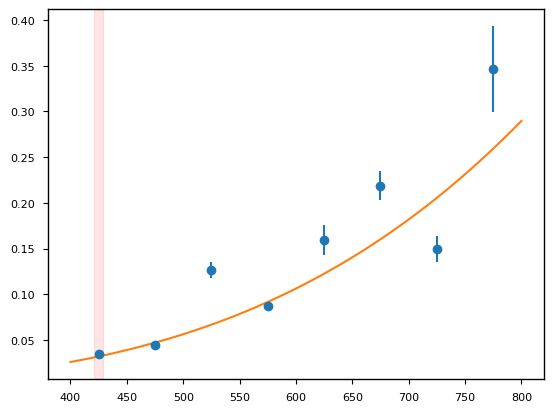

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 801.25it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.13it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.31it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.20it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.83it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.08it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.15it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.83it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.19652235
    reduced chi-square = 1.0745e-04
    Akaike info crit   = -16738.7414
    Bayesian info crit = -16722.2019
[[Variables]]
    gamma1:  0.25654729 +/- 4.1344e-04 (0.16%) (init = 0.1)
    m1:      0.83542411 +/- 3.4517e-04 (0.04%) (init = 1)
    c:       0.08813368 +/- 5.8872e-04 (0.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8701
    C(gamma1, c)  = -0.8612
    C(gamma1, m1) = +0.6043
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.22371175
    reduced chi-square = 1.2231e-04
    Akaike info crit   = -16501.3467
    Bayesian info crit = -16484.8072
[[Variables]]
    gamma1:  0.34530437 +/- 3.6038e-04 (0.10%) (init = 0.1)

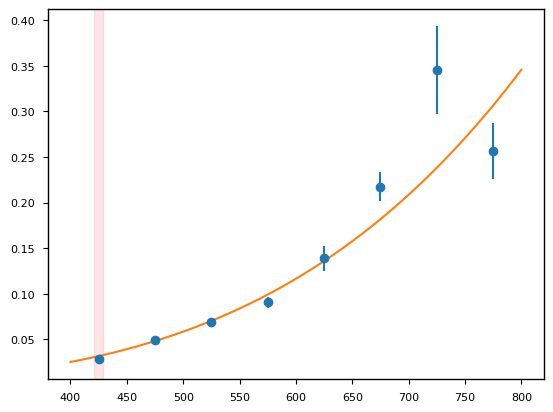

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.29it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.48it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.67it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.34it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.61it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.04it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.90it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.67it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.63982507
    reduced chi-square = 3.4982e-04
    Akaike info crit   = -14576.2144
    Bayesian info crit = -14559.6749
[[Variables]]
    gamma1:  0.37575830 +/- 0.00114251 (0.30%) (init = 0.1)
    m1:      0.94681006 +/- 9.8646e-04 (0.10%) (init = 1)
    c:      -0.10491062 +/- 0.00197850 (1.89%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9677
    C(gamma1, c)  = -0.9292
    C(gamma1, m1) = +0.8445
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.63987088
    reduced chi-square = 3.4985e-04
    Akaike info crit   = -14576.0832
    Bayesian info crit = -14559.5437
[[Variables]]
    gamma1:  0.27627014 +/- 6.0045e-04 (0.22%) (init = 0.1)

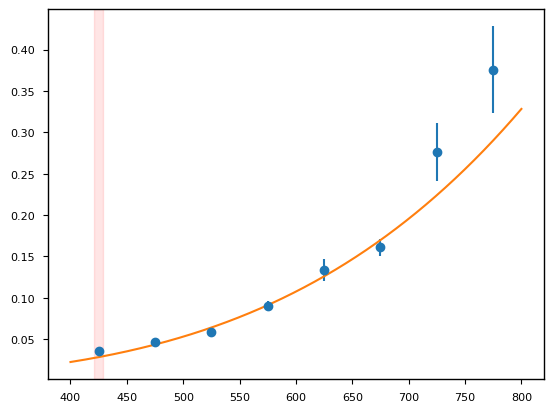

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.21it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.28it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.14it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.43it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.49it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.33it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.88it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.57it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.19959975
    reduced chi-square = 1.0913e-04
    Akaike info crit   = -16710.2758
    Bayesian info crit = -16693.7363
[[Variables]]
    gamma1:  0.38843600 +/- 4.4188e-04 (0.11%) (init = 0.1)
    m1:      1.30482177 +/- 5.2316e-04 (0.04%) (init = 1)
    c:      -0.45406124 +/- 0.00144255 (0.32%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9723
    C(gamma1, c)  = -0.9343
    C(gamma1, m1) = +0.8599
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.81379826
    reduced chi-square = 9.9169e-04
    Akaike info crit   = -12667.3004
    Bayesian info crit = -12650.7609
[[Variables]]
    gamma1:  0.17597028 +/- 5.2475e-04 (0.30%) (init = 0.1)

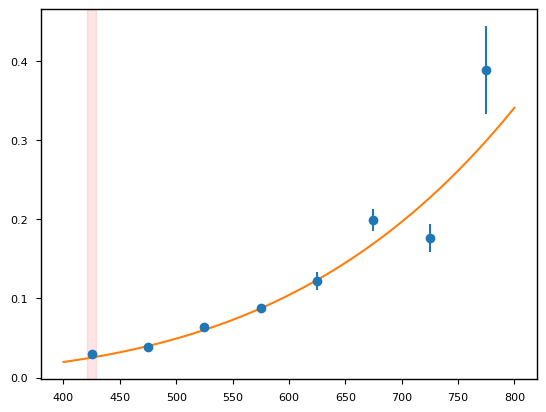

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 842.00it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 857.50it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.00it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.05it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.97it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.04it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.03it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.59it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.02425603
    reduced chi-square = 5.6001e-04
    Akaike info crit   = -13714.2089
    Bayesian info crit = -13697.6695
[[Variables]]
    gamma1:  0.20888666 +/- 5.3524e-04 (0.26%) (init = 0.1)
    m1:      0.97065923 +/- 5.7195e-04 (0.06%) (init = 1)
    c:      -0.04551242 +/- 0.00104384 (2.29%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8154
    C(m1, c)      = -0.7597
    C(gamma1, m1) = +0.4013
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.94127183
    reduced chi-square = 5.1464e-04
    Akaike info crit   = -13868.9943
    Bayesian info crit = -13852.4548
[[Variables]]
    gamma1:  0.29672038 +/- 6.6178e-04 (0.22%) (init = 0.1)

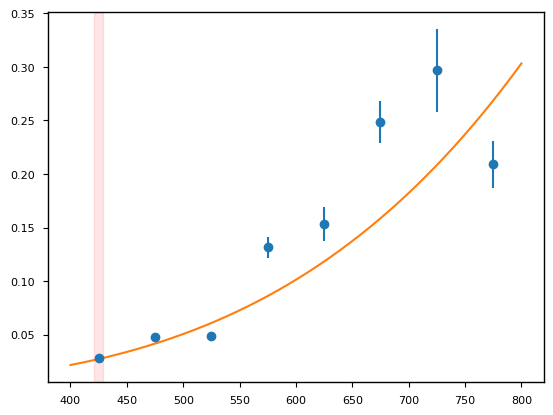

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.75it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.26it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.31it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 853.41it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.96it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 852.03it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.53it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.65it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.27770121
    reduced chi-square = 1.5183e-04
    Akaike info crit   = -16105.2915
    Bayesian info crit = -16088.7520
[[Variables]]
    gamma1:  0.25577040 +/- 5.1952e-04 (0.20%) (init = 0.1)
    m1:      0.87769085 +/- 4.6338e-04 (0.05%) (init = 1)
    c:       0.27832774 +/- 8.3137e-04 (0.30%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8809
    C(gamma1, c)  = -0.8606
    C(gamma1, m1) = +0.6209
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.16237829
    reduced chi-square = 8.8780e-05
    Akaike info crit   = -17088.3738
    Bayesian info crit = -17071.8343
[[Variables]]
    gamma1:  0.20503480 +/- 2.2735e-04 (0.11%) (init = 0.1)

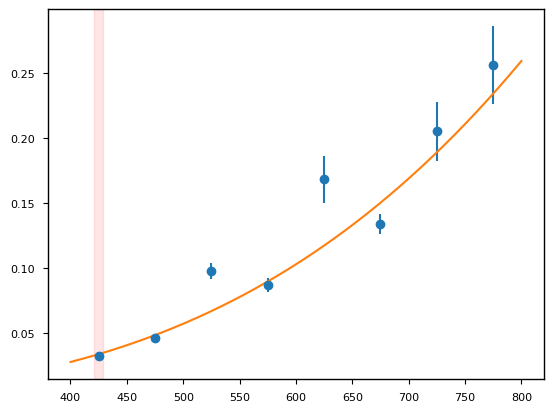

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.25it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.98it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 865.43it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 857.01it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 859.26it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.82it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 793.82it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.50it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.25804675
    reduced chi-square = 6.8783e-04
    Akaike info crit   = -13337.5611
    Bayesian info crit = -13321.0216
[[Variables]]
    gamma1:  0.23072289 +/- 0.00100729 (0.44%) (init = 0.1)
    m1:      0.81548037 +/- 8.6946e-04 (0.11%) (init = 1)
    c:       0.22347135 +/- 0.00140854 (0.63%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8381
    C(m1, c)      = -0.8350
    C(gamma1, m1) = +0.5279
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.74572173
    reduced chi-square = 4.0772e-04
    Akaike info crit   = -14295.6295
    Bayesian info crit = -14279.0900
[[Variables]]
    gamma1:  0.24387144 +/- 4.4003e-04 (0.18%) (init = 0.1)

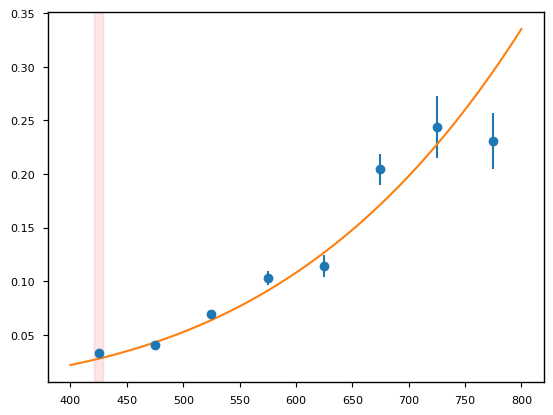

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.00it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.99it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.97it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.99it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.44it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.91it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.62it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.62it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.05938375
    reduced chi-square = 3.2468e-05
    Akaike info crit   = -18931.1974
    Bayesian info crit = -18914.6579
[[Variables]]
    gamma1:  0.27833637 +/- 2.6250e-04 (0.09%) (init = 0.1)
    m1:      0.79051581 +/- 2.0023e-04 (0.03%) (init = 1)
    c:       0.02502388 +/- 3.2877e-04 (1.31%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8959
    C(gamma1, c)  = -0.8778
    C(gamma1, m1) = +0.6620
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.27152166
    reduced chi-square = 6.9520e-04
    Akaike info crit   = -13318.0429
    Bayesian info crit = -13301.5035
[[Variables]]
    gamma1:  0.27373621 +/- 9.7037e-04 (0.35%) (init = 0.1)

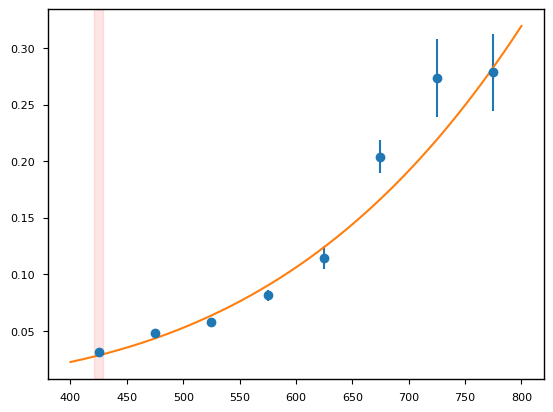

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.52it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 800.36it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.47it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.69it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.65it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.77it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.96it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 801.78it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.18319963
    reduced chi-square = 1.0016e-04
    Akaike info crit   = -16867.3472
    Bayesian info crit = -16850.8077
[[Variables]]
    gamma1:  0.28224044 +/- 4.2312e-04 (0.15%) (init = 0.1)
    m1:      0.88835055 +/- 3.6301e-04 (0.04%) (init = 1)
    c:       0.04673709 +/- 6.7088e-04 (1.44%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9045
    C(gamma1, c)  = -0.8806
    C(gamma1, m1) = +0.6795
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.39095636
    reduced chi-square = 2.1375e-04
    Akaike info crit   = -15478.6555
    Bayesian info crit = -15462.1160
[[Variables]]
    gamma1:  0.24043074 +/- 3.9278e-04 (0.16%) (init = 0.1)

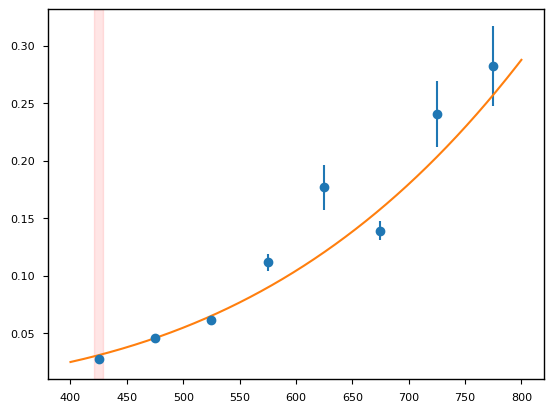

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.75it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.62it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.66it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.59it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.59it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 781.42it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.50it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 784.01it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.07523726
    reduced chi-square = 4.1136e-05
    Akaike info crit   = -18497.6987
    Bayesian info crit = -18481.1592
[[Variables]]
    gamma1:  0.40898965 +/- 3.0998e-04 (0.08%) (init = 0.1)
    m1:      1.23792518 +/- 3.4554e-04 (0.03%) (init = 1)
    c:      -0.47193221 +/- 9.0329e-04 (0.19%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9776
    C(gamma1, c)  = -0.9411
    C(gamma1, m1) = +0.8782
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 4.46171260
    reduced chi-square = 0.00243943
    Akaike info crit   = -11018.2997
    Bayesian info crit = -11001.7602
[[Variables]]
    gamma1:  0.26291112 +/- 0.00115215 (0.44%) (init = 0.1)

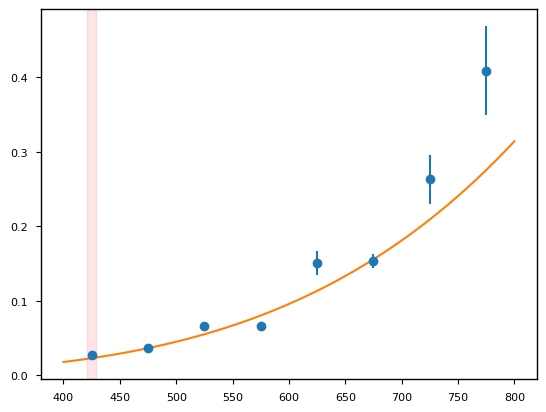

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.55it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.52it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.45it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 760.05it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.06it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.23it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.33it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.61it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.03589648
    reduced chi-square = 1.9626e-05
    Akaike info crit   = -19853.3922
    Bayesian info crit = -19836.8527
[[Variables]]
    gamma1:  0.34937676 +/- 2.2307e-04 (0.06%) (init = 0.1)
    m1:      1.02273311 +/- 2.1076e-04 (0.02%) (init = 1)
    c:      -0.06737451 +/- 4.5597e-04 (0.68%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9574
    C(gamma1, c)  = -0.9183
    C(gamma1, m1) = +0.8129
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.29413681
    reduced chi-square = 7.0757e-04
    Akaike info crit   = -13285.7456
    Bayesian info crit = -13269.2061
[[Variables]]
    gamma1:  0.22735881 +/- 5.9439e-04 (0.26%) (init = 0.1)

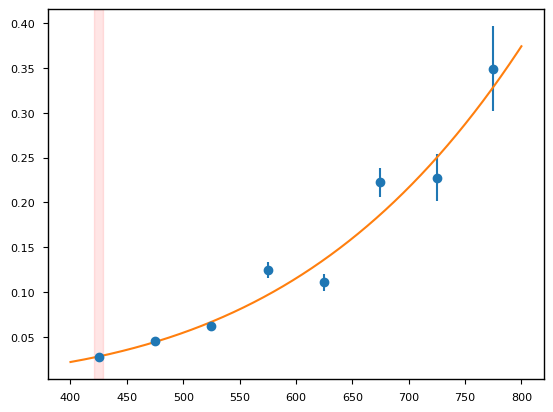

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.76it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.87it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.14it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.68it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.81it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.55it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.56it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.80it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.28488623
    reduced chi-square = 1.5576e-04
    Akaike info crit   = -16058.4946
    Bayesian info crit = -16041.9551
[[Variables]]
    gamma1:  0.42737713 +/- 8.3367e-04 (0.20%) (init = 0.1)
    m1:      1.07323321 +/- 8.0656e-04 (0.08%) (init = 1)
    c:      -0.24349967 +/- 0.00182384 (0.75%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9823
    C(gamma1, c)  = -0.9462
    C(gamma1, m1) = +0.8937
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.87721593
    reduced chi-square = 4.7962e-04
    Akaike info crit   = -13998.1115
    Bayesian info crit = -13981.5720
[[Variables]]
    gamma1:  0.34252183 +/- 0.00104499 (0.31%) (init = 0.1)

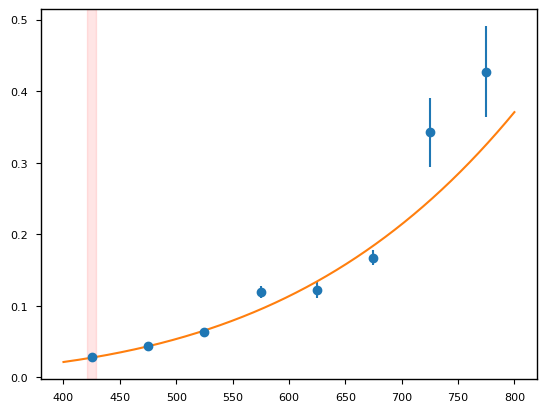

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.96it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.72it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.54it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.78it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.58it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.80it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.43it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.46it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24401201
    reduced chi-square = 1.3341e-04
    Akaike info crit   = -16342.2209
    Bayesian info crit = -16325.6814
[[Variables]]
    gamma1:  0.36687861 +/- 6.3849e-04 (0.17%) (init = 0.1)
    m1:      0.98408582 +/- 5.7367e-04 (0.06%) (init = 1)
    c:      -0.12825808 +/- 0.00119631 (0.93%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9640
    C(gamma1, c)  = -0.9257
    C(gamma1, m1) = +0.8334
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.75967192
    reduced chi-square = 4.1535e-04
    Akaike info crit   = -14261.6749
    Bayesian info crit = -14245.1354
[[Variables]]
    gamma1:  0.21968680 +/- 5.3773e-04 (0.24%) (init = 0.1)

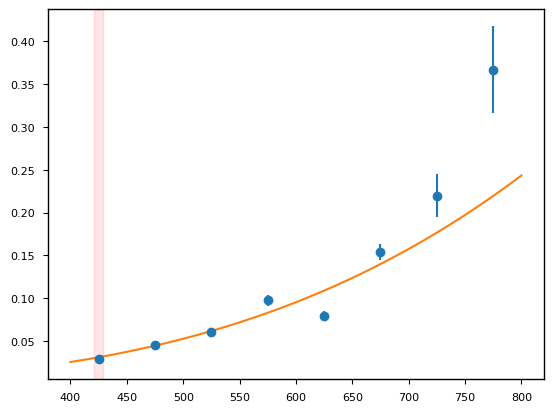

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.07it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.11it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.32it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.03it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.08it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.87it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.40it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.20it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.76121423
    reduced chi-square = 9.6294e-04
    Akaike info crit   = -12721.1972
    Bayesian info crit = -12704.6578
[[Variables]]
    gamma1:  0.16883743 +/- 8.0636e-04 (0.48%) (init = 0.1)
    m1:      0.83014551 +/- 8.7687e-04 (0.11%) (init = 1)
    c:       0.31887157 +/- 0.00126003 (0.40%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.7639
    C(m1, c)      = -0.6875
    C(gamma1, m1) = +0.2584
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.30253640
    reduced chi-square = 1.6541e-04
    Akaike info crit   = -15948.3700
    Bayesian info crit = -15931.8305
[[Variables]]
    gamma1:  0.26426782 +/- 5.4506e-04 (0.21%) (init = 0.1)

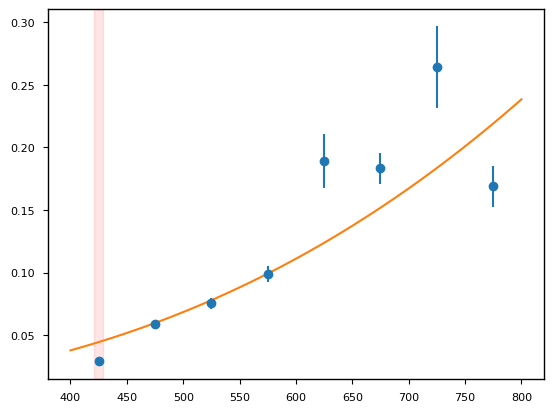

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.45it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.32it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.13it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.08it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.90it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.16it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.07it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.30it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.10290762
    reduced chi-square = 5.6264e-05
    Akaike info crit   = -17923.9436
    Bayesian info crit = -17907.4041
[[Variables]]
    gamma1:  0.37714947 +/- 3.6837e-04 (0.10%) (init = 0.1)
    m1:      1.06483624 +/- 3.5488e-04 (0.03%) (init = 1)
    c:      -0.29729251 +/- 8.0081e-04 (0.27%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9671
    C(gamma1, c)  = -0.9301
    C(gamma1, m1) = +0.8445
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 8.44620735
    reduced chi-square = 0.00461794
    Akaike info crit   = -9849.14514
    Bayesian info crit = -9832.60565
[[Variables]]
    gamma1:  0.21982497 +/- 0.00140701 (0.64%) (init = 0.1)

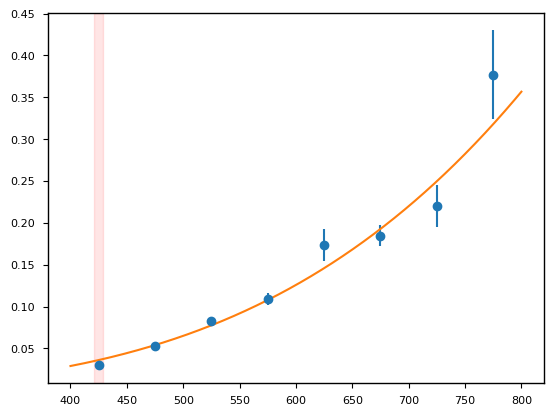

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.35it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.33it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.96it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.80it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.84it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.08it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.54it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.37it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.04541909
    reduced chi-square = 0.00111833
    Akaike info crit   = -12447.1315
    Bayesian info crit = -12430.5920
[[Variables]]
    gamma1:  0.25753157 +/- 8.9352e-04 (0.35%) (init = 0.1)
    m1:      1.04120494 +/- 9.1376e-04 (0.09%) (init = 1)
    c:      -0.17702830 +/- 0.00193464 (1.09%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8625
    C(m1, c)      = -0.8595
    C(gamma1, m1) = +0.5906
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.27188446
    reduced chi-square = 6.9540e-04
    Akaike info crit   = -13317.5203
    Bayesian info crit = -13300.9808
[[Variables]]
    gamma1:  0.18544911 +/- 5.0263e-04 (0.27%) (init = 0.1)

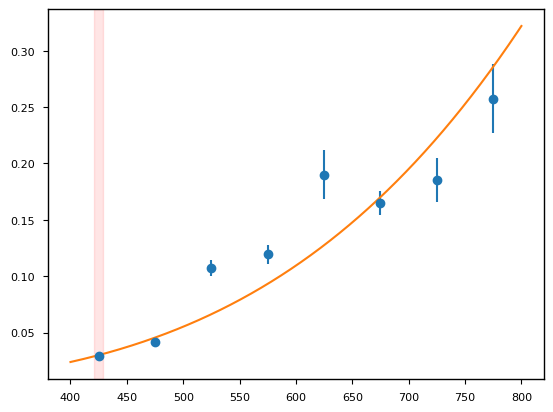

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.63it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.11it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.66it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 852.32it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.97it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 856.33it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.09it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.10it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.50371885
    reduced chi-square = 2.7541e-04
    Akaike info crit   = -15014.3858
    Bayesian info crit = -14997.8463
[[Variables]]
    gamma1:  0.47210224 +/- 0.00171258 (0.36%) (init = 0.1)
    m1:      1.05167665 +/- 0.00163519 (0.16%) (init = 1)
    c:       0.07572891 +/- 0.00359071 (4.74%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9902
    C(gamma1, c)  = -0.9569
    C(gamma1, m1) = +0.9241
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.03454965
    reduced chi-square = 1.8890e-05
    Akaike info crit   = -19923.4513
    Bayesian info crit = -19906.9118
[[Variables]]
    gamma1:  0.24337440 +/- 1.4158e-04 (0.06%) (init = 0.1)

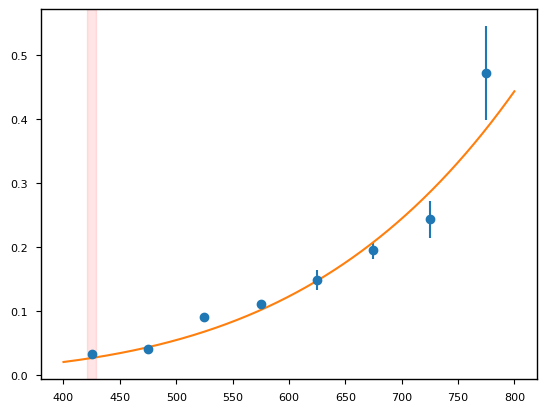

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.08it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.04it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.92it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.28it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.18it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.27it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.51it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.69it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.54051686
    reduced chi-square = 2.9553e-04
    Akaike info crit   = -14885.2160
    Bayesian info crit = -14868.6765
[[Variables]]
    gamma1:  0.29513487 +/- 4.9490e-04 (0.17%) (init = 0.1)
    m1:      1.19600536 +/- 5.5869e-04 (0.05%) (init = 1)
    c:      -0.25665001 +/- 0.00139646 (0.54%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9131
    C(gamma1, c)  = -0.8896
    C(gamma1, m1) = +0.7043
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.45189230
    reduced chi-square = 2.4707e-04
    Akaike info crit   = -15213.2941
    Bayesian info crit = -15196.7546
[[Variables]]
    gamma1:  0.27232449 +/- 4.7921e-04 (0.18%) (init = 0.1)

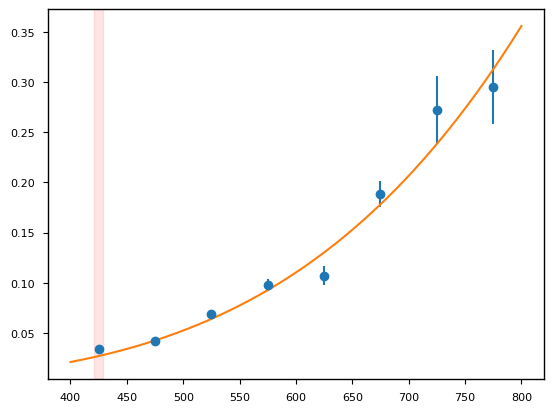

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.74it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.89it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.86it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.75it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.32it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.05it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.72it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.72it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.45311755
    reduced chi-square = 2.4774e-04
    Akaike info crit   = -15208.3336
    Bayesian info crit = -15191.7941
[[Variables]]
    gamma1:  0.38262617 +/- 0.00121027 (0.32%) (init = 0.1)
    m1:      0.87345202 +/- 9.7149e-04 (0.11%) (init = 1)
    c:       0.04828705 +/- 0.00179476 (3.72%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9718
    C(gamma1, c)  = -0.9315
    C(gamma1, m1) = +0.8552
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.47932729
    reduced chi-square = 2.6207e-04
    Akaike info crit   = -15105.3165
    Bayesian info crit = -15088.7770
[[Variables]]
    gamma1:  0.34355738 +/- 6.1268e-04 (0.18%) (init = 0.1)

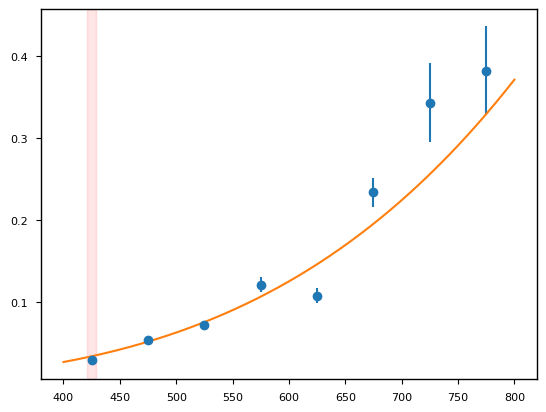

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.04it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.75it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.24it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.85it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.10it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.79it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.52it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.56it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.34265467
    reduced chi-square = 7.3409e-04
    Akaike info crit   = -13218.3191
    Bayesian info crit = -13201.7796
[[Variables]]
    gamma1:  0.22159164 +/- 7.3732e-04 (0.33%) (init = 0.1)
    m1:      0.95037680 +/- 7.4956e-04 (0.08%) (init = 1)
    c:       0.07356127 +/- 0.00138485 (1.88%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8290
    C(m1, c)      = -0.8038
    C(gamma1, m1) = +0.4750
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.65587675
    reduced chi-square = 9.0535e-04
    Akaike info crit   = -12834.1819
    Bayesian info crit = -12817.6424
[[Variables]]
    gamma1:  0.28308012 +/- 8.1083e-04 (0.29%) (init = 0.1)

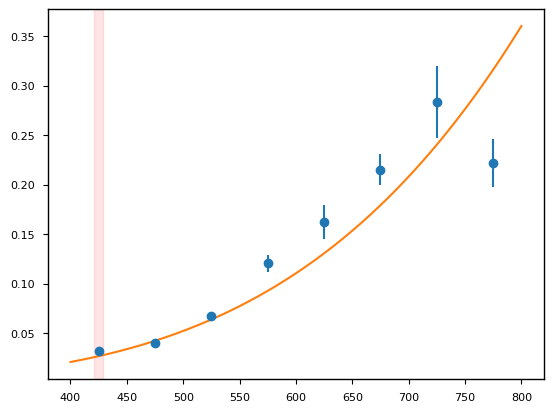

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.72it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.82it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.09it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.78it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 853.07it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.92it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.23it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.17it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.69742618
    reduced chi-square = 3.8132e-04
    Akaike info crit   = -14418.2926
    Bayesian info crit = -14401.7531
[[Variables]]
    gamma1:  0.45705367 +/- 0.00149474 (0.33%) (init = 0.1)
    m1:      1.06291007 +/- 0.00142219 (0.13%) (init = 1)
    c:      -0.28689540 +/- 0.00317418 (1.11%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9871
    C(gamma1, c)  = -0.9537
    C(gamma1, m1) = +0.9128
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.45045271
    reduced chi-square = 0.00133978
    Akaike info crit   = -12116.1439
    Bayesian info crit = -12099.6044
[[Variables]]
    gamma1:  0.20488669 +/- 7.7321e-04 (0.38%) (init = 0.1)

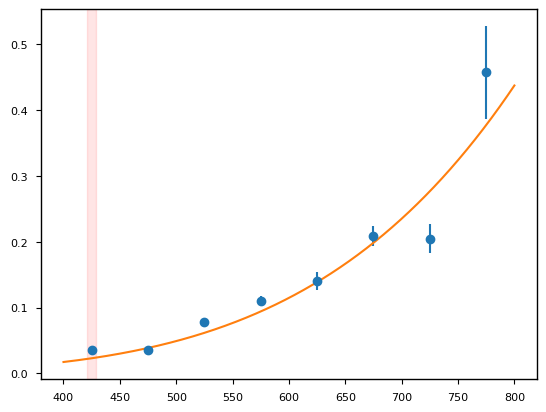

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.99it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.97it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.39it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.12it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.76it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.73it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.83it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 781.97it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.05650445
    reduced chi-square = 3.0894e-05
    Akaike info crit   = -19022.2500
    Bayesian info crit = -19005.7105
[[Variables]]
    gamma1:  0.37551522 +/- 3.3625e-04 (0.09%) (init = 0.1)
    m1:      0.88394478 +/- 2.6818e-04 (0.03%) (init = 1)
    c:      -0.17879290 +/- 5.0332e-04 (0.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9656
    C(gamma1, c)  = -0.9293
    C(gamma1, m1) = +0.8401
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.33506711
    reduced chi-square = 1.8320e-04
    Akaike info crit   = -15761.2692
    Bayesian info crit = -15744.7297
[[Variables]]
    gamma1:  0.21556317 +/- 4.3213e-04 (0.20%) (init = 0.1)

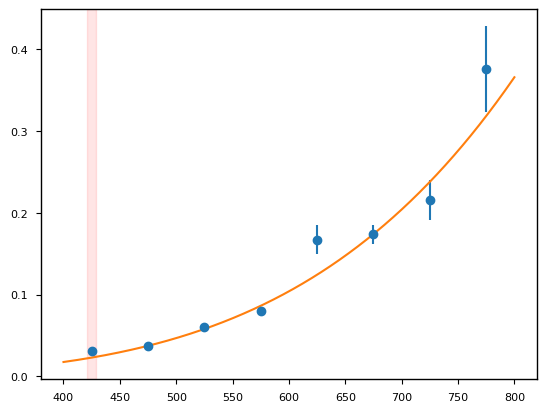

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.35it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.61it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.65it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.02it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.76it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.96it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.98it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.81it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02690034
    reduced chi-square = 1.4708e-05
    Akaike info crit   = -20381.9248
    Bayesian info crit = -20365.3853
[[Variables]]
    gamma1:  0.27390254 +/- 1.6742e-04 (0.06%) (init = 0.1)
    m1:      0.90647260 +/- 1.4994e-04 (0.02%) (init = 1)
    c:       0.21725995 +/- 2.8145e-04 (0.13%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9019
    C(gamma1, c)  = -0.8746
    C(gamma1, m1) = +0.6689
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.36533944
    reduced chi-square = 1.9975e-04
    Akaike info crit   = -15602.8084
    Bayesian info crit = -15586.2689
[[Variables]]
    gamma1:  0.26391912 +/- 3.5751e-04 (0.14%) (init = 0.1)

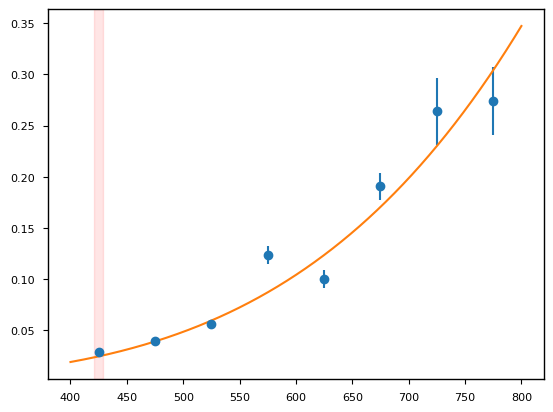

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.33it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.98it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.37it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.44it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.21it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.56it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.53it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 846.84it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.01372893
    reduced chi-square = 7.5063e-06
    Akaike info crit   = -21614.1894
    Bayesian info crit = -21597.6499
[[Variables]]
    gamma1:  0.40908372 +/- 1.3997e-04 (0.03%) (init = 0.1)
    m1:      1.11956031 +/- 1.4023e-04 (0.01%) (init = 1)
    c:      -0.45366806 +/- 3.3216e-04 (0.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9766
    C(gamma1, c)  = -0.9412
    C(gamma1, m1) = +0.8760
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.35110201
    reduced chi-square = 1.9196e-04
    Akaike info crit   = -15675.6306
    Bayesian info crit = -15659.0911
[[Variables]]
    gamma1:  0.24199556 +/- 3.7919e-04 (0.16%) (init = 0.1)

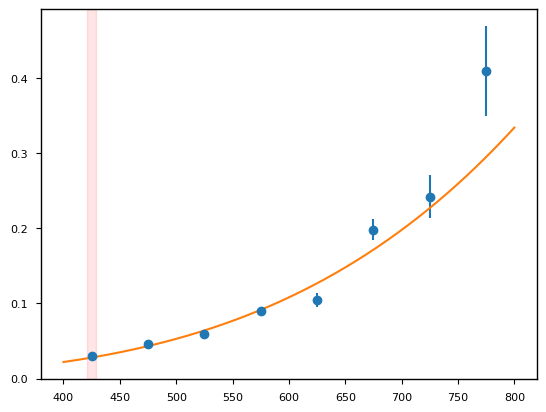

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.48it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.86it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.02it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.82it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.88it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 789.40it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 783.44it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.94it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.33367475
    reduced chi-square = 1.8244e-04
    Akaike info crit   = -15768.8979
    Bayesian info crit = -15752.3584
[[Variables]]
    gamma1:  0.43665197 +/- 0.00131369 (0.30%) (init = 0.1)
    m1:      1.10756257 +/- 0.00134939 (0.12%) (init = 1)
    c:       0.58783941 +/- 0.00312579 (0.53%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9869
    C(gamma1, c)  = -0.9483
    C(gamma1, m1) = +0.9069
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.20250061
    reduced chi-square = 1.1072e-04
    Akaike info crit   = -16683.8423
    Bayesian info crit = -16667.3028
[[Variables]]
    gamma1:  0.26340743 +/- 3.7133e-04 (0.14%) (init = 0.1)

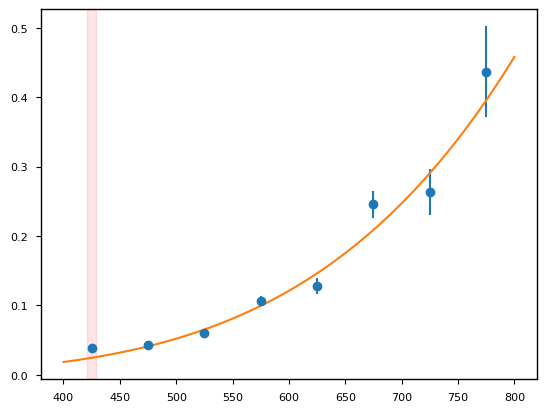

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.97it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.45it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.84it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.36it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.77it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.60it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.61it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.42it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.03666889
    reduced chi-square = 2.0049e-05
    Akaike info crit   = -19814.3898
    Bayesian info crit = -19797.8503
[[Variables]]
    gamma1:  0.32059149 +/- 2.3922e-04 (0.07%) (init = 0.1)
    m1:      0.85858320 +/- 1.9196e-04 (0.02%) (init = 1)
    c:       0.00732079 +/- 3.4804e-04 (4.75%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9387
    C(gamma1, c)  = -0.9040
    C(gamma1, m1) = +0.7625
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.50617226
    reduced chi-square = 0.00137024
    Akaike info crit   = -12074.9535
    Bayesian info crit = -12058.4140
[[Variables]]
    gamma1:  0.16553583 +/- 7.7475e-04 (0.47%) (init = 0.1)

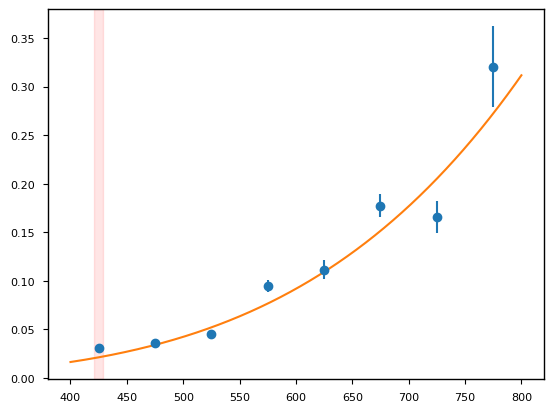

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.13it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.76it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.66it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 851.37it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.71it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.02it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.86it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.98it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.30776800
    reduced chi-square = 1.6827e-04
    Akaike info crit   = -15916.9610
    Bayesian info crit = -15900.4215
[[Variables]]
    gamma1:  0.42745793 +/- 0.00127712 (0.30%) (init = 0.1)
    m1:      0.84478896 +/- 9.7962e-04 (0.12%) (init = 1)
    c:       0.00366928 +/- 0.00174318 (47.51%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9830
    C(gamma1, c)  = -0.9459
    C(gamma1, m1) = +0.8947
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.10834809
    reduced chi-square = 6.0599e-04
    Akaike info crit   = -13569.6565
    Bayesian info crit = -13553.1170
[[Variables]]
    gamma1:  0.23172197 +/- 4.6859e-04 (0.20%) (init = 0.1

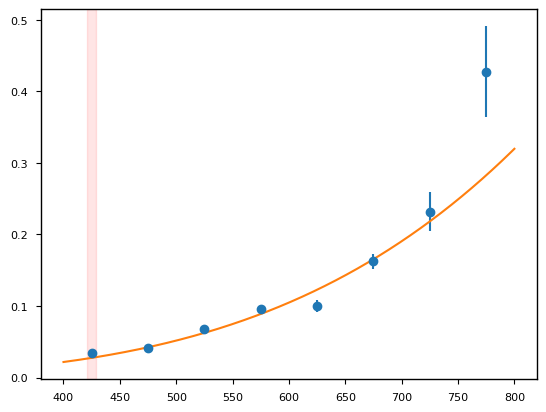

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.28it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 852.04it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 852.96it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 846.49it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.52it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.75it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.20it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 844.63it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.13453647
    reduced chi-square = 7.3557e-05
    Akaike info crit   = -17432.9610
    Bayesian info crit = -17416.4215
[[Variables]]
    gamma1:  0.34379695 +/- 4.3548e-04 (0.13%) (init = 0.1)
    m1:      0.99662202 +/- 4.0200e-04 (0.04%) (init = 1)
    c:      -0.04345558 +/- 8.4729e-04 (1.95%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9547
    C(gamma1, c)  = -0.9158
    C(gamma1, m1) = +0.8051
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.18706488
    reduced chi-square = 6.4902e-04
    Akaike info crit   = -13443.9573
    Bayesian info crit = -13427.4179
[[Variables]]
    gamma1:  0.21792347 +/- 5.7666e-04 (0.26%) (init = 0.1)

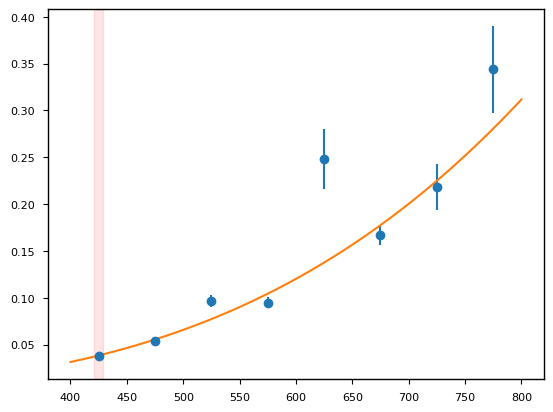

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.63it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.10it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.54it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.27it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.20it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.80it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.88it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 844.33it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.00882610
    reduced chi-square = 4.8256e-06
    Akaike info crit   = -22423.5531
    Bayesian info crit = -22407.0136
[[Variables]]
    gamma1:  0.34560767 +/- 1.0439e-04 (0.03%) (init = 0.1)
    m1:      0.91574182 +/- 8.6655e-05 (0.01%) (init = 1)
    c:      -0.22928696 +/- 1.6849e-04 (0.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9495
    C(gamma1, c)  = -0.9170
    C(gamma1, m1) = +0.7962
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.27581958
    reduced chi-square = 6.9755e-04
    Akaike info crit   = -13311.8610
    Bayesian info crit = -13295.3215
[[Variables]]
    gamma1:  0.18400328 +/- 6.0107e-04 (0.33%) (init = 0.1)

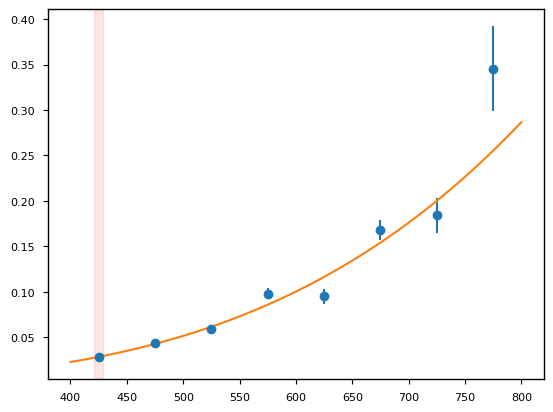

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.69it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.85it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.48it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 800.98it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.63it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.95it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.95it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 851.80it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.38338962
    reduced chi-square = 2.0962e-04
    Akaike info crit   = -15514.4605
    Bayesian info crit = -15497.9210
[[Variables]]
    gamma1:  0.38281512 +/- 8.7351e-04 (0.23%) (init = 0.1)
    m1:      0.96125197 +/- 7.6188e-04 (0.08%) (init = 1)
    c:      -0.15692325 +/- 0.00155156 (0.99%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9698
    C(gamma1, c)  = -0.9319
    C(gamma1, m1) = +0.8516
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.43067745
    reduced chi-square = 2.3547e-04
    Akaike info crit   = -15301.3848
    Bayesian info crit = -15284.8453
[[Variables]]
    gamma1:  0.20035210 +/- 5.0828e-04 (0.25%) (init = 0.1)

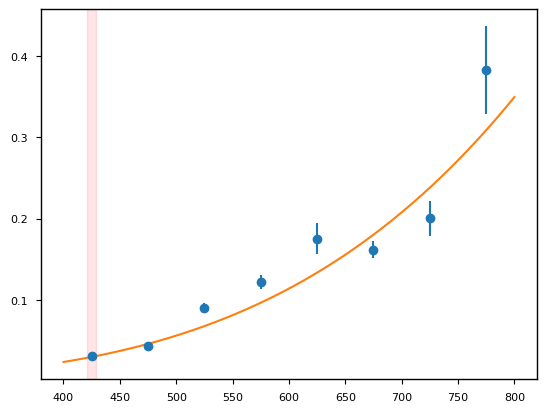

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.27it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.28it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.98it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.80it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.80it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.33it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.81it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.24it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.57593964
    reduced chi-square = 3.1489e-04
    Akaike info crit   = -14768.9260
    Bayesian info crit = -14752.3865
[[Variables]]
    gamma1:  0.38235699 +/- 0.00104705 (0.27%) (init = 0.1)
    m1:      0.89399473 +/- 8.3921e-04 (0.09%) (init = 1)
    c:      -0.23337486 +/- 0.00159406 (0.68%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9671
    C(gamma1, c)  = -0.9319
    C(gamma1, m1) = +0.8460
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.79221469
    reduced chi-square = 4.3314e-04
    Akaike info crit   = -14184.8303
    Bayesian info crit = -14168.2908
[[Variables]]
    gamma1:  0.16563519 +/- 3.7227e-04 (0.22%) (init = 0.1)

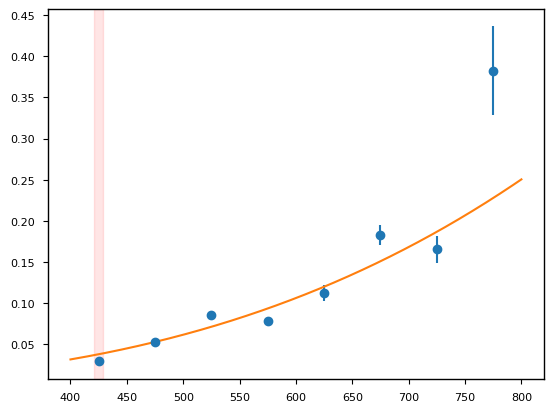

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.16it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.35it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.42it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.67it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.59it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.74it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.39it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.73it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.33870751
    reduced chi-square = 1.8519e-04
    Akaike info crit   = -15741.4724
    Bayesian info crit = -15724.9329
[[Variables]]
    gamma1:  0.23756964 +/- 6.6252e-04 (0.28%) (init = 0.1)
    m1:      0.70290549 +/- 4.8670e-04 (0.07%) (init = 1)
    c:       0.21191367 +/- 6.8687e-04 (0.32%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8472
    C(gamma1, c)  = -0.8446
    C(gamma1, m1) = +0.5514
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.88252887
    reduced chi-square = 0.00102927
    Akaike info crit   = -12599.1631
    Bayesian info crit = -12582.6236
[[Variables]]
    gamma1:  0.39263185 +/- 0.00195317 (0.50%) (init = 0.1)

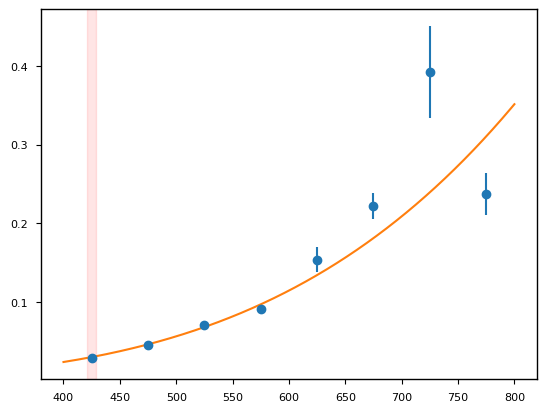

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.54it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 801.84it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.18it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.68it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.53it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.42it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.24it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.92it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.47821637
    reduced chi-square = 2.6146e-04
    Akaike info crit   = -15109.5674
    Bayesian info crit = -15093.0279
[[Variables]]
    gamma1:  0.30039331 +/- 5.2135e-04 (0.17%) (init = 0.1)
    m1:      1.14231688 +/- 5.6168e-04 (0.05%) (init = 1)
    c:      -0.17056100 +/- 0.00134420 (0.79%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9199
    C(gamma1, c)  = -0.8927
    C(gamma1, m1) = +0.7187
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.36575412
    reduced chi-square = 7.4672e-04
    Akaike info crit   = -13187.0689
    Bayesian info crit = -13170.5294
[[Variables]]
    gamma1:  0.25497044 +/- 7.2406e-04 (0.28%) (init = 0.1)

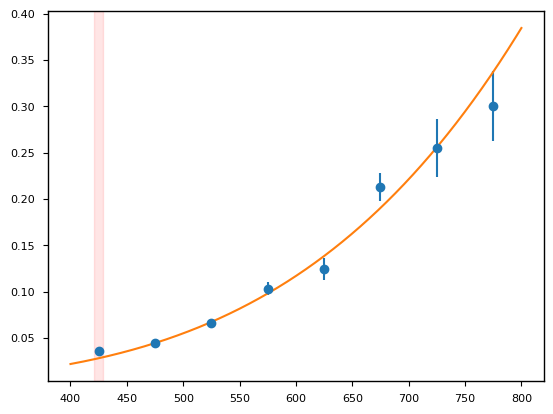

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.73it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.14it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.50it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.93it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.84it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.03it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.13it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.86it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.23898502
    reduced chi-square = 1.3066e-04
    Akaike info crit   = -16380.3569
    Bayesian info crit = -16363.8174
[[Variables]]
    gamma1:  0.23933394 +/- 3.6714e-04 (0.15%) (init = 0.1)
    m1:      0.86582868 +/- 3.2489e-04 (0.04%) (init = 1)
    c:       0.00171583 +/- 5.6096e-04 (32.69%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8465
    C(m1, c)      = -0.8319
    C(gamma1, m1) = +0.5321
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.06768929
    reduced chi-square = 3.7009e-05
    Akaike info crit   = -18691.3752
    Bayesian info crit = -18674.8357
[[Variables]]
    gamma1:  0.25105765 +/- 1.7728e-04 (0.07%) (init = 0.1

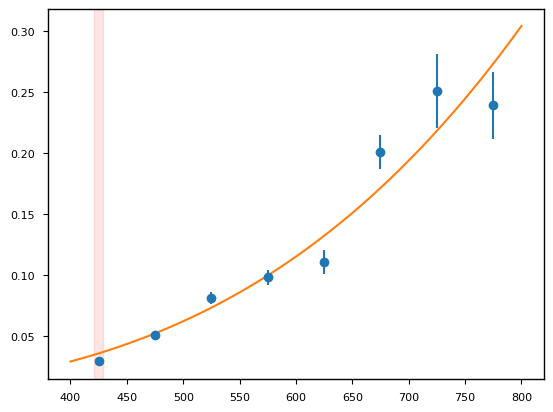

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.22it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.84it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.18it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.59it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.57it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.29it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.77it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.29it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.08706133
    reduced chi-square = 4.7601e-05
    Akaike info crit   = -18230.2886
    Bayesian info crit = -18213.7491
[[Variables]]
    gamma1:  0.39255195 +/- 3.2306e-04 (0.08%) (init = 0.1)
    m1:      1.09726134 +/- 3.1728e-04 (0.03%) (init = 1)
    c:      -0.45674874 +/- 7.3836e-04 (0.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9710
    C(gamma1, c)  = -0.9359
    C(gamma1, m1) = +0.8585
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.64771755
    reduced chi-square = 3.5414e-04
    Akaike info crit   = -14553.7542
    Bayesian info crit = -14537.2147
[[Variables]]
    gamma1:  0.23448108 +/- 4.5499e-04 (0.19%) (init = 0.1)

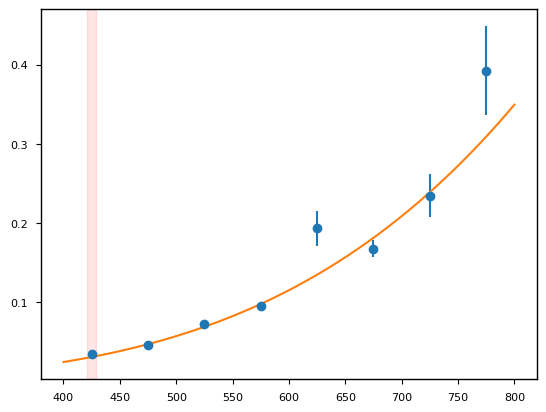

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.17it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.32it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.61it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.65it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.61it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.67it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.91it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.17it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.11472943
    reduced chi-square = 6.2728e-05
    Akaike info crit   = -17724.7230
    Bayesian info crit = -17708.1835
[[Variables]]
    gamma1:  0.34808137 +/- 3.9048e-04 (0.11%) (init = 0.1)
    m1:      0.95692855 +/- 3.4145e-04 (0.04%) (init = 1)
    c:      -0.17008045 +/- 6.9261e-04 (0.41%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9538
    C(gamma1, c)  = -0.9180
    C(gamma1, m1) = +0.8054
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.13419178
    reduced chi-square = 7.3369e-05
    Akaike info crit   = -17437.6607
    Bayesian info crit = -17421.1212
[[Variables]]
    gamma1:  0.26238535 +/- 2.1719e-04 (0.08%) (init = 0.1)

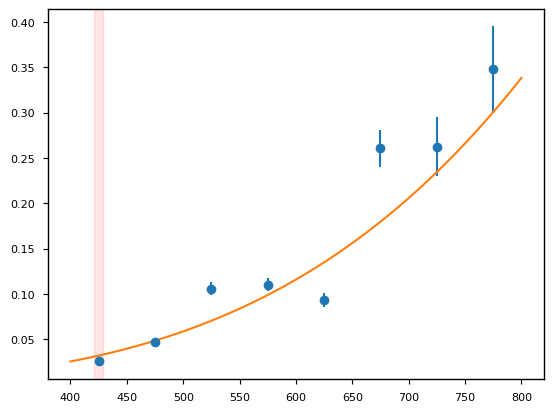

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.05it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.05it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.93it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 801.51it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 783.10it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.46it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.25it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.18it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.62022029
    reduced chi-square = 8.8585e-04
    Akaike info crit   = -12874.0618
    Bayesian info crit = -12857.5223
[[Variables]]
    gamma1:  0.29259405 +/- 0.00111198 (0.38%) (init = 0.1)
    m1:      0.94370326 +/- 9.9049e-04 (0.10%) (init = 1)
    c:      -0.12513652 +/- 0.00195414 (1.56%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9099
    C(gamma1, c)  = -0.8879
    C(gamma1, m1) = +0.6966
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24804026
    reduced chi-square = 1.3562e-04
    Akaike info crit   = -16312.2245
    Bayesian info crit = -16295.6850
[[Variables]]
    gamma1:  0.22672754 +/- 3.2442e-04 (0.14%) (init = 0.1)

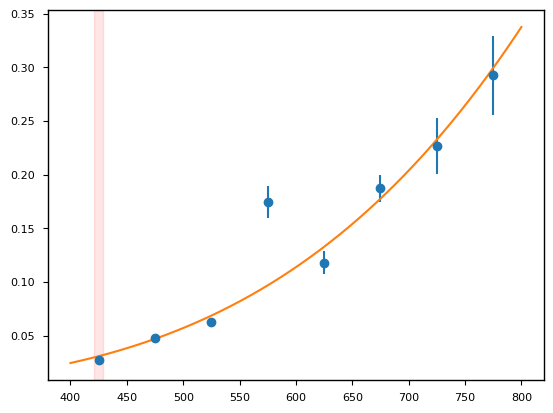

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.97it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.02it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.68it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.66it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.01it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.76it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.59it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.11it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.89199721
    reduced chi-square = 4.8770e-04
    Akaike info crit   = -13967.4991
    Bayesian info crit = -13950.9596
[[Variables]]
    gamma1:  0.25335969 +/- 9.4033e-04 (0.37%) (init = 0.1)
    m1:      0.84387125 +/- 8.0603e-04 (0.10%) (init = 1)
    c:       0.23162742 +/- 0.00138737 (0.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8744
    C(gamma1, c)  = -0.8584
    C(gamma1, m1) = +0.6081
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.74204862
    reduced chi-square = 9.5246e-04
    Akaike info crit   = -12741.2424
    Bayesian info crit = -12724.7029
[[Variables]]
    gamma1:  0.17079411 +/- 5.3543e-04 (0.31%) (init = 0.1)

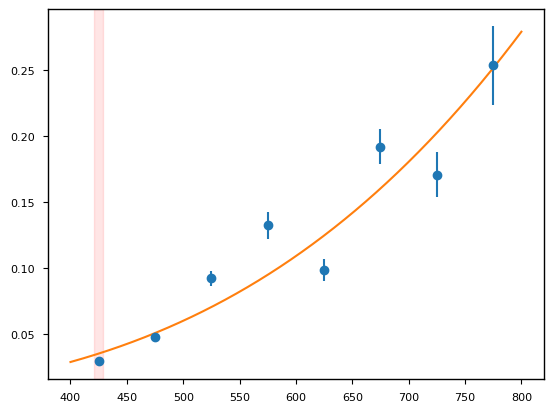

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.67it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.61it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.22it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.97it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.75it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.82it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.06it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.06it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1832
    # variables        = 3
    chi-square         = 4.26929404
    reduced chi-square = 0.00233422
    Akaike info crit   = -11099.0620
    Bayesian info crit = -11082.5225
[[Variables]]
    gamma1:  0.27594310 +/- 0.00158140 (0.57%) (init = 0.1)
    m1:      0.99112150 +/- 0.00150845 (0.15%) (init = 1)
    c:      -0.11138715 +/- 0.00309338 (2.78%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8921
    C(gamma1, c)  = -0.8766
    C(gamma1, m1) = +0.6561
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.63243330
    reduced chi-square = 0.00143927
    Akaike info crit   = -11984.9070
    Bayesian info crit = -11968.3675
[[Variables]]
    gamma1:  0.19007168 +/- 7.1995e-04 (0.38%) (init = 0.1)

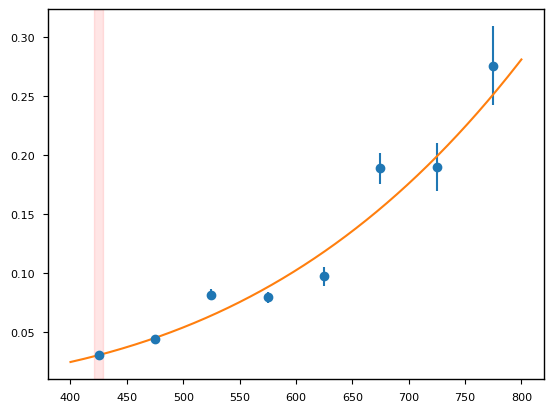

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.73it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.29it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.77it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.59it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.56it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.81it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.98it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.76it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.10289750
    reduced chi-square = 5.6259e-05
    Akaike info crit   = -17924.1238
    Bayesian info crit = -17907.5843
[[Variables]]
    gamma1:  0.45058157 +/- 5.0092e-04 (0.11%) (init = 0.1)
    m1:      1.27737099 +/- 5.7990e-04 (0.05%) (init = 1)
    c:      -0.22353620 +/- 0.00155172 (0.69%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9872
    C(gamma1, c)  = -0.9522
    C(gamma1, m1) = +0.9119
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.49975527
    reduced chi-square = 2.7324e-04
    Akaike info crit   = -15028.8582
    Bayesian info crit = -15012.3187
[[Variables]]
    gamma1:  0.21535841 +/- 3.9669e-04 (0.18%) (init = 0.1)

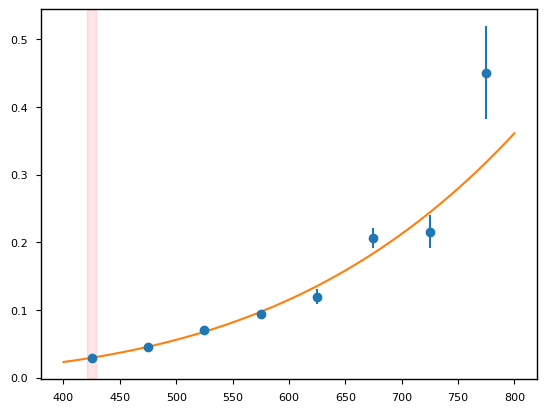

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.85it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.39it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.18it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.24it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.01it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.36it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.63it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.99it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.45697019
    reduced chi-square = 2.4985e-04
    Akaike info crit   = -15192.8228
    Bayesian info crit = -15176.2833
[[Variables]]
    gamma1:  0.27290349 +/- 6.3825e-04 (0.23%) (init = 0.1)
    m1:      0.81954605 +/- 5.0462e-04 (0.06%) (init = 1)
    c:      -0.03976307 +/- 8.5472e-04 (2.15%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8835
    C(gamma1, c)  = -0.8740
    C(gamma1, m1) = +0.6382
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.07379607
    reduced chi-square = 4.0348e-05
    Akaike info crit   = -18533.1315
    Bayesian info crit = -18516.5921
[[Variables]]
    gamma1:  0.23145289 +/- 1.5873e-04 (0.07%) (init = 0.1)

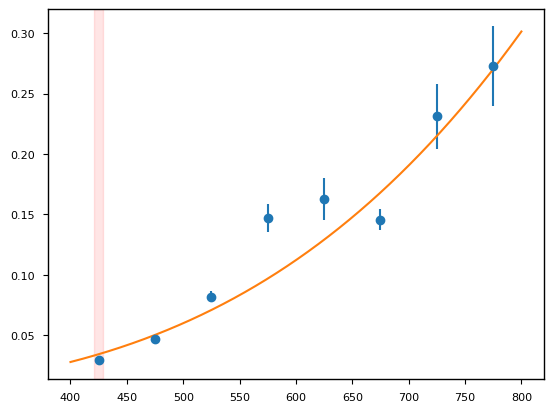

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.84it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.94it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.90it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.75it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.77it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.00it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.98it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.78it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.19267938
    reduced chi-square = 1.0535e-04
    Akaike info crit   = -16774.9207
    Bayesian info crit = -16758.3813
[[Variables]]
    gamma1:  0.23186120 +/- 4.0218e-04 (0.17%) (init = 0.1)
    m1:      0.79899447 +/- 3.3926e-04 (0.04%) (init = 1)
    c:       0.20402551 +/- 5.3899e-04 (0.26%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8391
    C(m1, c)      = -0.8342
    C(gamma1, m1) = +0.5271
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.43023909
    reduced chi-square = 2.3523e-04
    Akaike info crit   = -15303.2504
    Bayesian info crit = -15286.7109
[[Variables]]
    gamma1:  0.19765967 +/- 3.9586e-04 (0.20%) (init = 0.1)

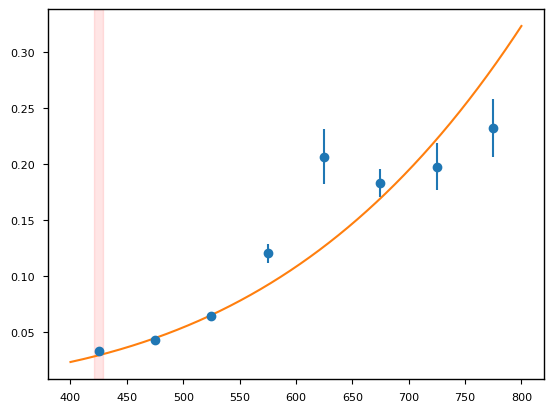

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.15it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.70it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.87it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.98it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.61it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.19it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 842.08it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.43it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.22886847
    reduced chi-square = 1.2513e-04
    Akaike info crit   = -16459.5971
    Bayesian info crit = -16443.0576
[[Variables]]
    gamma1:  0.50213565 +/- 0.00136858 (0.27%) (init = 0.1)
    m1:      1.09975493 +/- 0.00136400 (0.12%) (init = 1)
    c:       0.22936270 +/- 0.00311595 (1.36%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9932
    C(gamma1, c)  = -0.9628
    C(gamma1, m1) = +0.9381
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.35939654
    reduced chi-square = 0.00128999
    Akaike info crit   = -12185.5160
    Bayesian info crit = -12168.9765
[[Variables]]
    gamma1:  0.22054950 +/- 0.00107995 (0.49%) (init = 0.1)

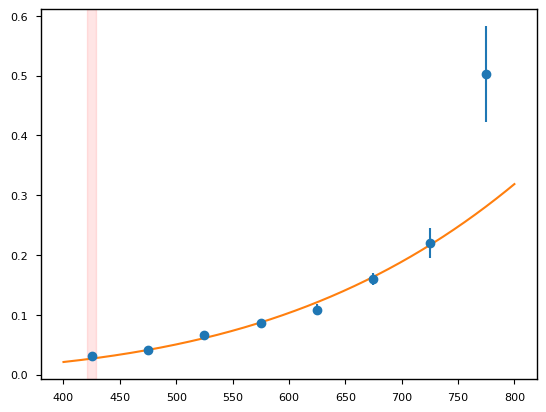

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.20it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.39it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.54it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.76it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.27it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.64it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.64it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.52it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02706401
    reduced chi-square = 1.4797e-05
    Akaike info crit   = -20370.8124
    Bayesian info crit = -20354.2729
[[Variables]]
    gamma1:  0.29761121 +/- 1.6291e-04 (0.05%) (init = 0.1)
    m1:      0.87577666 +/- 1.3408e-04 (0.02%) (init = 1)
    c:      -0.08487614 +/- 2.4626e-04 (0.29%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9138
    C(gamma1, c)  = -0.8909
    C(gamma1, m1) = +0.7056
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.08497657
    reduced chi-square = 4.6461e-05
    Akaike info crit   = -18274.6912
    Bayesian info crit = -18258.1517
[[Variables]]
    gamma1:  0.21629981 +/- 2.0261e-04 (0.09%) (init = 0.1)

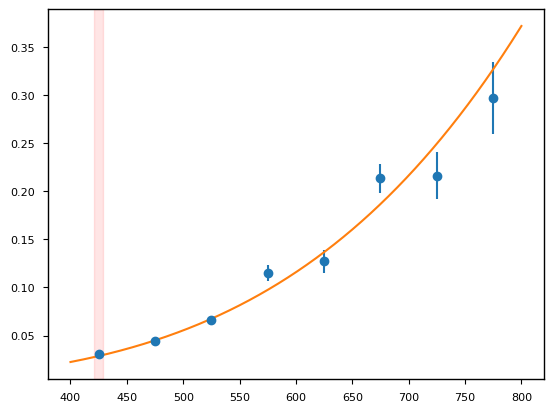

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.09it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.66it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.43it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.78it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.74it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.66it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.75it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.99it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.22659980
    reduced chi-square = 1.2389e-04
    Akaike info crit   = -16477.8475
    Bayesian info crit = -16461.3080
[[Variables]]
    gamma1:  0.25506252 +/- 4.0747e-04 (0.16%) (init = 0.1)
    m1:      0.95611628 +/- 3.9474e-04 (0.04%) (init = 1)
    c:       0.23183915 +/- 7.7011e-04 (0.33%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8774
    C(gamma1, c)  = -0.8600
    C(gamma1, m1) = +0.6152
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24386568
    reduced chi-square = 1.3333e-04
    Akaike info crit   = -16343.3199
    Bayesian info crit = -16326.7804
[[Variables]]
    gamma1:  0.29520100 +/- 4.0080e-04 (0.14%) (init = 0.1)

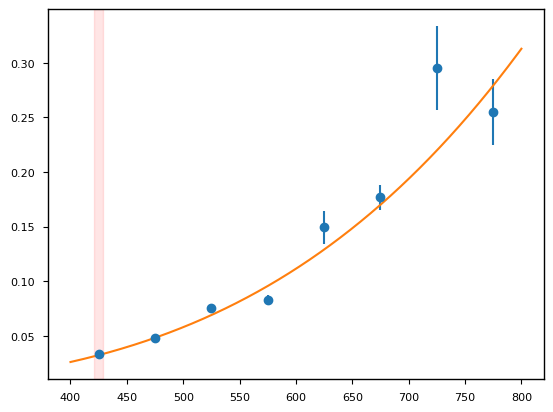

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.10it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.10it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.96it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.28it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.87it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.83it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.20it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.95it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.43808599
    reduced chi-square = 2.3952e-04
    Akaike info crit   = -15270.1386
    Bayesian info crit = -15253.5991
[[Variables]]
    gamma1:  0.31737323 +/- 8.2786e-04 (0.26%) (init = 0.1)
    m1:      0.96066876 +/- 7.5966e-04 (0.08%) (init = 1)
    c:       0.25491437 +/- 0.00153594 (0.60%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9430
    C(gamma1, c)  = -0.9020
    C(gamma1, m1) = +0.7683
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24718233
    reduced chi-square = 1.3515e-04
    Akaike info crit   = -16318.5720
    Bayesian info crit = -16302.0325
[[Variables]]
    gamma1:  0.17378423 +/- 3.6097e-04 (0.21%) (init = 0.1)

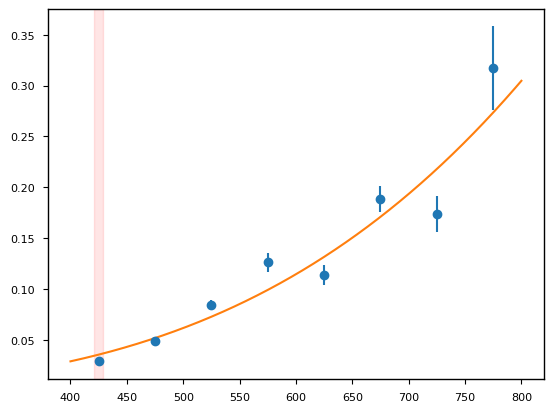

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.86it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.91it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.45it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.19it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.31it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.44it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.37it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.51it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.18154961
    reduced chi-square = 9.9262e-05
    Akaike info crit   = -16883.9223
    Bayesian info crit = -16867.3828
[[Variables]]
    gamma1:  0.44907681 +/- 6.9202e-04 (0.15%) (init = 0.1)
    m1:      1.23025735 +/- 7.7173e-04 (0.06%) (init = 1)
    c:      -0.18717032 +/- 0.00198966 (1.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9870
    C(gamma1, c)  = -0.9518
    C(gamma1, m1) = +0.9108
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.79978200
    reduced chi-square = 0.00153077
    Akaike info crit   = -11871.9955
    Bayesian info crit = -11855.4560
[[Variables]]
    gamma1:  0.26357863 +/- 9.8210e-04 (0.37%) (init = 0.1)

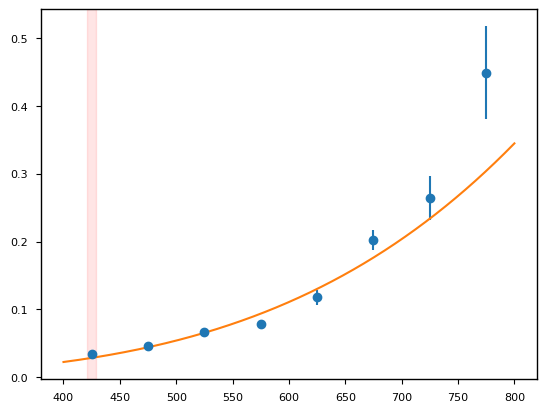

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.63it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.32it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.94it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.90it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.04it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.89it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.76it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.48it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.21613113
    reduced chi-square = 1.1817e-04
    Akaike info crit   = -16564.5014
    Bayesian info crit = -16547.9619
[[Variables]]
    gamma1:  0.43291435 +/- 8.5503e-04 (0.20%) (init = 0.1)
    m1:      1.02568837 +/- 7.9551e-04 (0.08%) (init = 1)
    c:      -0.09036537 +/- 0.00171572 (1.90%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9841
    C(gamma1, c)  = -0.9476
    C(gamma1, m1) = +0.8993
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.31798356
    reduced chi-square = 1.7386e-04
    Akaike info crit   = -15857.1398
    Bayesian info crit = -15840.6004
[[Variables]]
    gamma1:  0.24803047 +/- 3.2188e-04 (0.13%) (init = 0.1)

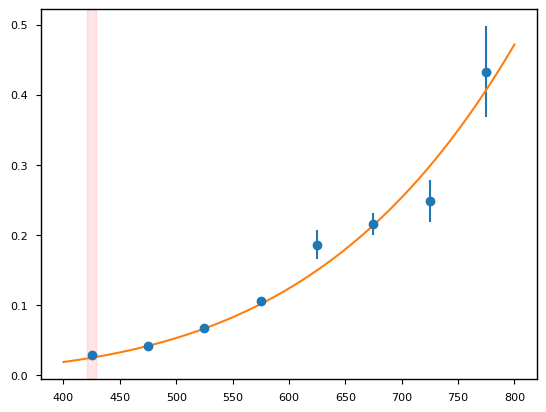

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.16it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.51it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.88it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.01it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 842.04it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.01it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.18it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.65it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.26071866
    reduced chi-square = 1.4255e-04
    Akaike info crit   = -16220.8977
    Bayesian info crit = -16204.3582
[[Variables]]
    gamma1:  0.37610141 +/- 8.4187e-04 (0.22%) (init = 0.1)
    m1:      0.89451309 +/- 6.9172e-04 (0.08%) (init = 1)
    c:       0.01322891 +/- 0.00130946 (9.90%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9693
    C(gamma1, c)  = -0.9291
    C(gamma1, m1) = +0.8474
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24523268
    reduced chi-square = 1.3408e-04
    Akaike info crit   = -16333.0792
    Bayesian info crit = -16316.5397
[[Variables]]
    gamma1:  0.22602198 +/- 3.3621e-04 (0.15%) (init = 0.1)

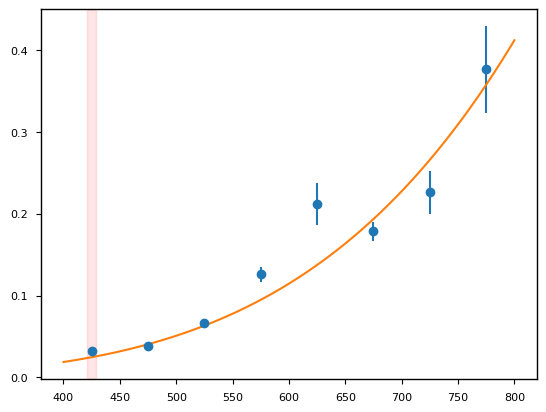

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.23it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.24it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.00it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.45it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.09it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.82it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.58it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.55it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.36252920
    reduced chi-square = 7.4496e-04
    Akaike info crit   = -13191.3998
    Bayesian info crit = -13174.8603
[[Variables]]
    gamma1:  0.24313373 +/- 6.9155e-04 (0.28%) (init = 0.1)
    m1:      0.96090996 +/- 6.6591e-04 (0.07%) (init = 1)
    c:      -0.20760630 +/- 0.00127561 (0.61%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8507
    C(m1, c)      = -0.8252
    C(gamma1, m1) = +0.5272
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.10424106
    reduced chi-square = 5.6993e-05
    Akaike info crit   = -17900.3577
    Bayesian info crit = -17883.8182
[[Variables]]
    gamma1:  0.20474116 +/- 1.5805e-04 (0.08%) (init = 0.1)

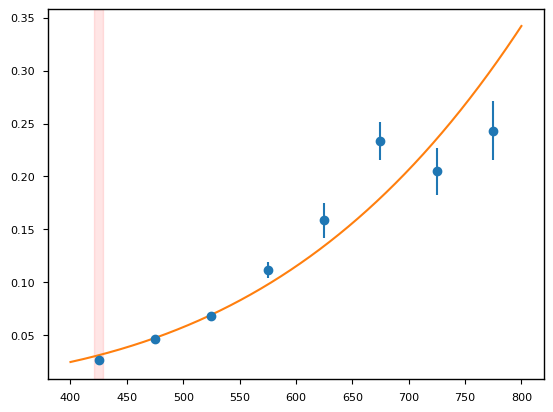

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.68it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.93it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.09it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.83it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.56it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.29it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.42it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.73it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02486987
    reduced chi-square = 1.3598e-05
    Akaike info crit   = -20525.7034
    Bayesian info crit = -20509.1639
[[Variables]]
    gamma1:  0.35896009 +/- 2.3726e-04 (0.07%) (init = 0.1)
    m1:      1.00397410 +/- 2.2339e-04 (0.02%) (init = 1)
    c:       0.25837743 +/- 4.7322e-04 (0.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9659
    C(gamma1, c)  = -0.9223
    C(gamma1, m1) = +0.8338
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 14.7300166
    reduced chi-square = 0.00805359
    Akaike info crit   = -8830.24198
    Bayesian info crit = -8813.70249
[[Variables]]
    gamma1:  0.14779196 +/- 0.00138203 (0.94%) (init = 0.1)

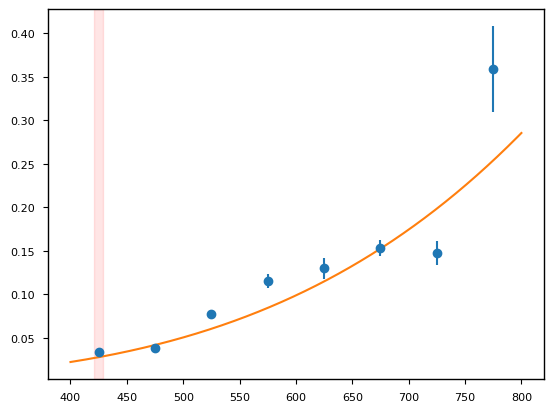

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.58it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.98it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.65it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.34it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.68it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.12it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.50it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.41it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.95838702
    reduced chi-square = 0.00107074
    Akaike info crit   = -12526.7896
    Bayesian info crit = -12510.2501
[[Variables]]
    gamma1:  0.26538860 +/- 0.00113811 (0.43%) (init = 0.1)
    m1:      0.87601852 +/- 9.6781e-04 (0.11%) (init = 1)
    c:      -0.08758175 +/- 0.00174022 (1.99%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8720
    C(gamma1, c)  = -0.8685
    C(gamma1, m1) = +0.6153
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 7.80552992
    reduced chi-square = 0.00426765
    Akaike info crit   = -9993.66257
    Bayesian info crit = -9977.12308
[[Variables]]
    gamma1:  0.26792128 +/- 0.00200755 (0.75%) (init = 0.1)

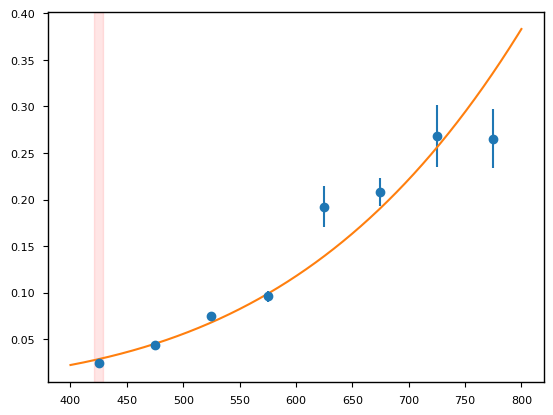

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.07it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.85it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.02it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.77it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.51it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.17it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 793.58it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.30it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.75853942
    reduced chi-square = 4.1473e-04
    Akaike info crit   = -14264.4081
    Bayesian info crit = -14247.8686
[[Variables]]
    gamma1:  0.30683620 +/- 8.1002e-04 (0.26%) (init = 0.1)
    m1:      1.04681837 +/- 8.0277e-04 (0.08%) (init = 1)
    c:      -0.00990490 +/- 0.00176443 (17.81%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9304
    C(gamma1, c)  = -0.8965
    C(gamma1, m1) = +0.7408
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.56341676
    reduced chi-square = 8.5479e-04
    Akaike info crit   = -12939.4431
    Bayesian info crit = -12922.9036
[[Variables]]
    gamma1:  0.19693059 +/- 5.4408e-04 (0.28%) (init = 0.1

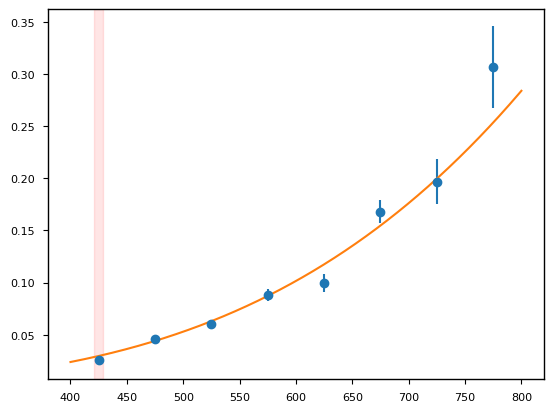

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.36it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 846.32it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 842.52it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.80it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.46it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.91it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.18it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.57it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.59001796
    reduced chi-square = 3.2259e-04
    Akaike info crit   = -14724.6830
    Bayesian info crit = -14708.1435
[[Variables]]
    gamma1:  0.42130420 +/- 0.00144327 (0.34%) (init = 0.1)
    m1:      0.97188996 +/- 0.00127639 (0.13%) (init = 1)
    c:      -0.03617464 +/- 0.00261272 (7.22%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9819
    C(gamma1, c)  = -0.9442
    C(gamma1, m1) = +0.8906
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.14482032
    reduced chi-square = 7.9180e-05
    Akaike info crit   = -17298.0187
    Bayesian info crit = -17281.4792
[[Variables]]
    gamma1:  0.31395938 +/- 3.0613e-04 (0.10%) (init = 0.1)

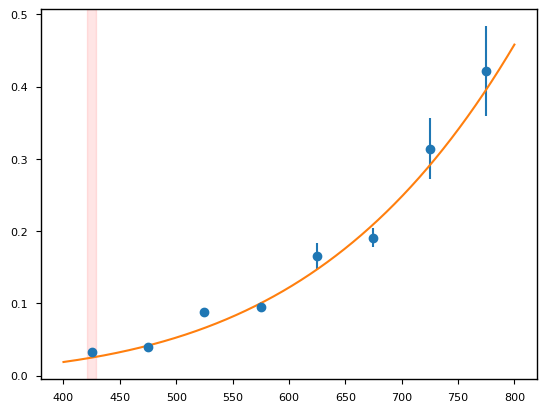

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.36it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.61it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.40it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.93it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 801.50it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.99it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.81it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.78it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.15434063
    reduced chi-square = 8.4385e-05
    Akaike info crit   = -17181.3784
    Bayesian info crit = -17164.8389
[[Variables]]
    gamma1:  0.42679580 +/- 8.6400e-04 (0.20%) (init = 0.1)
    m1:      0.90862478 +/- 7.1625e-04 (0.08%) (init = 1)
    c:       0.05235982 +/- 0.00136907 (2.61%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9834
    C(gamma1, c)  = -0.9457
    C(gamma1, m1) = +0.8957
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.01527061
    reduced chi-square = 0.00110184
    Akaike info crit   = -12474.3352
    Bayesian info crit = -12457.7957
[[Variables]]
    gamma1:  0.23385189 +/- 0.00106113 (0.45%) (init = 0.1)

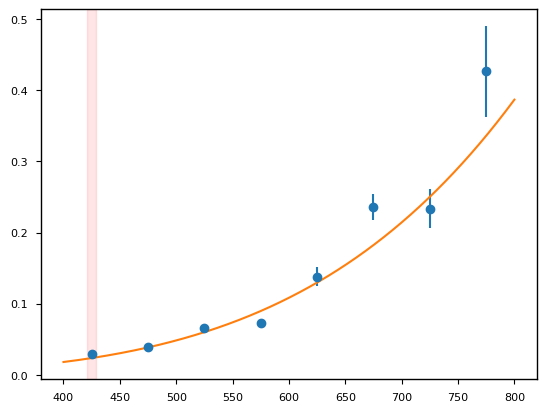

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.86it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.87it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.83it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.10it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 842.76it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.90it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.48it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.48it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.01313452
    reduced chi-square = 7.1813e-06
    Akaike info crit   = -21695.2769
    Bayesian info crit = -21678.7374
[[Variables]]
    gamma1:  0.30102591 +/- 1.4540e-04 (0.05%) (init = 0.1)
    m1:      0.86190634 +/- 1.2062e-04 (0.01%) (init = 1)
    c:       0.20091323 +/- 2.1810e-04 (0.11%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9291
    C(gamma1, c)  = -0.8926
    C(gamma1, m1) = +0.7335
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.63190120
    reduced chi-square = 0.00143898
    Akaike info crit   = -11985.2774
    Bayesian info crit = -11968.7379
[[Variables]]
    gamma1:  0.26881114 +/- 7.4131e-04 (0.28%) (init = 0.1)

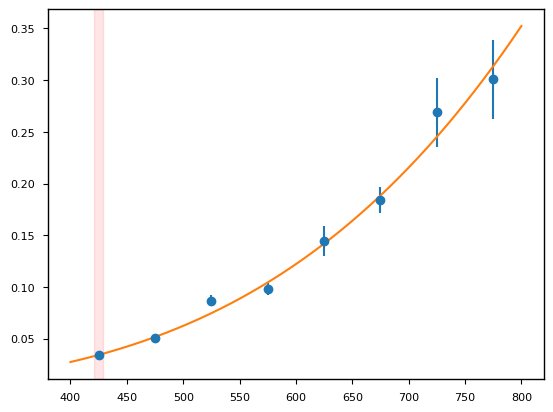

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.93it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.25it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.54it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 783.70it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 773.36it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.25it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.72it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.84it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.04941154
    reduced chi-square = 2.7016e-05
    Akaike info crit   = -19267.9864
    Bayesian info crit = -19251.4469
[[Variables]]
    gamma1:  0.42851559 +/- 4.2471e-04 (0.10%) (init = 0.1)
    m1:      1.04073581 +/- 4.0399e-04 (0.04%) (init = 1)
    c:       0.04610028 +/- 8.8324e-04 (1.92%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9841
    C(gamma1, c)  = -0.9463
    C(gamma1, m1) = +0.8980
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.27507663
    reduced chi-square = 6.9714e-04
    Akaike info crit   = -13312.9281
    Bayesian info crit = -13296.3886
[[Variables]]
    gamma1:  0.24856673 +/- 6.4249e-04 (0.26%) (init = 0.1)

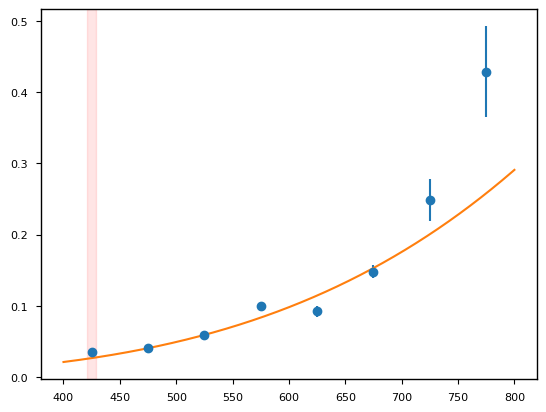

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.02it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.57it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.46it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.88it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.68it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.39it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.01it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 853.07it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.28908719
    reduced chi-square = 1.5806e-04
    Akaike info crit   = -16031.6769
    Bayesian info crit = -16015.1374
[[Variables]]
    gamma1:  0.28313449 +/- 5.3430e-04 (0.19%) (init = 0.1)
    m1:      0.83949241 +/- 4.2877e-04 (0.05%) (init = 1)
    c:      -0.02846301 +/- 7.4941e-04 (2.63%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9000
    C(gamma1, c)  = -0.8813
    C(gamma1, m1) = +0.6728
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.72983285
    reduced chi-square = 9.4578e-04
    Akaike info crit   = -12754.1342
    Bayesian info crit = -12737.5947
[[Variables]]
    gamma1:  0.25696469 +/- 0.00112016 (0.44%) (init = 0.1)

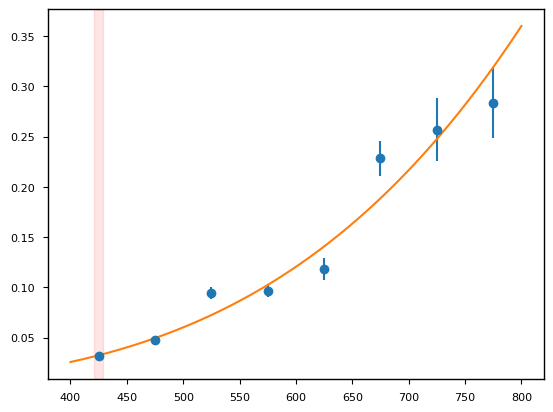

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.26it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.16it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.92it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.41it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.93it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.33it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.95it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.60it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02732678
    reduced chi-square = 1.4941e-05
    Akaike info crit   = -20353.1109
    Bayesian info crit = -20336.5714
[[Variables]]
    gamma1:  0.31509564 +/- 1.8079e-04 (0.06%) (init = 0.1)
    m1:      0.88243078 +/- 1.4835e-04 (0.02%) (init = 1)
    c:      -0.08244333 +/- 2.7620e-04 (0.34%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9313
    C(gamma1, c)  = -0.9012
    C(gamma1, m1) = +0.7465
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.12279067
    reduced chi-square = 6.1388e-04
    Akaike info crit   = -13545.9384
    Bayesian info crit = -13529.3989
[[Variables]]
    gamma1:  0.19575700 +/- 6.5415e-04 (0.33%) (init = 0.1)

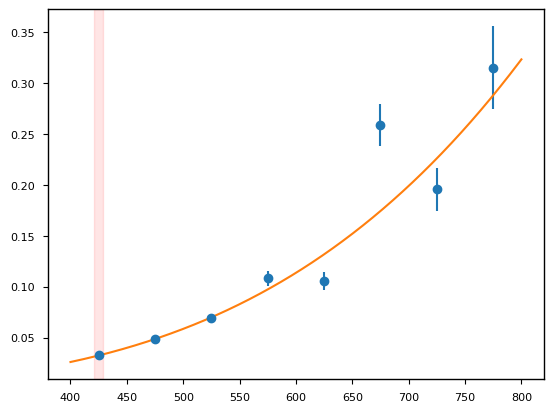

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.58it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.69it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.57it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.52it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.76it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.42it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.03it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.81it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.66541268
    reduced chi-square = 9.1056e-04
    Akaike info crit   = -12823.6620
    Bayesian info crit = -12807.1225
[[Variables]]
    gamma1:  0.32371080 +/- 0.00127898 (0.40%) (init = 0.1)
    m1:      1.01070221 +/- 0.00119928 (0.12%) (init = 1)
    c:      -0.11802099 +/- 0.00256051 (2.17%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9386
    C(gamma1, c)  = -0.9057
    C(gamma1, m1) = +0.7644
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.28483913
    reduced chi-square = 0.00124923
    Akaike info crit   = -12244.3420
    Bayesian info crit = -12227.8025
[[Variables]]
    gamma1:  0.18157512 +/- 7.3571e-04 (0.41%) (init = 0.1)

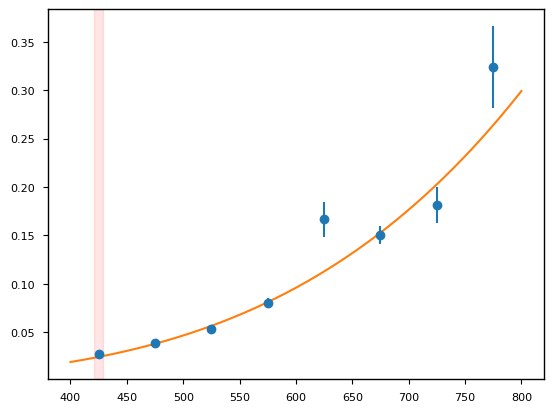

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.25it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.26it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.13it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.73it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.68it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.62it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.70it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.75it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.06532721
    reduced chi-square = 3.5717e-05
    Akaike info crit   = -18756.4466
    Bayesian info crit = -18739.9071
[[Variables]]
    gamma1:  0.27680412 +/- 2.0905e-04 (0.08%) (init = 0.1)
    m1:      0.86741743 +/- 1.7222e-04 (0.02%) (init = 1)
    c:      -0.16295870 +/- 3.0929e-04 (0.19%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8818
    C(gamma1, c)  = -0.8774
    C(gamma1, m1) = +0.6394
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.20354874
    reduced chi-square = 1.1129e-04
    Akaike info crit   = -16674.3844
    Bayesian info crit = -16657.8449
[[Variables]]
    gamma1:  0.25650753 +/- 2.6896e-04 (0.10%) (init = 0.1)

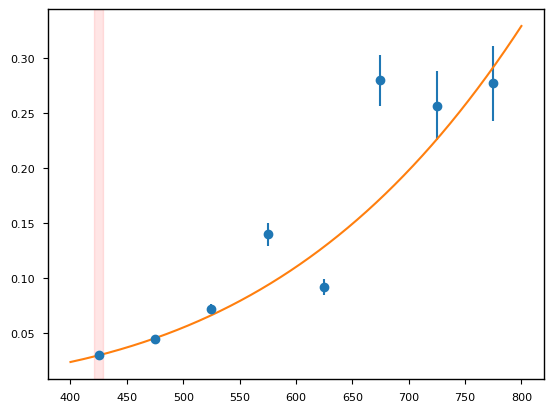

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.17it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.83it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.39it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.20it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.62it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.02it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.53it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.47it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.09395870
    reduced chi-square = 5.1372e-05
    Akaike info crit   = -18090.6124
    Bayesian info crit = -18074.0729
[[Variables]]
    gamma1:  0.39655043 +/- 3.3291e-04 (0.08%) (init = 0.1)
    m1:      1.24108408 +/- 3.7384e-04 (0.03%) (init = 1)
    c:      -0.41587392 +/- 9.8035e-04 (0.24%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9746
    C(gamma1, c)  = -0.9370
    C(gamma1, m1) = +0.8674
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.96464791
    reduced chi-square = 5.2742e-04
    Akaike info crit   = -13824.0531
    Bayesian info crit = -13807.5137
[[Variables]]
    gamma1:  0.24893976 +/- 6.0786e-04 (0.24%) (init = 0.1)

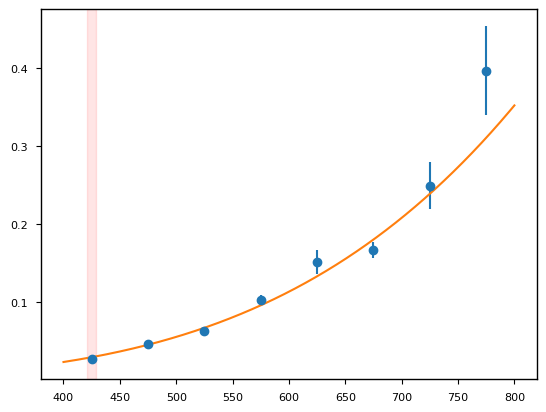

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.76it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 831.23it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.26it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.60it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.31it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 845.34it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.42it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.36it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.47613347
    reduced chi-square = 2.6032e-04
    Akaike info crit   = -15117.5642
    Bayesian info crit = -15101.0247
[[Variables]]
    gamma1:  0.32650636 +/- 6.3849e-04 (0.20%) (init = 0.1)
    m1:      1.02105549 +/- 5.9998e-04 (0.06%) (init = 1)
    c:      -0.23368658 +/- 0.00129475 (0.55%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9394
    C(gamma1, c)  = -0.9078
    C(gamma1, m1) = +0.7684
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.39397551
    reduced chi-square = 2.1540e-04
    Akaike info crit   = -15464.5623
    Bayesian info crit = -15448.0228
[[Variables]]
    gamma1:  0.18379866 +/- 3.9416e-04 (0.21%) (init = 0.1)

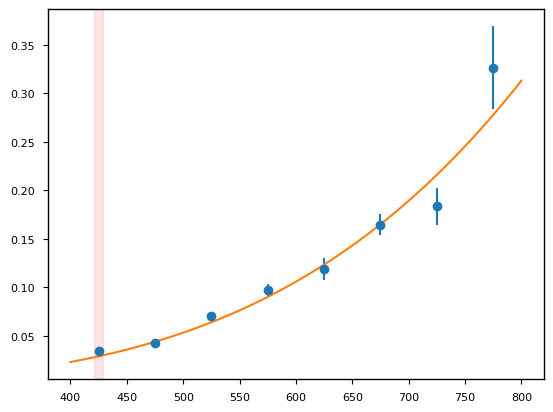

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.89it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 841.73it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.51it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.36it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.69it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.43it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.12it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.98it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.17662546
    reduced chi-square = 9.6569e-05
    Akaike info crit   = -16934.2977
    Bayesian info crit = -16917.7582
[[Variables]]
    gamma1:  0.33767913 +/- 4.7519e-04 (0.14%) (init = 0.1)
    m1:      0.91517892 +/- 3.9781e-04 (0.04%) (init = 1)
    c:      -0.16034480 +/- 7.7174e-04 (0.48%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9462
    C(gamma1, c)  = -0.9130
    C(gamma1, m1) = +0.7858
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.40690439
    reduced chi-square = 7.6922e-04
    Akaike info crit   = -13132.6858
    Bayesian info crit = -13116.1463
[[Variables]]
    gamma1:  0.27026689 +/- 8.2662e-04 (0.31%) (init = 0.1)

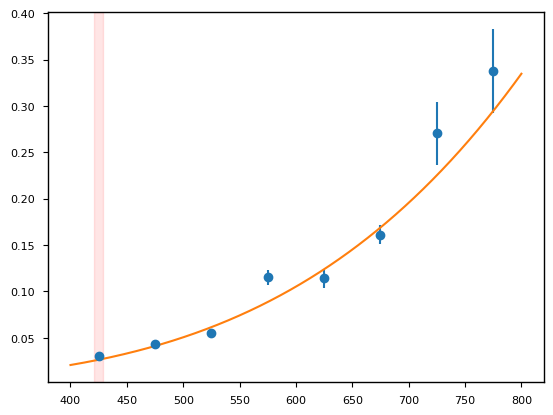

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.01it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.58it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.46it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 826.13it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.28it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.91it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.58it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.09it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.04916539
    reduced chi-square = 2.6881e-05
    Akaike info crit   = -19277.1352
    Bayesian info crit = -19260.5957
[[Variables]]
    gamma1:  0.26524718 +/- 2.2179e-04 (0.08%) (init = 0.1)
    m1:      0.77447461 +/- 1.6789e-04 (0.02%) (init = 1)
    c:       0.00925705 +/- 2.6733e-04 (2.89%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8745
    C(gamma1, c)  = -0.8680
    C(gamma1, m1) = +0.6176
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.86875034
    reduced chi-square = 0.00102173
    Akaike info crit   = -12612.6211
    Bayesian info crit = -12596.0816
[[Variables]]
    gamma1:  0.46147747 +/- 0.00238520 (0.52%) (init = 0.1)

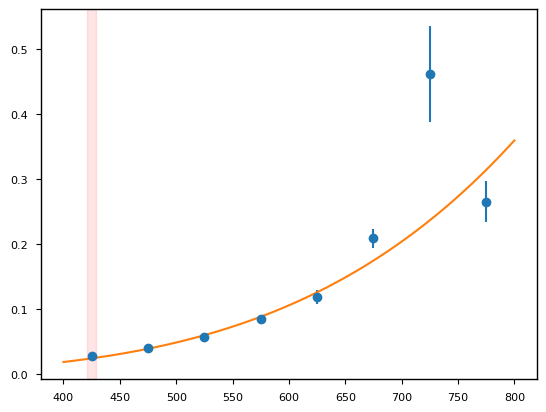

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.49it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.18it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.08it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.03it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.39it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 800.19it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.25it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.60it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.19307568
    reduced chi-square = 1.0556e-04
    Akaike info crit   = -16771.1566
    Bayesian info crit = -16754.6171
[[Variables]]
    gamma1:  0.28491266 +/- 4.1106e-04 (0.14%) (init = 0.1)
    m1:      0.91525464 +/- 3.6088e-04 (0.04%) (init = 1)
    c:      -0.00861557 +/- 6.8791e-04 (7.98%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9054
    C(gamma1, c)  = -0.8826
    C(gamma1, m1) = +0.6833
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.88554573
    reduced chi-square = 0.00157766
    Akaike info crit   = -11816.7195
    Bayesian info crit = -11800.1800
[[Variables]]
    gamma1:  0.31719809 +/- 0.00148005 (0.47%) (init = 0.1)

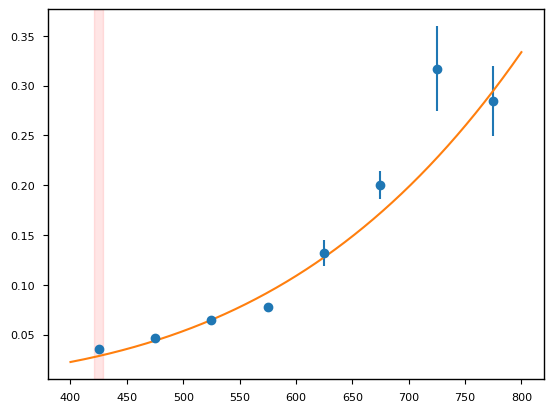

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.08it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.32it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.40it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.22it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 809.37it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 777.09it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 780.00it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.87it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.17554645
    reduced chi-square = 9.5979e-05
    Akaike info crit   = -16945.5237
    Bayesian info crit = -16928.9842
[[Variables]]
    gamma1:  0.35797349 +/- 5.3541e-04 (0.15%) (init = 0.1)
    m1:      0.97666664 +/- 4.8019e-04 (0.05%) (init = 1)
    c:      -0.08243451 +/- 9.9327e-04 (1.20%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9608
    C(gamma1, c)  = -0.9220
    C(gamma1, m1) = +0.8232
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.06533136
    reduced chi-square = 5.8247e-04
    Akaike info crit   = -13642.1759
    Bayesian info crit = -13625.6364
[[Variables]]
    gamma1:  0.28787328 +/- 7.9276e-04 (0.28%) (init = 0.1)

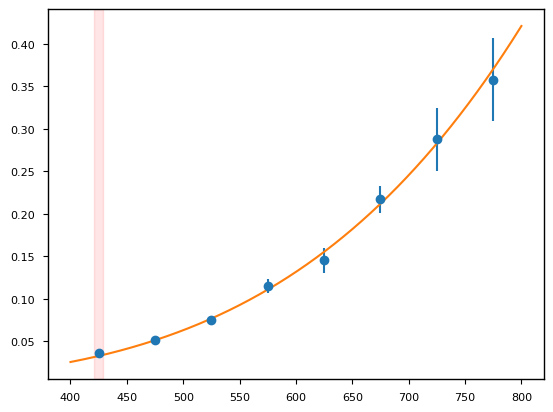

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.41it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.07it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 760.39it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.52it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 856.02it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.99it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.12it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 855.99it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.06184512
    reduced chi-square = 3.3814e-05
    Akaike info crit   = -18856.7953
    Bayesian info crit = -18840.2558
[[Variables]]
    gamma1:  0.35844524 +/- 4.4867e-04 (0.13%) (init = 0.1)
    m1:      0.83857727 +/- 3.5121e-04 (0.04%) (init = 1)
    c:       0.17929807 +/- 6.2257e-04 (0.35%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9646
    C(gamma1, c)  = -0.9220
    C(gamma1, m1) = +0.8303
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 4.10933996
    reduced chi-square = 0.00224677
    Akaike info crit   = -11169.0189
    Bayesian info crit = -11152.4794
[[Variables]]
    gamma1:  0.30263900 +/- 0.00124073 (0.41%) (init = 0.1)

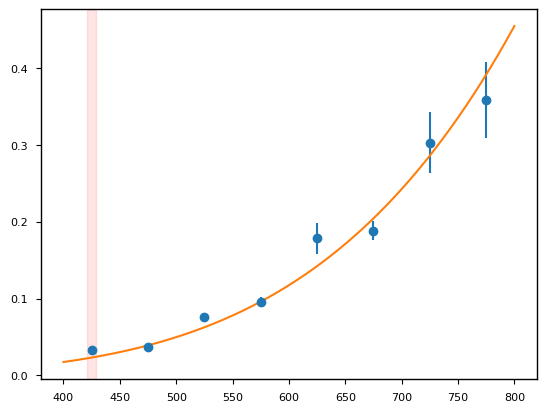

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.65it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 788.12it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.81it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.36it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.85it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 800.77it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.78it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.59it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.17265308
    reduced chi-square = 9.4398e-05
    Akaike info crit   = -16975.9705
    Bayesian info crit = -16959.4310
[[Variables]]
    gamma1:  0.31453985 +/- 4.3851e-04 (0.14%) (init = 0.1)
    m1:      0.96860140 +/- 3.9935e-04 (0.04%) (init = 1)
    c:      -0.00392162 +/- 8.1476e-04 (20.78%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9350
    C(gamma1, c)  = -0.9007
    C(gamma1, m1) = +0.7528
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.09258070
    reduced chi-square = 5.0618e-05
    Akaike info crit   = -18117.6794
    Bayesian info crit = -18101.1399
[[Variables]]
    gamma1:  0.24514510 +/- 1.9127e-04 (0.08%) (init = 0.1

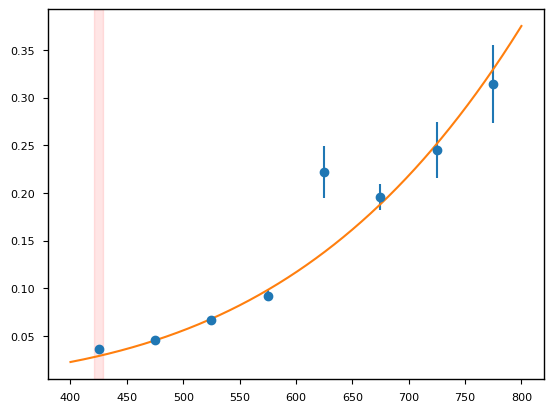

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.39it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.48it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.13it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.84it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.19it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.13it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.04it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.16it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24134828
    reduced chi-square = 1.3196e-04
    Akaike info crit   = -16362.3297
    Bayesian info crit = -16345.7902
[[Variables]]
    gamma1:  0.37169246 +/- 6.3090e-04 (0.17%) (init = 0.1)
    m1:      0.98455235 +/- 5.6468e-04 (0.06%) (init = 1)
    c:      -0.17392497 +/- 0.00117847 (0.68%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9654
    C(gamma1, c)  = -0.9277
    C(gamma1, m1) = +0.8383
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.14025241
    reduced chi-square = 0.00117018
    Akaike info crit   = -12364.1033
    Bayesian info crit = -12347.5638
[[Variables]]
    gamma1:  0.19993798 +/- 7.0173e-04 (0.35%) (init = 0.1)

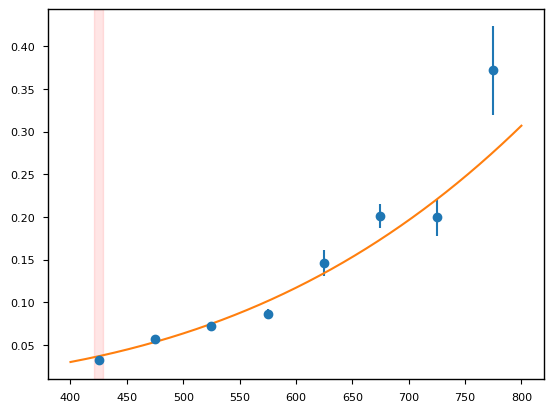

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.03it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.02it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.09it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.50it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.80it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 849.08it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.94it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 846.46it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 4.96593592
    reduced chi-square = 0.00271511
    Akaike info crit   = -10822.1491
    Bayesian info crit = -10805.6097
[[Variables]]
    gamma1:  0.19797743 +/- 9.0114e-04 (0.46%) (init = 0.1)
    m1:      1.15187721 +/- 0.00118637 (0.10%) (init = 1)
    c:      -0.09353396 +/- 0.00249996 (2.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8025
    C(m1, c)      = -0.7335
    C(gamma1, m1) = +0.3554
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.50569873
    reduced chi-square = 2.7649e-04
    Akaike info crit   = -15007.1992
    Bayesian info crit = -14990.6597
[[Variables]]
    gamma1:  0.41841390 +/- 8.6709e-04 (0.21%) (init = 0.1)

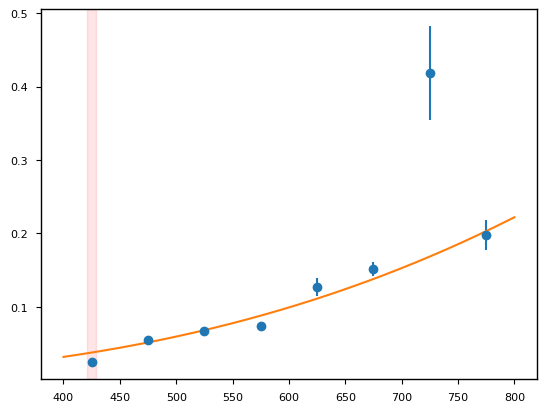

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 854.49it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.09it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.13it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 850.20it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.08it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.40it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.13it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.97it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.18140945
    reduced chi-square = 9.9185e-05
    Akaike info crit   = -16885.3371
    Bayesian info crit = -16868.7976
[[Variables]]
    gamma1:  0.25379813 +/- 4.0489e-04 (0.16%) (init = 0.1)
    m1:      0.94196445 +/- 3.9176e-04 (0.04%) (init = 1)
    c:       0.43064968 +/- 7.5346e-04 (0.17%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8830
    C(gamma1, c)  = -0.8588
    C(gamma1, m1) = +0.6224
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02375736
    reduced chi-square = 1.2989e-05
    Akaike info crit   = -20609.5441
    Bayesian info crit = -20593.0046
[[Variables]]
    gamma1:  0.31674362 +/- 1.4643e-04 (0.05%) (init = 0.1)

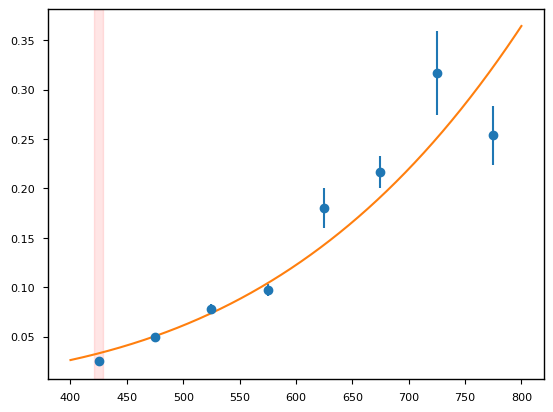

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.19it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.37it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.61it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 788.50it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.05it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 789.60it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 776.41it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.81it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.17878058
    reduced chi-square = 9.7748e-05
    Akaike info crit   = -16912.0795
    Bayesian info crit = -16895.5400
[[Variables]]
    gamma1:  0.33417459 +/- 4.5361e-04 (0.14%) (init = 0.1)
    m1:      1.04536642 +/- 4.4162e-04 (0.04%) (init = 1)
    c:      -0.04042079 +/- 9.7508e-04 (2.41%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9494
    C(gamma1, c)  = -0.9112
    C(gamma1, m1) = +0.7902
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.27673536
    reduced chi-square = 1.5130e-04
    Akaike info crit   = -16111.6743
    Bayesian info crit = -16095.1348
[[Variables]]
    gamma1:  0.26483429 +/- 5.6556e-04 (0.21%) (init = 0.1)

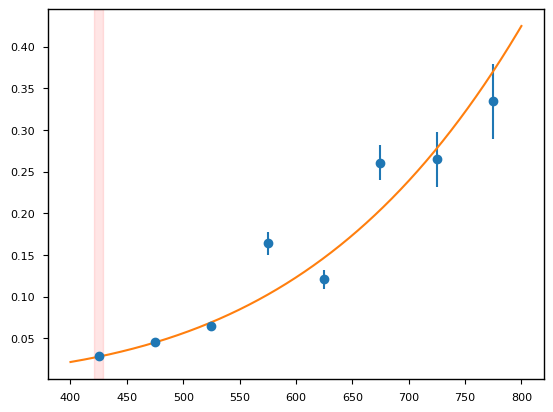

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.38it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.56it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 771.44it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 793.39it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.58it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.23it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.35it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 793.75it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.08505858
    reduced chi-square = 4.6506e-05
    Akaike info crit   = -18272.9242
    Bayesian info crit = -18256.3847
[[Variables]]
    gamma1:  0.32548502 +/- 3.2276e-04 (0.10%) (init = 0.1)
    m1:      0.89875003 +/- 2.6740e-04 (0.03%) (init = 1)
    c:      -0.12082307 +/- 5.0842e-04 (0.42%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9384
    C(gamma1, c)  = -0.9068
    C(gamma1, m1) = +0.7652
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 3.54907593
    reduced chi-square = 0.00194045
    Akaike info crit   = -11437.5445
    Bayesian info crit = -11421.0051
[[Variables]]
    gamma1:  0.18008306 +/- 0.00109873 (0.61%) (init = 0.1)

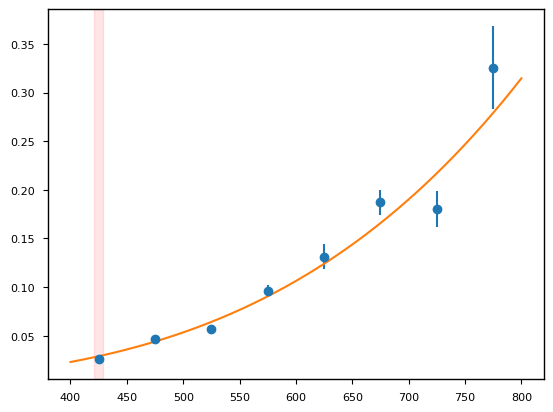

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 778.57it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 777.13it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 787.32it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.40it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.98it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.26it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.26it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.17it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02664771
    reduced chi-square = 1.4570e-05
    Akaike info crit   = -20399.2108
    Bayesian info crit = -20382.6713
[[Variables]]
    gamma1:  0.34759686 +/- 2.2997e-04 (0.07%) (init = 0.1)
    m1:      0.90478404 +/- 1.9303e-04 (0.02%) (init = 1)
    c:       0.03447257 +/- 3.6958e-04 (1.07%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9572
    C(gamma1, c)  = -0.9173
    C(gamma1, m1) = +0.8111
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.33814378
    reduced chi-square = 7.3163e-04
    Akaike info crit   = -13224.4844
    Bayesian info crit = -13207.9449
[[Variables]]
    gamma1:  0.21723775 +/- 6.2540e-04 (0.29%) (init = 0.1)

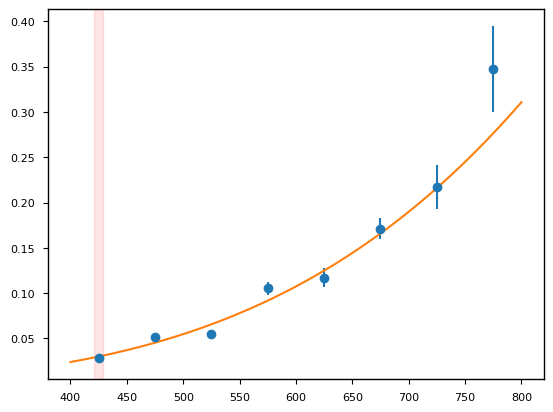

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.12it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.45it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 783.72it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 782.11it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.46it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.55it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.56it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.88it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.36072799
    reduced chi-square = 1.9723e-04
    Akaike info crit   = -15626.0798
    Bayesian info crit = -15609.5403
[[Variables]]
    gamma1:  0.40588971 +/- 7.3618e-04 (0.18%) (init = 0.1)
    m1:      1.13953802 +/- 7.5485e-04 (0.07%) (init = 1)
    c:      -0.37755346 +/- 0.00181848 (0.48%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9765
    C(gamma1, c)  = -0.9400
    C(gamma1, m1) = +0.8744
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.15075646
    reduced chi-square = 8.2426e-05
    Akaike info crit   = -17224.4238
    Bayesian info crit = -17207.8843
[[Variables]]
    gamma1:  0.25726296 +/- 3.3538e-04 (0.13%) (init = 0.1)

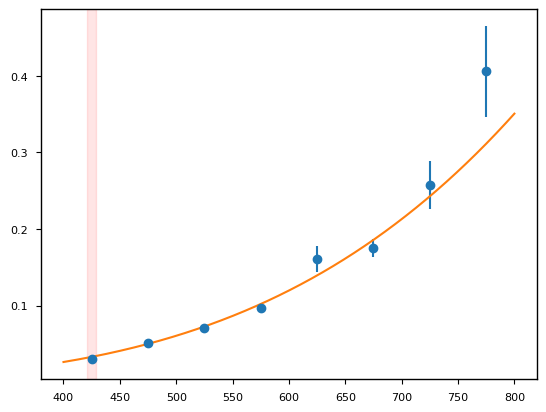

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.78it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.48it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.95it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 835.27it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 821.00it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 827.31it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.85it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.18it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.51895811
    reduced chi-square = 8.3049e-04
    Akaike info crit   = -12992.2945
    Bayesian info crit = -12975.7550
[[Variables]]
    gamma1:  0.26972217 +/- 8.8315e-04 (0.33%) (init = 0.1)
    m1:      1.05784774 +/- 9.1096e-04 (0.09%) (init = 1)
    c:      -0.05567939 +/- 0.00198474 (3.56%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8869
    C(gamma1, c)  = -0.8719
    C(gamma1, m1) = +0.6430
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 5.86315978
    reduced chi-square = 0.00320566
    Akaike info crit   = -10517.8780
    Bayesian info crit = -10501.3385
[[Variables]]
    gamma1:  0.15958723 +/- 0.00119644 (0.75%) (init = 0.1)

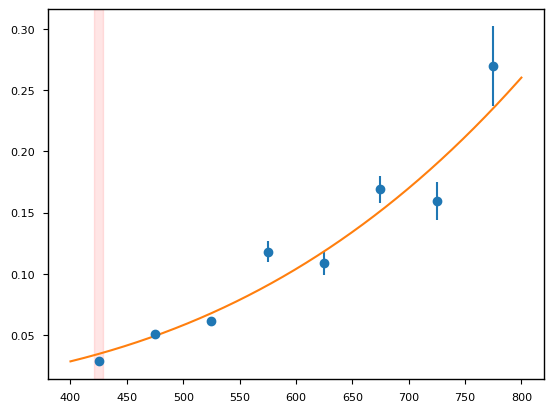

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.80it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.63it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 824.20it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.21it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.27it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.93it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.16it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.46it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.20823332
    reduced chi-square = 0.00120734
    Akaike info crit   = -12306.8184
    Bayesian info crit = -12290.2789
[[Variables]]
    gamma1:  0.32071559 +/- 0.00170761 (0.53%) (init = 0.1)
    m1:      0.99158219 +/- 0.00160293 (0.16%) (init = 1)
    c:       0.12828044 +/- 0.00334917 (2.61%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9426
    C(gamma1, c)  = -0.9038
    C(gamma1, m1) = +0.7695
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.07734029
    reduced chi-square = 4.2286e-05
    Akaike info crit   = -18447.1935
    Bayesian info crit = -18430.6540
[[Variables]]
    gamma1:  0.25735577 +/- 2.4754e-04 (0.10%) (init = 0.1)

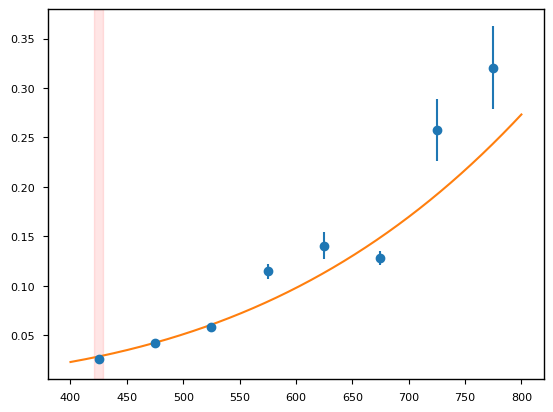

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.44it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.08it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.53it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 843.88it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.01it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.62it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 772.58it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 769.15it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.16723098
    reduced chi-square = 6.3818e-04
    Akaike info crit   = -13474.8257
    Bayesian info crit = -13458.2862
[[Variables]]
    gamma1:  0.35229731 +/- 0.00113862 (0.32%) (init = 0.1)
    m1:      0.97522828 +/- 0.00100524 (0.10%) (init = 1)
    c:      -0.29256497 +/- 0.00208093 (0.71%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9540
    C(gamma1, c)  = -0.9202
    C(gamma1, m1) = +0.8084
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.31690221
    reduced chi-square = 1.7327e-04
    Akaike info crit   = -15863.3805
    Bayesian info crit = -15846.8410
[[Variables]]
    gamma1:  0.26182723 +/- 4.1871e-04 (0.16%) (init = 0.1)

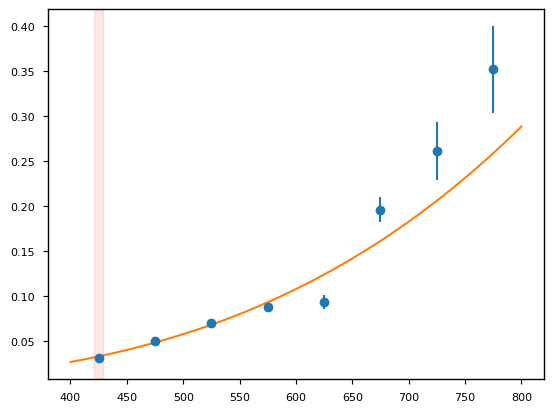

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.06it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 781.63it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.09it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.03it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.45it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 777.55it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 764.83it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.71it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.44273608
    reduced chi-square = 2.4206e-04
    Akaike info crit   = -15250.7952
    Bayesian info crit = -15234.2557
[[Variables]]
    gamma1:  0.21990930 +/- 4.7995e-04 (0.22%) (init = 0.1)
    m1:      0.75660640 +/- 3.8484e-04 (0.05%) (init = 1)
    c:      -0.04926274 +/- 5.5837e-04 (1.13%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8274
    C(m1, c)      = -0.7721
    C(gamma1, m1) = +0.4275
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.05943349
    reduced chi-square = 3.2495e-05
    Akaike info crit   = -18929.6636
    Bayesian info crit = -18913.1242
[[Variables]]
    gamma1:  0.21505893 +/- 1.8025e-04 (0.08%) (init = 0.1)

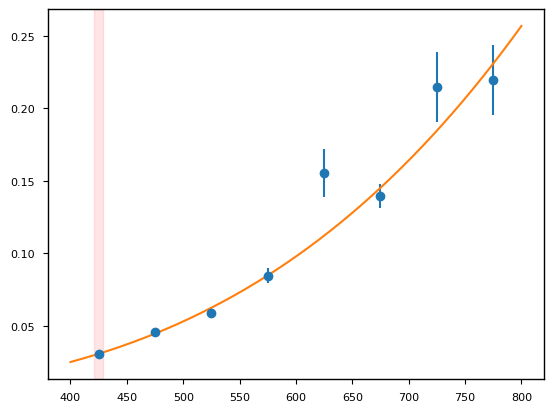

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.49it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 787.23it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 781.45it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.12it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.20it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.36it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 789.61it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 784.54it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.01235389
    reduced chi-square = 6.7544e-06
    Akaike info crit   = -21807.5287
    Bayesian info crit = -21790.9893
[[Variables]]
    gamma1:  0.37800910 +/- 1.1280e-04 (0.03%) (init = 0.1)
    m1:      1.19521489 +/- 1.2223e-04 (0.01%) (init = 1)
    c:      -0.39095821 +/- 3.0924e-04 (0.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9679
    C(gamma1, c)  = -0.9305
    C(gamma1, m1) = +0.8468
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.50490978
    reduced chi-square = 2.7606e-04
    Akaike info crit   = -15010.0596
    Bayesian info crit = -14993.5201
[[Variables]]
    gamma1:  0.30819555 +/- 6.1767e-04 (0.20%) (init = 0.1)

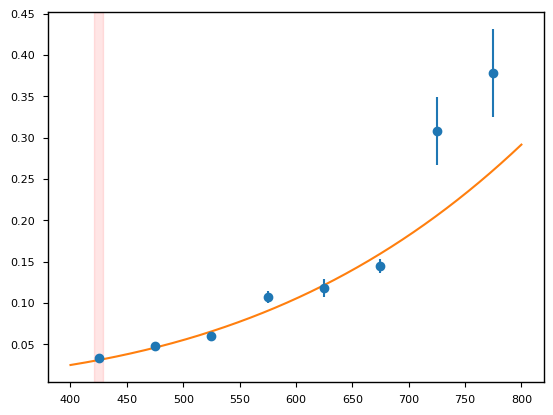

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.37it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.02it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.73it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.22it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 788.73it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.66it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.25it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 805.48it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.81550830
    reduced chi-square = 4.4588e-04
    Akaike info crit   = -14131.7404
    Bayesian info crit = -14115.2009
[[Variables]]
    gamma1:  0.25939536 +/- 7.4762e-04 (0.29%) (init = 0.1)
    m1:      0.82813008 +/- 6.0487e-04 (0.07%) (init = 1)
    c:      -0.08127234 +/- 0.00102202 (1.26%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8638
    C(m1, c)      = -0.8597
    C(gamma1, m1) = +0.5911
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.67501328
    reduced chi-square = 3.6906e-04
    Akaike info crit   = -14478.1336
    Bayesian info crit = -14461.5941
[[Variables]]
    gamma1:  0.18578185 +/- 4.1756e-04 (0.22%) (init = 0.1)

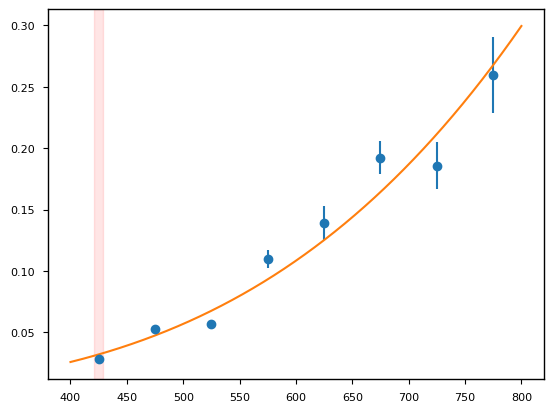

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.04it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 774.54it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 774.66it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 781.10it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 778.08it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.42it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.24it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 787.76it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.81294192
    reduced chi-square = 4.4447e-04
    Akaike info crit   = -14137.5148
    Bayesian info crit = -14120.9753
[[Variables]]
    gamma1:  0.26950097 +/- 9.5440e-04 (0.35%) (init = 0.1)
    m1:      0.85297412 +/- 8.0752e-04 (0.09%) (init = 1)
    c:       0.19483343 +/- 0.00142286 (0.73%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8942
    C(gamma1, c)  = -0.8711
    C(gamma1, m1) = +0.6522
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.31687624
    reduced chi-square = 7.2000e-04
    Akaike info crit   = -13253.8348
    Bayesian info crit = -13237.2953
[[Variables]]
    gamma1:  0.23636030 +/- 6.7649e-04 (0.29%) (init = 0.1)

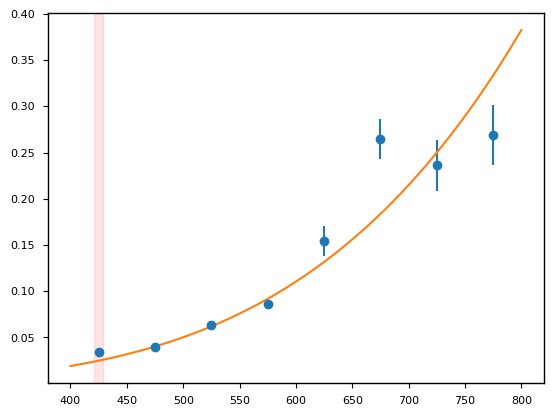

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 776.14it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 778.90it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.34it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 783.28it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 781.36it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.12it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 782.16it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 784.72it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.88047826
    reduced chi-square = 0.00102815
    Akaike info crit   = -12601.1597
    Bayesian info crit = -12584.6202
[[Variables]]
    gamma1:  0.34905020 +/- 0.00125662 (0.36%) (init = 0.1)
    m1:      1.33324955 +/- 0.00156178 (0.12%) (init = 1)
    c:      -0.03765034 +/- 0.00439395 (11.67%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9594
    C(gamma1, c)  = -0.9181
    C(gamma1, m1) = +0.8168
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.79673929
    reduced chi-square = 4.3561e-04
    Akaike info crit   = -14174.3969
    Bayesian info crit = -14157.8574
[[Variables]]
    gamma1:  0.27143942 +/- 5.9159e-04 (0.22%) (init = 0.1

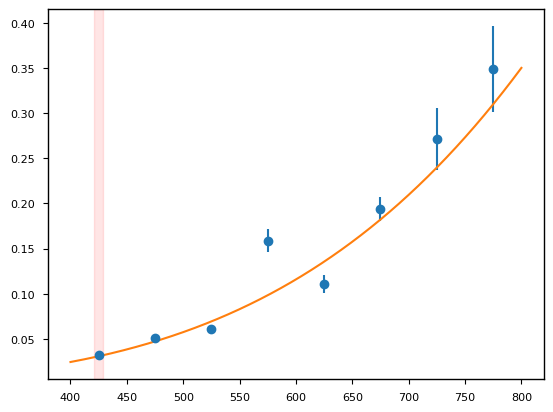

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 782.35it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.53it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.91it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.18it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.63it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.61it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.88it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 787.30it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.59654580
    reduced chi-square = 3.2616e-04
    Akaike info crit   = -14704.5255
    Bayesian info crit = -14687.9860
[[Variables]]
    gamma1:  0.25769859 +/- 6.6603e-04 (0.26%) (init = 0.1)
    m1:      0.81799250 +/- 5.3586e-04 (0.07%) (init = 1)
    c:      -0.04069476 +/- 8.9362e-04 (2.20%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8625
    C(m1, c)      = -0.8610
    C(gamma1, m1) = +0.5919
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.73193502
    reduced chi-square = 4.0018e-04
    Akaike info crit   = -14329.8160
    Bayesian info crit = -14313.2765
[[Variables]]
    gamma1:  0.17835724 +/- 4.3739e-04 (0.25%) (init = 0.1)

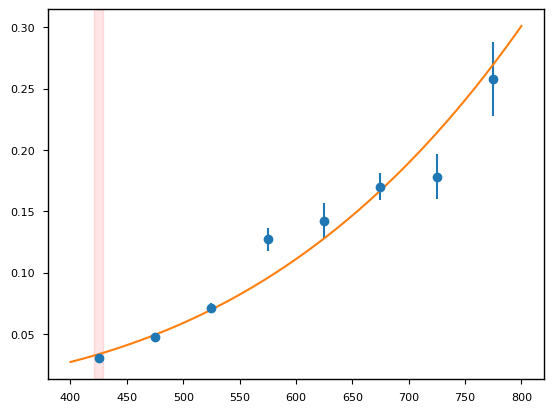

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.33it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 813.43it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.02it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.76it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.81it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 788.51it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.43it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.58it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.15362070
    reduced chi-square = 8.3992e-05
    Akaike info crit   = -17189.9438
    Bayesian info crit = -17173.4044
[[Variables]]
    gamma1:  0.43742270 +/- 4.9898e-04 (0.11%) (init = 0.1)
    m1:      1.33644577 +/- 6.0169e-04 (0.05%) (init = 1)
    c:      -0.45886069 +/- 0.00168922 (0.37%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9846
    C(gamma1, c)  = -0.9491
    C(gamma1, m1) = +0.9024
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.90001244
    reduced chi-square = 0.00103883
    Akaike info crit   = -12582.2273
    Bayesian info crit = -12565.6878
[[Variables]]
    gamma1:  0.31086804 +/- 0.00100984 (0.32%) (init = 0.1)

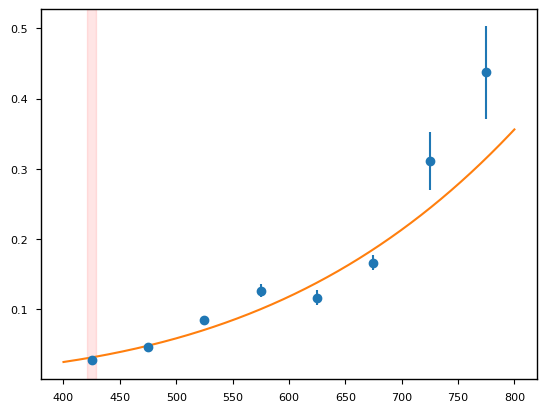

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 777.71it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.86it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.04it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.89it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 793.95it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.26it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 799.04it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.92it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.00314537
    reduced chi-square = 1.7197e-06
    Akaike info crit   = -24313.7764
    Bayesian info crit = -24297.2369
[[Variables]]
    gamma1:  0.41574060 +/- 7.4102e-05 (0.02%) (init = 0.1)
    m1:      1.33160106 +/- 9.0558e-05 (0.01%) (init = 1)
    c:      -0.06759161 +/- 2.5332e-04 (0.37%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9819
    C(gamma1, c)  = -0.9428
    C(gamma1, m1) = +0.8896
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.57354596
    reduced chi-square = 3.1358e-04
    Akaike info crit   = -14776.5559
    Bayesian info crit = -14760.0164
[[Variables]]
    gamma1:  0.27742041 +/- 5.5543e-04 (0.20%) (init = 0.1)

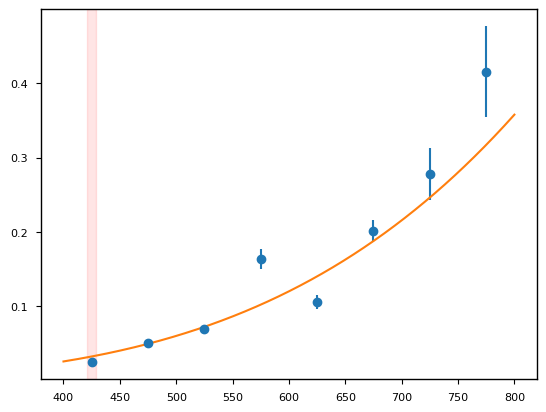

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.49it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 833.03it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.94it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 789.25it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 788.00it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.79it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 789.49it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 796.98it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.03003750
    reduced chi-square = 1.6423e-05
    Akaike info crit   = -20179.8412
    Bayesian info crit = -20163.3017
[[Variables]]
    gamma1:  0.27737127 +/- 1.8003e-04 (0.06%) (init = 0.1)
    m1:      0.75713699 +/- 1.3013e-04 (0.02%) (init = 1)
    c:      -0.04756943 +/- 2.0447e-04 (0.43%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8863
    C(gamma1, c)  = -0.8772
    C(gamma1, m1) = +0.6457
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.15162064
    reduced chi-square = 0.00117639
    Akaike info crit   = -12354.3981
    Bayesian info crit = -12337.8586
[[Variables]]
    gamma1:  0.26558895 +/- 0.00118007 (0.44%) (init = 0.1)

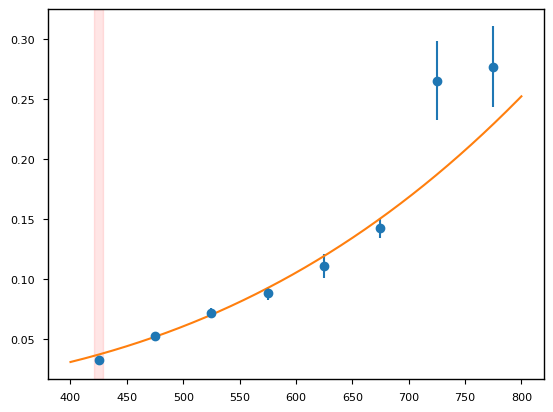

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 784.21it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 787.74it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 785.88it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 815.32it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 819.16it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 803.32it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.43it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.92it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.40597452
    reduced chi-square = 0.00131546
    Akaike info crit   = -12149.7020
    Bayesian info crit = -12133.1625
[[Variables]]
    gamma1:  0.25858267 +/- 0.00122005 (0.47%) (init = 0.1)
    m1:      0.92392066 +/- 0.00111680 (0.12%) (init = 1)
    c:      -0.00769323 +/- 0.00210505 (27.36%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8672
    C(gamma1, c)  = -0.8630
    C(gamma1, m1) = +0.6021
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.31976691
    reduced chi-square = 1.7483e-04
    Akaike info crit   = -15846.8942
    Bayesian info crit = -15830.3547
[[Variables]]
    gamma1:  0.22659233 +/- 2.8158e-04 (0.12%) (init = 0.1

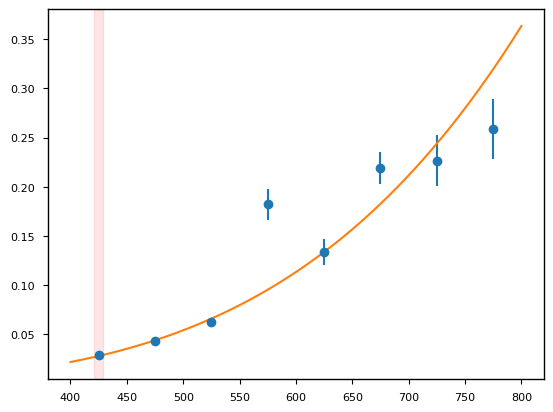

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.23it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.11it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.53it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 793.10it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 786.49it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.81it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 770.27it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.75it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.04746470
    reduced chi-square = 2.5951e-05
    Akaike info crit   = -19341.6284
    Bayesian info crit = -19325.0889
[[Variables]]
    gamma1:  0.29790042 +/- 2.4264e-04 (0.08%) (init = 0.1)
    m1:      0.83586044 +/- 1.9191e-04 (0.02%) (init = 1)
    c:      -0.00302549 +/- 3.3655e-04 (11.12%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9174
    C(gamma1, c)  = -0.8908
    C(gamma1, m1) = +0.7114
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.11008907
    reduced chi-square = 0.00115368
    Akaike info crit   = -12390.1060
    Bayesian info crit = -12373.5665
[[Variables]]
    gamma1:  0.23707199 +/- 8.2498e-04 (0.35%) (init = 0.1

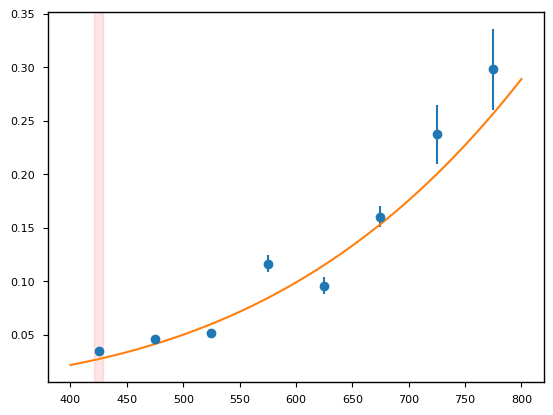

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 797.21it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.98it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 798.36it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.00it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 814.59it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.61it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 812.45it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.24it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.24678933
    reduced chi-square = 1.3493e-04
    Akaike info crit   = -16321.4871
    Bayesian info crit = -16304.9476
[[Variables]]
    gamma1:  0.44252021 +/- 6.7807e-04 (0.15%) (init = 0.1)
    m1:      1.16757973 +/- 7.0626e-04 (0.06%) (init = 1)
    c:      -0.50251816 +/- 0.00173621 (0.35%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9843
    C(gamma1, c)  = -0.9505
    C(gamma1, m1) = +0.9030
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.64965599
    reduced chi-square = 9.0194e-04
    Akaike info crit   = -12841.0773
    Bayesian info crit = -12824.5378
[[Variables]]
    gamma1:  0.27808383 +/- 8.9919e-04 (0.32%) (init = 0.1)

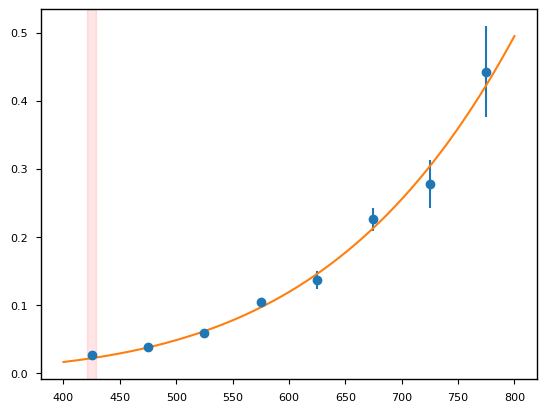

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 811.88it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.17it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 795.55it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.17it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 804.36it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.44it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.50it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.54it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.52842441
    reduced chi-square = 2.8891e-04
    Akaike info crit   = -14926.6669
    Bayesian info crit = -14910.1274
[[Variables]]
    gamma1:  0.37413055 +/- 0.00103055 (0.28%) (init = 0.1)
    m1:      1.04723934 +/- 9.9793e-04 (0.10%) (init = 1)
    c:       0.06207202 +/- 0.00220775 (3.56%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9697
    C(gamma1, c)  = -0.9284
    C(gamma1, m1) = +0.8479
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 1.86427936
    reduced chi-square = 0.00101929
    Akaike info crit   = -12617.0094
    Bayesian info crit = -12600.4699
[[Variables]]
    gamma1:  0.20676239 +/- 6.3144e-04 (0.31%) (init = 0.1)

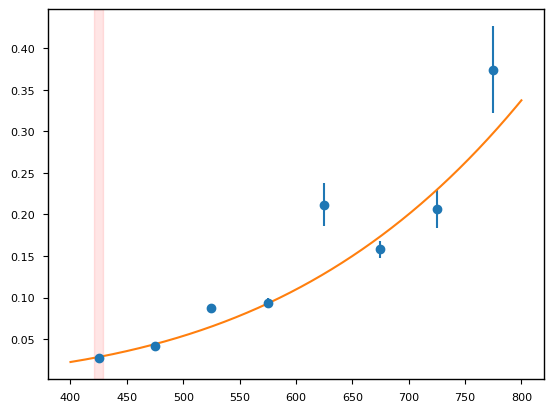

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.14it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 808.89it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 829.80it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 810.40it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 774.74it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 756.31it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.49it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 780.24it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 3.97934695
    reduced chi-square = 0.00217570
    Akaike info crit   = -11227.9079
    Bayesian info crit = -11211.3685
[[Variables]]
    gamma1:  0.22670853 +/- 0.00121471 (0.54%) (init = 0.1)
    m1:      0.90093428 +/- 0.00114014 (0.13%) (init = 1)
    c:      -0.10949848 +/- 0.00199815 (1.82%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma1, c)  = -0.8346
    C(m1, c)      = -0.7949
    C(gamma1, m1) = +0.4680
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.56136736
    reduced chi-square = 3.0693e-04
    Akaike info crit   = -14815.8753
    Bayesian info crit = -14799.3358
[[Variables]]
    gamma1:  0.27138790 +/- 4.7578e-04 (0.18%) (init = 0.1)

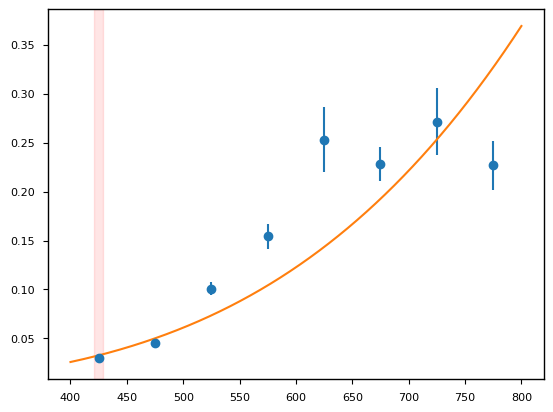

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 791.93it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 769.32it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 772.96it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 777.76it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 776.46it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 779.65it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 782.34it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 792.30it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.12179671
    reduced chi-square = 6.6592e-05
    Akaike info crit   = -17615.2120
    Bayesian info crit = -17598.6725
[[Variables]]
    gamma1:  0.32494257 +/- 4.2770e-04 (0.13%) (init = 0.1)
    m1:      0.89730906 +/- 3.5853e-04 (0.04%) (init = 1)
    c:       0.00843371 +/- 6.7941e-04 (8.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9428
    C(gamma1, c)  = -0.9064
    C(gamma1, m1) = +0.7727
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.76920946
    reduced chi-square = 4.2056e-04
    Akaike info crit   = -14238.8177
    Bayesian info crit = -14222.2782
[[Variables]]
    gamma1:  0.28869968 +/- 6.3386e-04 (0.22%) (init = 0.1)

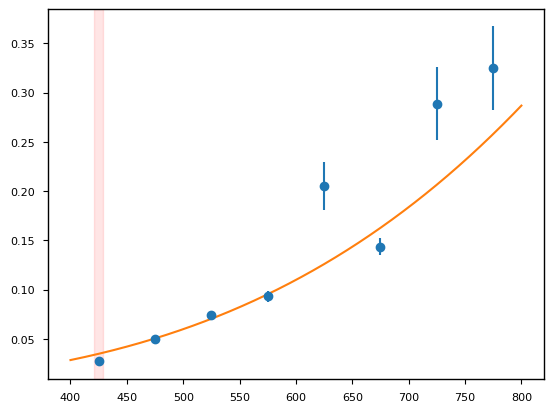

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 788.34it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 790.37it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 794.67it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.99it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 802.26it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.48it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 800.37it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 807.52it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.06061048
    reduced chi-square = 3.3139e-05
    Akaike info crit   = -18893.7382
    Bayesian info crit = -18877.1987
[[Variables]]
    gamma1:  0.33700720 +/- 2.6490e-04 (0.08%) (init = 0.1)
    m1:      1.01280873 +/- 2.4789e-04 (0.02%) (init = 1)
    c:      -0.11103384 +/- 5.3108e-04 (0.48%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9491
    C(gamma1, c)  = -0.9126
    C(gamma1, m1) = +0.7910
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.43683139
    reduced chi-square = 2.3884e-04
    Akaike info crit   = -15275.3926
    Bayesian info crit = -15258.8532
[[Variables]]
    gamma1:  0.37168724 +/- 6.2870e-04 (0.17%) (init = 0.1)

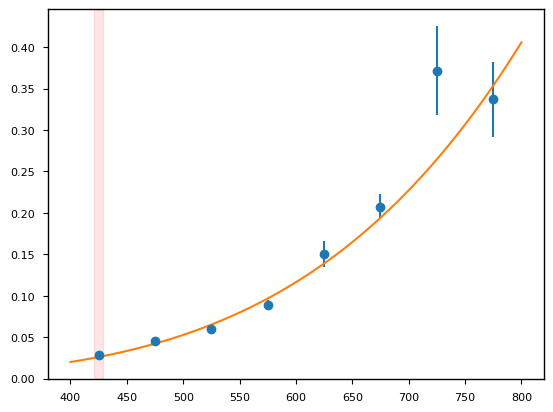

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 820.91it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 823.81it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 825.46it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 818.62it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 832.43it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 816.65it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 817.79it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 840.81it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.02591909
    reduced chi-square = 1.4171e-05
    Akaike info crit   = -20450.0003
    Bayesian info crit = -20433.4608
[[Variables]]
    gamma1:  0.28003375 +/- 2.8612e-04 (0.10%) (init = 0.1)
    m1:      0.65987055 +/- 1.8757e-04 (0.03%) (init = 1)
    c:       0.33323392 +/- 2.5787e-04 (0.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9138
    C(gamma1, c)  = -0.8786
    C(gamma1, m1) = +0.6916
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.60459338
    reduced chi-square = 3.3056e-04
    Akaike info crit   = -14679.9765
    Bayesian info crit = -14663.4370
[[Variables]]
    gamma1:  0.21750262 +/- 4.3516e-04 (0.20%) (init = 0.1)

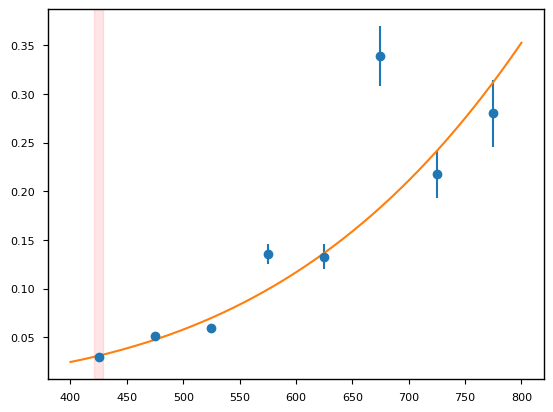

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 851.97it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 863.82it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 846.36it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 852.60it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 865.90it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 806.53it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 855.14it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 828.47it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.13655574
    reduced chi-square = 7.4661e-05
    Akaike info crit   = -17405.6687
    Bayesian info crit = -17389.1292
[[Variables]]
    gamma1:  0.35423694 +/- 6.2121e-04 (0.18%) (init = 0.1)
    m1:      1.04442326 +/- 6.2071e-04 (0.06%) (init = 1)
    c:       0.79584683 +/- 0.00136333 (0.17%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9677
    C(gamma1, c)  = -0.9202
    C(gamma1, m1) = +0.8353
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.84181196
    reduced chi-square = 4.6026e-04
    Akaike info crit   = -14073.5835
    Bayesian info crit = -14057.0440
[[Variables]]
    gamma1:  0.23888583 +/- 5.3881e-04 (0.23%) (init = 0.1)

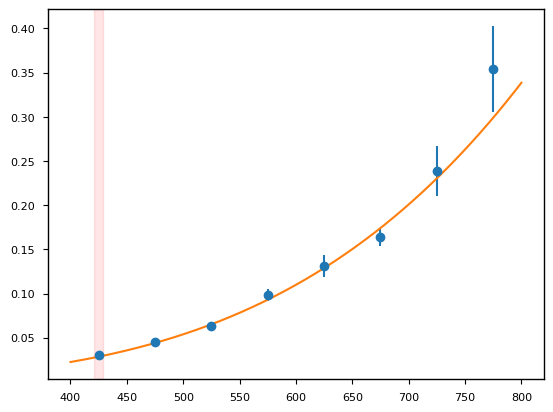

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.37it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 847.69it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 856.55it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 839.52it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.13it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 851.10it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.08it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 854.29it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.29857798
    reduced chi-square = 1.6325e-04
    Akaike info crit   = -15972.4982
    Bayesian info crit = -15955.9588
[[Variables]]
    gamma1:  0.47190290 +/- 8.7293e-04 (0.18%) (init = 0.1)
    m1:      1.30540236 +/- 0.00102412 (0.08%) (init = 1)
    c:      -0.39451041 +/- 0.00279493 (0.71%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9896
    C(gamma1, c)  = -0.9571
    C(gamma1, m1) = +0.9228
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.78203576
    reduced chi-square = 0.00152107
    Akaike info crit   = -11883.6445
    Bayesian info crit = -11867.1050
[[Variables]]
    gamma1:  0.20159582 +/- 8.3140e-04 (0.41%) (init = 0.1)

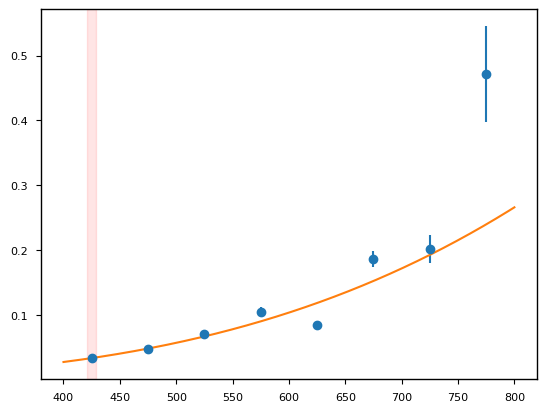

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 848.42it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 869.36it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 822.58it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 853.97it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 830.55it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 838.92it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 852.35it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 853.54it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.03003818
    reduced chi-square = 1.6423e-05
    Akaike info crit   = -20179.7995
    Bayesian info crit = -20163.2600
[[Variables]]
    gamma1:  0.26508704 +/- 1.5953e-04 (0.06%) (init = 0.1)
    m1:      0.80023689 +/- 1.2417e-04 (0.02%) (init = 1)
    c:      -0.04046526 +/- 2.0402e-04 (0.50%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.8706
    C(gamma1, c)  = -0.8681
    C(gamma1, m1) = +0.6119
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.09254377
    reduced chi-square = 5.0598e-05
    Akaike info crit   = -18118.4105
    Bayesian info crit = -18101.8710
[[Variables]]
    gamma1:  0.19555836 +/- 1.8667e-04 (0.10%) (init = 0.1)

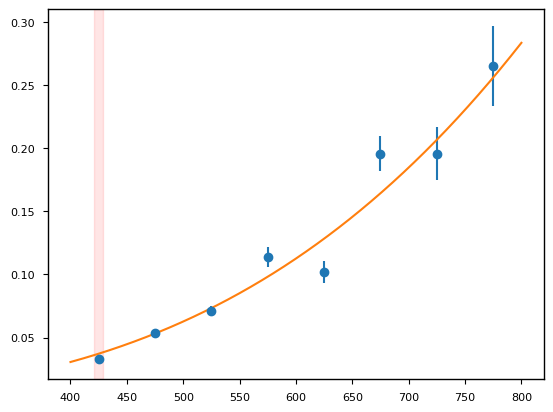

beg,end 0 65536
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 834.61it/s]
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument gamma does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +
/opt/pysetup/.venv/lib/python3.8/site-packages/lmfit/model.py:1123: UserWarning: The keyword argument m does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


Could not fit a Lorentzian
beg,end 65536 131072
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 837.86it/s]


Could not fit a Lorentzian
beg,end 131072 196608
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 842.02it/s]


Could not fit a Lorentzian
beg,end 196608 262144
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 854.79it/s]


Could not fit a Lorentzian
beg,end 262144 327680
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 857.58it/s]


Could not fit a Lorentzian
beg,end 327680 393216
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 836.40it/s]


Could not fit a Lorentzian
beg,end 393216 458752
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 860.78it/s]


Could not fit a Lorentzian
beg,end 458752 -1
Frequency resolution is 0.00076 MHz


100%|██████████| 1310/1310 [00:01<00:00, 856.88it/s]


Could not fit a Lorentzian
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 1832
    # variables        = 3
    chi-square         = 0.09720291
    reduced chi-square = 5.3145e-05
    Akaike info crit   = -18028.4245
    Bayesian info crit = -18011.8850
[[Variables]]
    gamma1:  0.33276557 +/- 3.4936e-04 (0.10%) (init = 0.1)
    m1:      0.97977751 +/- 3.1766e-04 (0.03%) (init = 1)
    c:      -0.05844452 +/- 6.5797e-04 (1.13%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, c)      = -0.9471
    C(gamma1, c)  = -0.9104
    C(gamma1, m1) = +0.7850
None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 1832
    # variables        = 3
    chi-square         = 2.08383287
    reduced chi-square = 0.00113933
    Akaike info crit   = -12413.0449
    Bayesian info crit = -12396.5054
[[Variables]]
    gamma1:  0.21691361 +/- 7.1965e-04 (0.33%) (init = 0.1)

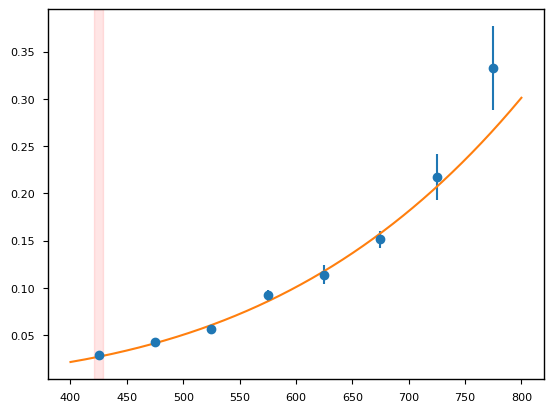

In [130]:
#now let's try fix the flagging and subbanding from the actual analysis and generate 100 spectra to explore how that affects the measurements
ntrials=100

actual_mask=np.flip(np.load('frb20221022a_spec_mask.npy'))


scintbws_actualmask=[]
scintinds_actualmask=[]
err_scintinds_actualmask=[]

for n in range(ntrials):
    
    num_subbands = 64
    subb_len = int(len(freq)/num_subbands)

    spec = []
    for i in range(num_subbands):
        f_cent = np.nanmean(freq[i*subb_len : (i+1)*subb_len])
        corrlen = 124000 * (f_cent/600.)**4/(400e6/(1024*512)) 
        t_scatt = 1/(2*np.pi*corrlen/subb_len)
        t = (np.random.randn(subb_len)+1j*np.random.randn(subb_len))*np.exp(-np.arange(subb_len)/t_scatt)**0.5 
        spec.append(np.abs(np.fft.fft(t))**2)
        
    spec = np.concatenate(spec).ravel()
    
    
    spec_masked=np.ma.array(spec,mask=actual_mask)
    
    acfs,fcents,lags, subsn, submask,spec_lens=acf_per_subband(spec_masked,freq,freq_inds,num_subbands=8,plot_fit=False,maxlag=1,snsubband=False)
    
    lagrange_for_fits=[0.7,0.7,0.7,0.7,0.7,0.7,0.7,0.7]
    f_res=0.39101/512
    sub_scint=[]
    sub_scint_uncert=[]
    f_cents=[]
    
    for i in range(len(fcents)):
        lagrange_for_fit=lagrange_for_fits[i]
        acf=acfs[len(fcents)-i-1]
        lag=lags[len(fcents)-i-1]
        acf_fit=acf[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
        lag_fit=lag[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
        #compute the ACF errors
        acf_half = acf[len(acf)//2:]
        var_f = np.ones(len(acf_half)) / (len(acf_half))
        var_f[1:] *= 1 + 2 * np.cumsum(acf_half[0:-1] ** 2)
        f_errors = np.sqrt(var_f)
    
        f_errors_full = np.concatenate((f_errors[::-1],f_errors))
        acf_fit_errors=f_errors_full[int(len(acf)/2.)-int(lagrange_for_fit/f_res):int(len(acf)/2.)+int(lagrange_for_fit/f_res)]
    
    
        fit=True
        try:
            params = Parameters()
            params.add('gamma1', value = 0.1, min= 0.00001, max = 100)
            params.add('m1', value = 1, min = -100, max = 100)
            params.add('c', value = 0, min = -100, max = 100)


            fit_min = Minimizer(lorentz_withc_min, params, fcn_args=(lag_fit,acf_fit,np.sqrt(acf_fit_errors)))
            result_subacf = fit_min.minimize()
            print(report_fit(result_subacf))
        except:
            print('could not fit')
            fit=False
    
    
        
        if fit==True:
            sub_scint.append(np.abs(result_subacf.params['gamma1']))
            mods1.append(np.abs(result_subacf.params['m1']))
            sub_scint_uncert.append(np.abs(result_subacf.params['gamma1'].stderr))
            mods1_uncert.append(np.abs(result_subacf.params['m1'].stderr))
        
        else:
            sub_scint.append(0)
            sub_scint_uncert.append(0)
        
        
        
        f_cents.append(fcents[len(fcents)-i-1])
        
    #let's fit for the scint bw and index
    params = Parameters()
    params.add('n', value = 4, min = 0, max = 10)
    params.add('c', value = 1)


    good_chans=np.array(spec_lens)-np.array(submask)
    N = 1 + 0.2*((np.flip(good_chans)*f_res) / sub_scint)
    add_un = sub_scint/(2*np.sqrt(N))

    fit_min = Minimizer(scint_freq_relation_min, params, fcn_args=(f_cents[:-1],sub_scint[:-1],np.sqrt(np.array(sub_scint_uncert[:-1])**2 + add_un[:-1]**2)))
    result_scint1 = fit_min.minimize()
    print(report_fit(result_scint1))
    
    plt.close()
    plt.errorbar(f_cents,sub_scint,yerr=np.sqrt(np.array(sub_scint_uncert)**2 + add_un**2),linestyle='none',marker='o')
    plt.plot(freq,scint_freq_relation(freq,result_scint1.params['c'].value,result_scint1.params['n'].value))
    plt.axvspan(f_cents[-1]-4 ,f_cents[-1]+4,color='r',alpha=0.1)
    plt.show()

    scintbws_actualmask.append(scint_freq_relation(600,result_scint1.params['c'].value,result_scint1.params['n'].value))
    scintinds_actualmask.append(result_scint1.params['n'].value)
    err_scintinds_actualmask.append(result_scint1.params['n'].stderr)


In [132]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

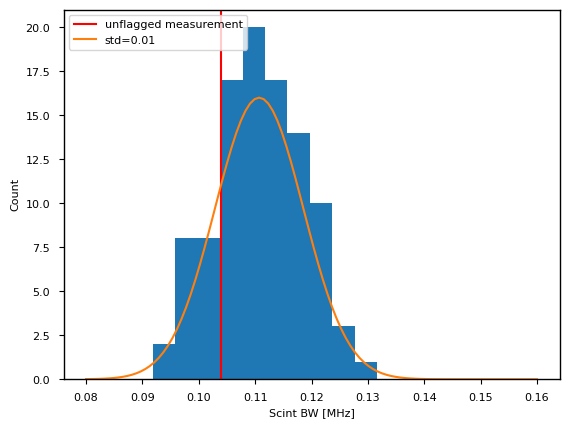

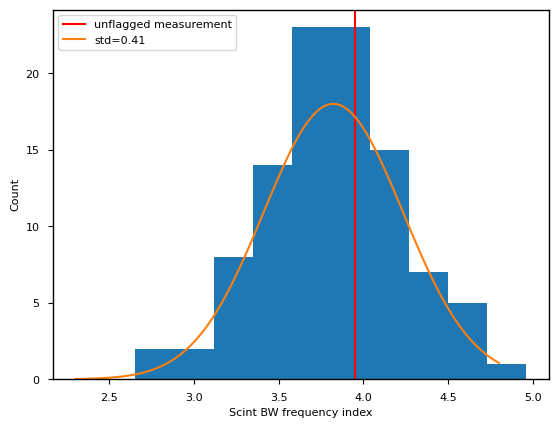

In [133]:
plt.hist(scintbws_actualmask)
plt.axvline(unflag_sb,color='r',label='unflagged measurement')
plt.plot(np.linspace(0.08,0.16,100),gaus(np.linspace(0.08,0.16,100),16,np.mean(scintbws_actualmask),np.std(scintbws_actualmask)),label='std=%.2f'%np.std(scintbws_actualmask))
plt.xlabel('Scint BW [MHz]')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

plt.hist(scintinds_actualmask)
plt.axvline(unflag_index,color='r',label='unflagged measurement')
plt.plot(np.linspace(2.3,4.8,100),gaus(np.linspace(2.3,4.8,100),18,np.mean(scintinds_actualmask),np.std(scintinds_actualmask)),label='std=%.2f'%np.std(scintinds_actualmask))
plt.xlabel('Scint BW frequency index')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()

In [149]:
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'sans-serif'                                                                                                                           
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['xtick.major.pad']='6'
mpl.rcParams['ytick.major.pad']='6'


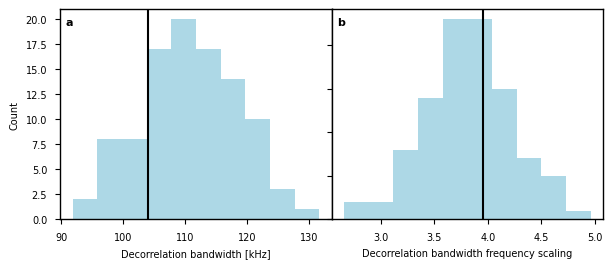

In [152]:
fig = plt.figure(figsize=(7,3.5))
cols=2
rows=1
gs = gridspec.GridSpec(ncols=cols, nrows=rows, bottom=0.2, top=0.8, width_ratios=[1,1], height_ratios=[1], wspace=0, hspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(scintbws_actualmask,color='lightblue')
ax1.axvline(unflag_sb,color='k',label='unflagged measurement')
#ax1.plot(np.linspace(0.08,0.16,100),gaus(np.linspace(0.08,0.16,100),16,np.mean(scintbws_actualmask),np.std(scintbws_actualmask)),label='std=%.2f'%np.std(scintbws_actualmask))
ax1.text(.02, .96, 'a', ha='left', va='top', transform=ax1.transAxes,fontsize=8, fontweight='bold')

ax2 = fig.add_subplot(gs[0,1])
ax2.hist(scintinds_actualmask,color='lightblue')
ax2.axvline(unflag_index,color='k',label='unflagged measurement')
#ax2.plot(np.linspace(2.3,4.8,100),gaus(np.linspace(2.3,4.8,100),18,np.mean(scintinds_actualmask),np.std(scintinds_actualmask)),label='std=%.2f'%np.std(scintinds_actualmask))
ax2.text(.02, .96, 'b', ha='left', va='top', transform=ax2.transAxes,fontsize=8, fontweight='bold')

ax1.set_xticks([0.09,0.1,0.11,0.12,0.13],[90,100,110,120,130])
#axis labels
ax1.set_ylabel('Count')
ax1.set_xlabel('Decorrelation bandwidth [kHz]')
ax2.set_xlabel('Decorrelation bandwidth frequency scaling')

#hide axes
plt.setp(ax2.get_yticklabels(), visible=False)

plt.savefig('simulations.final.jpg',format='jpg',dpi=300)
plt.show()

## And the emission size constraints

In [135]:
mpl.rcParams['font.size'] = 8
mpl.rcParams['font.family'] = 'sans-serif'                                                                                                                           
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['xtick.major.pad']='6'
mpl.rcParams['ytick.major.pad']='6'

In [136]:
wavelength = cons.c / 600e6 # m
gal_lens_distances = np.logspace(-5,8,10000) #kpc
twoscr_constr = 9.1 #kpc^2
ext_lens_distances = twoscr_constr/gal_lens_distances


non-mag 143.7014777808813
0.00011861862991308733
0.011886472597040303
upper lim on size 30459.376499331756


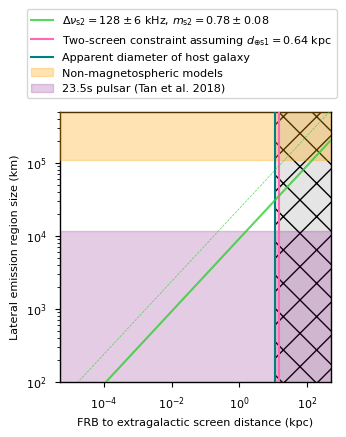

In [137]:
#main text figure
rows = 1
cols = 1
fig = plt.figure(figsize=(3.50394,6))
 
gs = gridspec.GridSpec(ncols=cols, nrows=rows, bottom=0.2, top=0.65, width_ratios=[1], height_ratios=[1], wspace=0, hspace=0)

#start with the large scale, lower mod ind
scint_bw=128 #kHz
scint_bw_uncert=6 #kHz
scat_lens = 1/(2*np.pi*scint_bw) #ms
m=0.78 #modulation index
m_uncert=0.08

res_per_dist = []
emission_size_per_dist = []
for lens_dist in ext_lens_distances:
    res_per_dist.append(res(lens_dist,wavelength,scat_lens))
    emission_size_per_dist.append(emission_size(res_per_dist[-1], m))

print("non-mag",ext_lens_distances[np.argmin(np.abs(np.array(emission_size_per_dist)-1.1e5))])
print(ext_lens_distances[np.argmin(np.abs(np.array(emission_size_per_dist)-100))])
print(ext_lens_distances[np.argmin(np.abs(np.array(emission_size_per_dist)-1000))])
print("upper lim on size",emission_size_per_dist[np.argmin(np.abs(np.array(ext_lens_distances)-11))])

   
ax1 = fig.add_subplot(gs[0,0])
ax1.plot(ext_lens_distances, emission_size_per_dist,color='limegreen',alpha=0.8,label=r'$\Delta\nu_{\mathrm{s}2}=128\pm6$ kHz, $m_{\mathrm{s}2}=0.78\pm0.08$',zorder=12)

#3 sigma error bars calculated by propagating the scint bw and mod ind errors through Eq 23 in Nimmo et al. 2024.
x = (1/m**2 -1)
sig_x = (2*m_uncert/m**3)
onesig_err = np.sqrt((scint_bw_uncert/scint_bw)**2 + (sig_x/x)**2)*np.array(emission_size_per_dist) 

ax1.plot(ext_lens_distances, np.array(emission_size_per_dist)+3*onesig_err,color='limegreen',alpha=0.8,zorder=12, linestyle='--',lw=0.5)
ax1.plot(ext_lens_distances, np.array(emission_size_per_dist)-3*onesig_err,color='limegreen',alpha=0.8,zorder=12, linestyle='--',lw=0.5)

ax1.axvline(14.1, color='hotpink',label='Two-screen constraint assuming'+r' $d_{\oplus\mathrm{s}1}=0.64$ kpc',zorder=10)
ax1.axvline(11, color='teal',label=r'Apparent diameter of host galaxy',zorder=11) #semi-major axis of galaxy 
ax1.fill_betweenx(emission_size_per_dist,11,1000, facecolor='grey',alpha=0.2,hatch="X",edgecolor=None,zorder=1) 
ax1.axhspan(1.1e5,1.1e7, color='orange',alpha=0.3,label='Non-magnetospheric models',zorder=9) #the non-magnetospheric range, lower bound from Margalit et al. 2020
ax1.axhspan(0,2400*np.sqrt(23.5), color='purple',alpha=0.2,label='23.5s pulsar (Tan et al. 2018)')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(1e2,5e5)
ax1.set_xlim(5e-6,5e2)
ax1.legend(loc='upper center', bbox_to_anchor=(0.45, 1.4))

ax1.set_ylabel('Lateral emission region size (km)')
ax1.set_xlabel('FRB to extragalactic screen distance (kpc)')
    
plt.savefig('emission_size_of_FRB.final.pdf', format='pdf',bbox_inches='tight')
plt.show()
    

In [147]:
mpl.rcParams['font.size'] = 7
mpl.rcParams['font.family'] = 'sans-serif'                                                                                                                           
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['xtick.major.pad']='6'
mpl.rcParams['ytick.major.pad']='6'


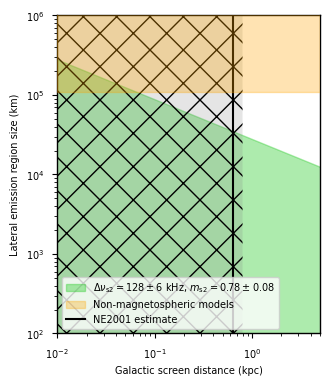

In [139]:
# extended data figures
rows = 1
cols = 1
fig = plt.figure(figsize=(3.50394,5.3))
 
gs = gridspec.GridSpec(ncols=cols, nrows=rows, bottom=0.2, top=0.8, left=0.2,right=0.95,width_ratios=[1], height_ratios=[1], wspace=0, hspace=0)
    
ax2 = fig.add_subplot(gs[0,0])

scat_lens = 1/(2*np.pi*128) #ms
m=0.78 #modulation index

res_per_dist = []
emission_size_per_dist = []
for lens_dist in ext_lens_distances:
    res_per_dist.append(res(lens_dist,wavelength,scat_lens))
    emission_size_per_dist.append(emission_size(res_per_dist[-1], m))

emission_size_upp_lims=[]
for e in ext_lens_distances:
    emission_size_upp_lims.append(emission_size_per_dist[np.argmin(np.abs(np.array(ext_lens_distances)-e))])

ax2.fill_between(gal_lens_distances,0,np.array(emission_size_upp_lims), color='limegreen',alpha=0.4,label=r'$\Delta\nu_{\mathrm{s}2}=128\pm6$ kHz, $m_{\mathrm{s}2}=0.78\pm0.08$')
ax2.axhspan(1.1e5,1.1e7, color='orange',alpha=0.3,label='Non-magnetospheric models',zorder=9)
ax2.axvline(0.64, color='k', label='NE2001 estimate') #NE2001 Gal screen distance
ax2.fill_betweenx(gal_lens_distances,0,8.8/11.,facecolor='grey',alpha=0.2,hatch="X",edgecolor=None,zorder=1) 
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(1e2,1e6)
ax2.set_xlim(1e-2,5)
ax2.legend(loc='lower left')

ax2.set_ylabel('Lateral emission region size (km)')
ax2.set_xlabel('Galactic screen distance (kpc)')

plt.savefig('dependence_on_gal_lens.final.jpg', format='jpg',bbox_inches='tight',dpi=300)
plt.show()
    


46143.64519576563
909999.9999999999


/tmp/ipykernel_72/1904017021.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0.1)


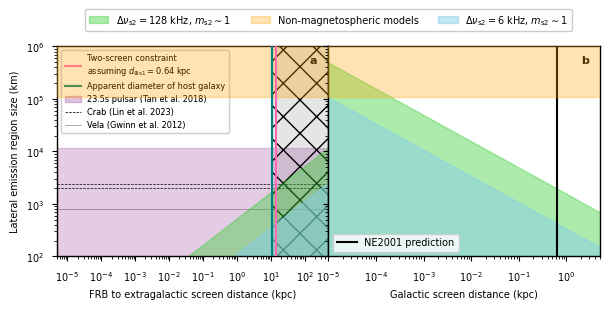

In [140]:
#extended data figure of other cases

rows = 1
cols = 2
fig = plt.figure(figsize=(7,3.5))

gs = gridspec.GridSpec(ncols=cols, nrows=rows, bottom=0.2, top=0.8, width_ratios=[1,1], height_ratios=[1], wspace=0, hspace=0)
    
# large scale, m=1
scat_lens = 1/(2*np.pi*128) #ms
m=0.999 #modulation index

res_per_dist = []
emission_size_per_dist = []
for lens_dist in ext_lens_distances:
    res_per_dist.append(res(lens_dist,wavelength,scat_lens))
    emission_size_per_dist.append(emission_size(res_per_dist[-1], m))
   
ax3 = fig.add_subplot(gs[0,0])
ax3.axvline(14.1, color='hotpink',label='Two-screen constraint\nassuming'+r' $d_{\oplus\mathrm{s}1}=0.64$ kpc',zorder=10) #two-screen constraint assuming NE2001 for the Gal screen distance
ax3.axvline(11, color='teal',label=r'Apparent diameter of host galaxy',zorder=11) #semi-major axis of galaxy 
ax3.axhspan(0,2400*np.sqrt(23.5), color='purple',alpha=0.2,label='23.5s pulsar (Tan et al. 2018)')
ax3.axhline(2000,color='k',linestyle='--',linewidth=0.5,label='Crab (Lin et al. 2023)')
ax3.axhline(2400,color='k',linestyle='--',linewidth=0.5)
ax3.axhline(800,color='k',alpha=0.4,linestyle='-',linewidth=0.5,label='Vela (Gwinn et al. 2012)')
legend1=ax3.legend(loc='upper left',fontsize='small',facecolor='white', framealpha=0.8)
ax3.add_artist(legend1)

ax3.fill_between(ext_lens_distances, 0,emission_size_per_dist,color='limegreen',alpha=0.4,zorder=2)
ax3.fill_betweenx(np.linspace(0,1e7,100),11,1000, facecolor='grey',alpha=0.2,hatch="X",edgecolor=None,zorder=1) 
ax3.axhspan(1.1e5,1.1e7, color='orange',alpha=0.3,label='Non-magnetospheric models',zorder=9)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim(1e2,5e5)
ax3.set_xlim(5e-6,5e2)
print(ext_lens_distances[np.argmin(np.abs(np.array(emission_size_per_dist)-1.1e5))])
ax3.text(.93, .96, 'a', ha='left', va='top', transform=ax3.transAxes,fontsize=8, fontweight='bold')
    
ax4 = fig.add_subplot(gs[0,1],sharey=ax3)

emission_size_upp_lims=[]
for e in ext_lens_distances:
    emission_size_upp_lims.append(emission_size_per_dist[np.argmin(np.abs(np.array(ext_lens_distances)-e))])

ax4.fill_between(gal_lens_distances,0,np.array(emission_size_upp_lims), color='limegreen',alpha=0.4,label=r'$\Delta\nu_{\mathrm{s}2}=128$ kHz, $m_{\mathrm{s}2}\sim1$')
ax4.axhspan(1.1e5,1.1e7, color='orange',alpha=0.3,label='Non-magnetospheric models',zorder=9)
l1=ax4.axvline(0.64, color='k') #NE2001 Gal screen distance
    
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_ylim(1e2,1e6)
ax4.set_xlim(1e-5,5)
ax4.text(.93, .96, 'b', ha='left', va='top', transform=ax4.transAxes,fontsize=8, fontweight='bold')
 
# small scale, m=1
scat_lens = 1/(2*np.pi*6) #ms
m=0.999 #modulation index

res_per_dist = []
emission_size_per_dist = []
for lens_dist in ext_lens_distances:
    res_per_dist.append(res(lens_dist,wavelength,scat_lens))
    emission_size_per_dist.append(emission_size(res_per_dist[-1], m))
   
ax3.fill_between(ext_lens_distances, 0,emission_size_per_dist,color='skyblue',alpha=0.5,zorder=2)
print(ext_lens_distances[np.argmin(np.abs(np.array(emission_size_per_dist)-1.1e5))])
   
emission_size_upp_lims=[]
for e in ext_lens_distances:
    emission_size_upp_lims.append(emission_size_per_dist[np.argmin(np.abs(np.array(ext_lens_distances)-e))])


ax4.fill_between(gal_lens_distances,0,np.array(emission_size_upp_lims), color='skyblue',alpha=0.5,label=r'$\Delta\nu_{\mathrm{s}2}=6$ kHz, $m_{\mathrm{s}2}\sim1$')
legend1 = plt.legend([l1], ["NE2001 prediction"], loc='lower left')
ax4.legend(loc='upper center', bbox_to_anchor=(0, 1.2),ncol=3,facecolor='white',framealpha=1)
plt.gca().add_artist(legend1)
 
#axis labels
ax3.set_ylabel('Lateral emission region size (km)')
ax3.set_xlabel('FRB to extragalactic screen distance (kpc)')
ax4.set_xlabel('Galactic screen distance (kpc)')

#hide axes
plt.setp(ax4.get_yticklabels(), visible=False)
    
fig.tight_layout(pad=0.1)
plt.savefig('other_cases_emission_size_of_FRB.final.jpg', format='jpg',bbox_inches='tight',dpi=300)
plt.show()
    
